# Bank of England Sentiment Analysis
## Employer Project
### Team 8 AnalytIQ, June 2nd, 2025
**Team Members**: Lalitha Vemuri, Christina Tsoulfa, Reka Bodo, Yann Hirsig, Louis Pang, Dr. Karin Agius Ferrante

## Content
1. Approach
2. Load the Data
4. Exploratory Sentiment Analysis & Natural Language Processing (NLP)
5. Exploratory Analysis for Correlation with Economic Indicators
8. Insights & Recommendations

## 1. Approach

The **Bank of England (BoE)**, the UK’s central bank and one of the world’s leading financial institutions, plays a pivotal role in maintaining economic and financial stability, and supporting the UK government’s economic policies. One of its key communication channels with the public and markets is through formal speeches delivered by its representatives. These speeches aim to offer guidance, manage expectations, and provide clarity in times of uncertainty.

However, the effectiveness and impact of these speeches on economic indicators and market behaviour are not fully understood. 

This project seeks to explore whether the sentiment and timing of BoE speeches hold analytical or predictive value, when compared with economic performance and key events.

### Main Business Questions
**Has the tone or sentiment of the BoE’s speeches evolved over time? If so, how?**<br>
**How do sentiments align with events like interest rate changes, policy reports, or major economic releases?**

**Sub-questions**

1.	Are there measurable correlations between speech sentiment and UK economic indicators such as inflation, GDP, employment rates and bond yields?
2. Does the change in sentiment change economic indicators or is the speech sentiment reactive to economic indicators?
3. Can speech sentiment trends be used to predict market reactions or economic outcomes?
4. What broader insights can be drawn to support data-informed communication strategies?

## 2. Load the Data

### 2.1. Import libraries

In [11]:
# Install the necessary libraries.
# !pip install nltk
# !pip install vaderSentiment
# !pip install textblob
# !pip install pandas openpyxl
# !pip install transformers torch

In [12]:
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('omw-1.4')

In [13]:
# General libraries
import numpy as np                             # Numerical operations and array handling.
import pandas as pd                            # Data manipulation and analysis.
import contractions                            # Expanding/contracting text contractions.
import re                                      # Regular expression operations on strings.
import os                                      # Interacting with the operating system and file handling.
import matplotlib.pyplot as plt                # Create visualisations.
from matplotlib.colors import rgb2hex          # Colour conversion in plots.
import seaborn as sns                          # Enhanced statistical data visualisations.
import math                                    # Mathematical functions and constants.
from IPython.display import display, Markdown  # Rich output in Jupyter.
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer
from collections import  Counter
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose   # Seasonality

In [14]:
# Text and Sentiment Analysis 
from wordcloud import WordCloud                                       # Generating visual word frequency clouds from text.
import nltk                                                           # Natural language processing tasks.
from nltk import word_tokenize, pos_tag                               # Splitting text into words and tags with part of speech
from nltk import defaultdict                                          # Providing default values for nonexistent keys.
from nltk.probability import FreqDist                                 # Calculating frequency distribution of tokens.
from nltk.corpus import stopwords                                     # Providing list of common words to exclude from analysis.
from nltk.corpus import words
from nltk.corpus import wordnet as wn                                 # Lexical database for retrieving word relationships & meanings.
from nltk.stem import WordNetLemmatizer, PorterStemmer                # Reducing words to base or root form.
from nltk.probability import FreqDist
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer  # Assessing sentiment intensity in text.
from textblob import TextBlob                                         # API for text processing tasks including sentiment analysis.
import contractions                                                   # Expanding/contracting text contractions.
import re                                                             # Regular expression operations on strings.
import ast                                                            # If column contains string representations of lists
from collections import defaultdict  # Creating dictionaries that return default value for nonexistent keys.
from collections import Counter  # Importing Counter for counting hashable objects and efficiently tallying occurrences in an iterable.
from transformers import AutoTokenizer                                # FinBERT Model
from transformers import AutoModelForSequenceClassification           # FinBERT Model
import torch                                                          # FinBERT Model
import torch.nn.functional as F                                       # FinBERT Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
stop_words = set(stopwords.words('english'))

In [15]:
# FinBERT Models: Load model 1: ProsusAI/finbert
tokenizer_prosus = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model_prosus = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert').to(device)

In [16]:
# FinBERT Models: Load model 2: yiyanghkust/finbert-tone
tokenizer_yiyang = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')
model_yiyang = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone').to(device)

In [17]:
# Import warnings
import warnings
# Settings for the notebook.
warnings.filterwarnings("ignore")

In [18]:
# Set figure style for seaborn.
sns.set_theme(style='darkgrid')

### 2.2. Define functions

**2.2.a. Charts**

In [21]:
def clean_label(label):
    # If label is a Series, return its name.
    if isinstance(label, pd.Series):
        return label.name.replace('_', ' ').title() if label.name else ' '
    elif isinstance(label, str):
        return label.replace('_', ' ').title()
    return ' '

In [22]:
# Define function for scatterplot.
def generate_scatterplot(df, x_axis, y_axis, title, hue, save_path=None):

    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(8, 6)})

    # Plot the scatterplot.
    sns.scatterplot(data=df, x=x_axis, y=y_axis, hue=hue, color='#0e1b2c')

    # Customize the plot.
    plt.title(title, fontsize=12, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=10)
    plt.ylabel(clean_label(y_axis), fontsize=10)

    # Add legend ONLY if hue is not None.
    if hue is not None:
        plt.legend(title='Legend', fontsize=10, bbox_to_anchor=(1.05,1), loc='upper left')
    
    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')

    # Display the chart.
    plt.tight_layout()
    plt.show()

In [23]:
# Define function to plot a lineplot.
def generate_lineplot(df, x_axis, y_axis, title, ylim=None, save_path=None, \
                      rotate_xticks=False):
    
    # Set figure size & style for seaborn.
    sns.set_theme(style='darkgrid')
    sns.set(rc={'figure.figsize':(14, 8)})
    
    # Ensure time column is in datetime format.
    df[x_axis] = pd.to_datetime(df[x_axis])
    
    # Sort DataFrame by the time column.
    df.sort_values(by=x_axis, inplace=True)
    
    # Plot the lineplot.
    sns.lineplot(data=df, x=x_axis, y=y_axis, label=clean_label(y_axis))
    
    # Customize the plot.
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel(clean_label(x_axis), fontsize=14)
    plt.ylabel(clean_label(y_axis), fontsize=14)
    plt.legend(title='Legend', fontsize=12, bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tick_params(axis='both', labelsize=12)
    
    # Rotate x-tick labels by 45 degrees, if specified.
    if rotate_xticks:
        plt.xticks(rotation=45)
    
    # Set y-axis limits, if provided.
    if ylim:
        plt.ylim(ylim)

    # Save the plot, if save_path is provided.
    if save_path:
        plt.savefig(save_path, dpi=500, bbox_inches='tight')
    
    # Display the chart.
    plt.tight_layout()
    plt.show()

**2.2.b. NLP analysis**

In [25]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions i.e I'm not good goes to I am not good
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub('#', '', text)         # Remove hashtags
    text = re.sub(r'\W', ' ', text)      # Remove special characters
    text = text.lower()                  # Convert to lowercase
    #Below is to create a set of stop words from the NLTK library's predefined list but not is excluded.
    stop_words = set(stopwords.words('english')) - {'not'} 
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [26]:
# Define the tag map for POS tagging.
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Lemmatise the tokens with correct POS tags.
lemma_function = WordNetLemmatizer()

# Lemmatisation function.
def lemmatize_tokens(tokens):
    #For each word in the token list, it lemmatizes the word with the correct part-of-speech
    lemmatized_tokens = [lemma_function.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tag(tokens)]
    return lemmatized_tokens

In [238]:
# VADER Sentiment Intensity Analyzer.
analyzer = SentimentIntensityAnalyzer()

# Define the function to compute and return sentiment scores.
def analyse_sentiment(text):
    return analyzer.polarity_scores(' '.join(text))

In [28]:
# Define function to label sentiments.
def get_sentiment_label(compound):
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [29]:
# Define a function to extract a polarity score using TextBlob.
def generate_polarity(comment):
    return TextBlob(comment).sentiment[0]

In [30]:
# Define a function to extract a subjectivity score using TextBlob.
def generate_subjectivity(comment):
    return TextBlob(comment).sentiment[1]

### 2.3. Import and review the data

**2.3.a. Import Bank of England Speeches**

In [33]:
# Load the CSV file as speeches.
speeches = pd.read_csv('/Users/kaferrante/Documents/Python/_Course4_Project/all_speeches.csv')

# View the data.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  
0  fraser       0  They would no doubt argue that to have two obj...  
1  fraser       0  Today I wish to talk about real interest rates...  
2  fraser       0  I welcome this opportunity to talk about prosp...  
3  fraser       0  It is a pleasure to have this opportunity to a...  
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...

In [34]:
# Explore data set.
speeches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7721 entries, 0 to 7720
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reference  7721 non-null   object
 1   country    7721 non-null   object
 2   date       7721 non-null   object
 3   title      7721 non-null   object
 4   author     7721 non-null   object
 5   is_gov     7721 non-null   int64 
 6   text       7721 non-null   object
dtypes: int64(1), object(6)
memory usage: 422.4+ KB


In [35]:
# Check for missing values.
speeches.isnull().sum()

reference    0
country      0
date         0
title        0
author       0
is_gov       0
text         0
dtype: int64

In [36]:
# Check for duplicates.
speeches.duplicated().sum()

0

In [37]:
# Review basic descriptive statistics.
speeches.describe()

is_gov
count  7721.000000
mean      0.347235
std       0.476122
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [38]:
# Check the number of unique values.
speeches.nunique()

reference    7721
country         8
date         4410
title        6218
author        325
is_gov          2
text         7692
dtype: int64

In [39]:
# View the countries.
speeches['country'].unique()

array(['australia', 'canada', 'euro area', 'japan', 'sweden',
       'switzerland', 'united kingdom', 'united states'], dtype=object)

In [40]:
# View the author.
speeches['author'].unique()

array(['fraser', 'macfarlane', 'lowe', 'stevens', 'no_info', 'ac',
       'thiessen', 'bonin', 'dodge', 'jenkins', 'kennedy', 'macklem',
       'duguay', 'longworth', 'carney', 'murray', 'lane', 'wolf',
       'boivin', 'cote', 'poloz', 'schembri', 'johnson', 'wilkins',
       'chilcott', 'mendes', 'patterson', 'murchison', 'leduc', 'dinis',
       'beaudry', 'gravelle', 'kozicki', 'rogers', 'morrow', 'lamfalussy',
       'duisenberg', 'vienna', 'london', 'tokyo', 'kong', 'bank',
       'schioppa', 'hamalainen', 'main', 'noyer', 'committee', 'solans',
       'francisco', 'istanbul', 'issing', 'hoogduin', 'bankwashington',
       'efma', 'brussels', 'forum', 'workshop', 'quiros', 'papademos',
       'gugerell', 'trichet', 'network', 'delivered', 'paramo',
       'strasbourg', 'rome', 'berlin', 'smaghi', 'sevilla', 'madrid',
       'stark', 'singapore', 'summit', 'washington', 'aires',
       'bratislava', 'ecb', 'constancio', 'posen', 'praet', 'draghi',
       'coeure', 'asmussen', 'mer

**2.3.b. Import Sentiment Label Lexicon**

**BoE Word List**

In [43]:
# Load the Excel file of BoE sentiment labelled wordlist.
sentiment_lexicon = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/sentiment_labelled_wordlist.xlsx')

# View the data.
sentiment_lexicon.head()

Word  Negative  Positive  Uncertainty  Litigious  Strong  Weak  \
0       ABANDON         1         0            0          0       0     0   
1     ABANDONED         1         0            0          0       0     0   
2    ABANDONING         1         0            0          0       0     0   
3   ABANDONMENT         1         0            0          0       0     0   
4  ABANDONMENTS         1         0            0          0       0     0   

   Constraining  
0             0  
1             0  
2             0  
3             0  
4             0

In [44]:
# Explore data set.
sentiment_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Word          3880 non-null   object
 1   Negative      3880 non-null   int64 
 2   Positive      3880 non-null   int64 
 3   Uncertainty   3880 non-null   int64 
 4   Litigious     3880 non-null   int64 
 5   Strong        3880 non-null   int64 
 6   Weak          3880 non-null   int64 
 7   Constraining  3880 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 242.6+ KB


In [45]:
# Check for missing values.
sentiment_lexicon.isnull().sum()

Word            0
Negative        0
Positive        0
Uncertainty     0
Litigious       0
Strong          0
Weak            0
Constraining    0
dtype: int64

In [46]:
# Review basic descriptive statistics.
sentiment_lexicon.describe()

Negative     Positive  Uncertainty    Litigious       Strong  \
count  3880.000000  3880.000000  3880.000000  3880.000000  3880.000000   
mean      0.606959     0.092268     0.076546     0.233247     0.004897   
std       0.488489     0.289441     0.265905     0.422953     0.069815   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       1.000000     0.000000     0.000000     0.000000     0.000000   
75%       1.000000     0.000000     0.000000     0.000000     0.000000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              Weak  Constraining  
count  3880.000000   3880.000000  
mean      0.006959      0.047423  
std       0.083139      0.212569  
min       0.000000      0.000000  
25%       0.000000      0.000000  
50%       0.000000      0.000000  
75%       0.000000      0.000000  
max       1.000000      1.000000

**GPT Sentiment**

In [48]:
# Load the CSV file as speeches.
gpt_sentiment = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/boe_sentiment_results.xlsx')

# View the data.
gpt_sentiment.head()

Reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  Gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [49]:
# Rename the confidence index column.
gpt_sentiment.rename(columns={'Reference': 'reference'}, inplace=True)

# View the DataFrame.
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  Gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [50]:
# Rename the column
gpt_sentiment.rename(columns={'Gpt_sentiment': 'gpt_sentiment'}, inplace=True)

# View the DataFrame.
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [51]:
# View the countries.
gpt_sentiment['gpt_sentiment'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

**2.3.c. Import UK Economic Indicators (1998-2025)**

In [53]:
# Load the Excel file for UK Economic Indicators
uk_economic_indicators = pd.read_excel('/Users/kaferrante/Documents/Python/_Course4_Project/Consolidated_Eco_KPI _V3.xlsx')

# View the data.
uk_economic_indicators.head()

year  month year_month  uk_inflation_rate_CPIH  uk_unemployment_rate  \
0  1998      4    1998-04                   1.815                   6.3   
1  1998      5    1998-05                   2.039                   6.3   
2  1998      6    1998-06                   1.675                   6.3   
3  1998      7    1998-07                   1.443                   6.3   
4  1998      8    1998-08                   1.327                   6.2   

   uk_gdp_growth  uk_interest_rate  uk_consumer_confidence  gbp_usd_fx  \
0            0.6              7.25                     1.1    1.673270   
1            0.6              7.25                     1.2    1.636589   
2            0.6              7.50                    -1.3    1.650718   
3            0.3              7.50                    -4.3    1.643657   
4            0.3              7.50                    -6.5    1.631950   

      ftse_250  gilts_short   gilts_medium   gilts_long   \
0  5554.720972          5.91           5.70         5.71   
1  5799.256322          5.82           5.57         5.55   
2  5739.277233          6.17           5.64         5.43   
3  5595.919582          6.06           5.57         5.38   
4  5173.355054          5.52           5.19         5.11   

   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0                    14.1                      24.7   
1                    14.4                      24.5   
2                    13.9                      25.5   
3                    14.6                      25.6   
4                    14.6                      26.1   

   avg_price_all_property_types  
0                         64258  
1                         64258  
2                         64258  
3                         67057  
4                         67057

In [54]:
# Explore data set.
uk_economic_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          321 non-null    int64  
 1   month                         321 non-null    int64  
 2   year_month                    321 non-null    object 
 3   uk_inflation_rate_CPIH        321 non-null    float64
 4   uk_unemployment_rate          321 non-null    float64
 5   uk_gdp_growth                 321 non-null    float64
 6   uk_interest_rate              321 non-null    float64
 7   uk_consumer_confidence        321 non-null    float64
 8   gbp_usd_fx                    321 non-null    float64
 9   ftse_250                      321 non-null    float64
 10  gilts_short                   321 non-null    float64
 11  gilts_medium                  321 non-null    float64
 12  gilts_long                    321 non-null    float64
 13  uk_cr

In [55]:
# Check for missing values.
uk_economic_indicators.isnull().sum()

year                            0
month                           0
year_month                      0
uk_inflation_rate_CPIH          0
uk_unemployment_rate            0
uk_gdp_growth                   0
uk_interest_rate                0
uk_consumer_confidence          0
gbp_usd_fx                      0
ftse_250                        0
gilts_short                     0
gilts_medium                    0
gilts_long                      0
uk_credit_growth_no_cc          0
uk_credit_growth_only_cc        0
avg_price_all_property_types    0
dtype: int64

In [56]:
# View column types.
uk_economic_indicators.dtypes

year                              int64
month                             int64
year_month                       object
uk_inflation_rate_CPIH          float64
uk_unemployment_rate            float64
uk_gdp_growth                   float64
uk_interest_rate                float64
uk_consumer_confidence          float64
gbp_usd_fx                      float64
ftse_250                        float64
gilts_short                     float64
gilts_medium                    float64
gilts_long                      float64
uk_credit_growth_no_cc          float64
uk_credit_growth_only_cc        float64
avg_price_all_property_types      int64
dtype: object

### 2.4. Date Transformation

**Speeches**

In [59]:
# Determine the date format for speeches.
speeches.date.head()

0    1990-11-28
1    1991-10-03
2    1992-03-14
3    1992-05-29
4    1992-08-17
Name: date, dtype: object

In [60]:
# Change date format from 'object' to 'datetime64' and display in a new column
speeches['date_format'] = speeches['date'].astype('datetime64[ns]')

In [61]:
# Add a new column for year and month
speeches['year_month'] = pd.to_datetime(speeches['date_format']).dt.to_period('M')

In [62]:
# Add a new column for year only
speeches['year'] = pd.to_datetime(speeches.date).dt.year

In [63]:
# Add a column for year_month in date format
speeches['year_month_dt'] = speeches['year_month'].dt.to_timestamp()

In [64]:
# View the DataFrame.
speeches.head()

reference    country        date                               title  \
0  r901128a_BOA  australia  1990-11-28   A Proper Role for Monetary Policy   
1  r911003a_BOA  australia  1991-10-03                                       
2  r920314a_BOA  australia  1992-03-14                                       
3  r920529a_BOA  australia  1992-05-29                                       
4  r920817a_BOA  australia  1992-08-17                                       

   author  is_gov                                               text  \
0  fraser       0  They would no doubt argue that to have two obj...   
1  fraser       0  Today I wish to talk about real interest rates...   
2  fraser       0  I welcome this opportunity to talk about prosp...   
3  fraser       0  It is a pleasure to have this opportunity to a...   
4  fraser       0  As a long-time fan of Don Sanders, I am deligh...   

  date_format year_month  year year_month_dt  
0  1990-11-28    1990-11  1990    1990-11-01  
1  1991-10-03    1991-10  1991    1991-10-01  
2  1992-03-14    1992-03  1992    1992-03-01  
3  1992-05-29    1992-05  1992    1992-05-01  
4  1992-08-17    1992-08  1992    1992-08-01

In [65]:
# View column types.
speeches.dtypes

reference                object
country                  object
date                     object
title                    object
author                   object
is_gov                    int64
text                     object
date_format      datetime64[ns]
year_month            period[M]
year                      int32
year_month_dt    datetime64[ns]
dtype: object

**Indicators**

In [68]:
# Add a new column for year and month.
uk_economic_indicators['year_month'] = pd.to_datetime(uk_economic_indicators['year_month']).dt.to_period('M')

In [69]:
# View the DataFrame.
uk_economic_indicators.head()

year  month year_month  uk_inflation_rate_CPIH  uk_unemployment_rate  \
0  1998      4    1998-04                   1.815                   6.3   
1  1998      5    1998-05                   2.039                   6.3   
2  1998      6    1998-06                   1.675                   6.3   
3  1998      7    1998-07                   1.443                   6.3   
4  1998      8    1998-08                   1.327                   6.2   

   uk_gdp_growth  uk_interest_rate  uk_consumer_confidence  gbp_usd_fx  \
0            0.6              7.25                     1.1    1.673270   
1            0.6              7.25                     1.2    1.636589   
2            0.6              7.50                    -1.3    1.650718   
3            0.3              7.50                    -4.3    1.643657   
4            0.3              7.50                    -6.5    1.631950   

      ftse_250  gilts_short   gilts_medium   gilts_long   \
0  5554.720972          5.91           5.70         5.71   
1  5799.256322          5.82           5.57         5.55   
2  5739.277233          6.17           5.64         5.43   
3  5595.919582          6.06           5.57         5.38   
4  5173.355054          5.52           5.19         5.11   

   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0                    14.1                      24.7   
1                    14.4                      24.5   
2                    13.9                      25.5   
3                    14.6                      25.6   
4                    14.6                      26.1   

   avg_price_all_property_types  
0                         64258  
1                         64258  
2                         64258  
3                         67057  
4                         67057

In [70]:
# View column types.
uk_economic_indicators.dtypes

year                                int64
month                               int64
year_month                      period[M]
uk_inflation_rate_CPIH            float64
uk_unemployment_rate              float64
uk_gdp_growth                     float64
uk_interest_rate                  float64
uk_consumer_confidence            float64
gbp_usd_fx                        float64
ftse_250                          float64
gilts_short                       float64
gilts_medium                      float64
gilts_long                        float64
uk_credit_growth_no_cc            float64
uk_credit_growth_only_cc          float64
avg_price_all_property_types        int64
dtype: object

### 2.5. Data Correction

In [73]:
# speeches given by Edward George are wrongly not stated as is_gov
def correct_is_gov_column(speeches_df: pd.DataFrame):
    # Make sure date is datetime first
    speeches['date'] = pd.to_datetime(speeches['date'], errors='coerce')
    
    # Apply correction
    condition = (
        (speeches['author'].str.lower() == 'george') &
        (speeches['date'].dt.year > 1993) &
        (speeches['date'].dt.year < 2004)
    )
    speeches.loc[condition, 'is_gov'] = 1  # 1 means Governor
    
    return speeches

# Correct the is_gov column
speeches = correct_is_gov_column(speeches)

# View the DataFrame
display(speeches[speeches['author'].str.lower() == 'george'].head())

reference         country       date              title  author  \
4961  r980915a_BOE  united kingdom 1998-09-15             Speech  george   
4962  r981021b_BOE  united kingdom 1998-10-21  Britain in Europe  george   
4966  r981119a_BOE  united kingdom 1998-11-19             Speech  george   
4969  r990112a_BOE  united kingdom 1999-01-12             Speech  george   
4970  r990118a_BOE  united kingdom 1999-01-18             Speech  george   

      is_gov                                               text date_format  \
4961       1  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962       1  It's a great pleasure to be here in the beauti...  1998-10-21   
4966       1  Let me put some of the recent newspaper headli...  1998-11-19   
4969       1  I am only too well aware of the pressure curre...  1999-01-12   
4970       1  It would be a masterly understatement to descr...  1999-01-18   

     year_month  year year_month_dt  
4961    1998-09  1998    1998-09-01  
4962    1998-10  1998    1998-10-01  
4966    1998-11  1998    1998-11-01  
4969    1999-01  1999    1999-01-01  
4970    1999-01  1999    1999-01-01

## 3. Exploratory Sentiment Analysis & Natural Language Processing (NLP)

### 3.1. Prepare the data

**3.1.a. Filter for UK only**

In [78]:
# Bank OF England (UK) Speeches Only  
boe_speeches = speeches[speeches['country'].str.lower() == 'united kingdom'].copy()

# View the Dataframe
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year year_month_dt  
4961    1998-09  1998    1998-09-01  
4962    1998-10  1998    1998-10-01  
4963    1998-10  1998    1998-10-01  
4964    1998-11  1998    1998-11-01  
4965    1998-11  1998    1998-11-01

In [79]:
# View column types.
boe_speeches.dtypes

reference                object
country                  object
date             datetime64[ns]
title                    object
author                   object
is_gov                    int64
text                     object
date_format      datetime64[ns]
year_month            period[M]
year                      int32
year_month_dt    datetime64[ns]
dtype: object

**3.1.b. Transformation to lowercase and removal of punctuation**
- Remove elements such as hashtags and urls
- Remove any special characters and punctuation
- Convert text to lower case
- Remove stopwords

In [81]:
# Apply the cleaning function
boe_speeches['text_cleaned'] = boe_speeches['text'].apply(preprocess_text)

# Review the result.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year year_month_dt  \
4961    1998-09  1998    1998-09-01   
4962    1998-10  1998    1998-10-01   
4963    1998-10  1998    1998-10-01   
4964    1998-11  1998    1998-11-01   
4965    1998-11  1998    1998-11-01   

                                           text_cleaned  
4961  thank chairman actually pleased opportunity re...  
4962  great pleasure beautiful city bruges honoured ...  
4963  industries suffered volatility british economy...  
4964  topic evening use forecasts economic policy ma...  
4965  six years ago week sterling left exchange rate...

**3.1.c. Tokenisation of the data**<br>
Split the cleaned text into individual words, so that text can be analysed at word level.

In [83]:
# Apply the cleaning function
boe_speeches['text_tokenised'] = boe_speeches['text_cleaned'].apply(word_tokenize)

# Review the result.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year year_month_dt  \
4961    1998-09  1998    1998-09-01   
4962    1998-10  1998    1998-10-01   
4963    1998-10  1998    1998-10-01   
4964    1998-11  1998    1998-11-01   
4965    1998-11  1998    1998-11-01   

                                           text_cleaned  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honoured ...   
4963  industries suffered volatility british economy...   
4964  topic evening use forecasts economic policy ma...   
4965  six years ago week sterling left exchange rate...   

                                         text_tokenised  
4961  [thank, chairman, actually, pleased, opportuni...  
4962  [great, pleasure, beautiful, city, bruges, hon...  
4963  [industries, suffered, volatility, british, ec...  
4964  [topic, evening, use, forecasts, economic, pol...  
4965  [six, years, ago, week, sterling, left, exchan...

**3.1.d. Lemmatisation of the data**<br>
Reduce words to its base or dictionary form (the lemma).

In [85]:
# Apply the cleaning function
boe_speeches['text_lemmatised'] = boe_speeches['text_tokenised'].apply(lemmatize_tokens)

# Review the result.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year year_month_dt  \
4961    1998-09  1998    1998-09-01   
4962    1998-10  1998    1998-10-01   
4963    1998-10  1998    1998-10-01   
4964    1998-11  1998    1998-11-01   
4965    1998-11  1998    1998-11-01   

                                           text_cleaned  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honoured ...   
4963  industries suffered volatility british economy...   
4964  topic evening use forecasts economic policy ma...   
4965  six years ago week sterling left exchange rate...   

                                         text_tokenised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industries, suffered, volatility, british, ec...   
4964  [topic, evening, use, forecasts, economic, pol...   
4965  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  
4961  [thank, chairman, actually, pleased, opportuni...  
4962  [great, pleasure, beautiful, city, bruges, hon...  
4963  [industry, suffer, volatility, british, econom...  
4964  [topic, evening, use, forecast, economic, poli...  
4965  [six, year, ago, week, sterling, leave, exchan...

In [86]:
# Convert list of words into a string
boe_speeches['text_lemmatised_str'] = boe_speeches['text_lemmatised'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year year_month_dt  \
4961    1998-09  1998    1998-09-01   
4962    1998-10  1998    1998-10-01   
4963    1998-10  1998    1998-10-01   
4964    1998-11  1998    1998-11-01   
4965    1998-11  1998    1998-11-01   

                                           text_cleaned  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honoured ...   
4963  industries suffered volatility british economy...   
4964  topic evening use forecasts economic policy ma...   
4965  six years ago week sterling left exchange rate...   

                                         text_tokenised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industries, suffered, volatility, british, ec...   
4964  [topic, evening, use, forecasts, economic, pol...   
4965  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industry, suffer, volatility, british, econom...   
4964  [topic, evening, use, forecast, economic, poli...   
4965  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str  
4961  thank chairman actually pleased opportunity re...  
4962  great pleasure beautiful city bruges honour op...  
4963  industry suffer volatility british economy pas...  
4964  topic evening use forecast economic policy mak...  
4965  six year ago week sterling leave exchange rate...

**3.1.e. Include wordcount**

In [88]:
# Assuming your DataFrame is 'df' and the column is 'lemmatised_text'
boe_speeches['word_count'] = boe_speeches['text_lemmatised_str'].str.split().apply(len)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year year_month_dt  \
4961    1998-09  1998    1998-09-01   
4962    1998-10  1998    1998-10-01   
4963    1998-10  1998    1998-10-01   
4964    1998-11  1998    1998-11-01   
4965    1998-11  1998    1998-11-01   

                                           text_cleaned  \
4961  thank chairman actually pleased opportunity re...   
4962  great pleasure beautiful city bruges honoured ...   
4963  industries suffered volatility british economy...   
4964  topic evening use forecasts economic policy ma...   
4965  six years ago week sterling left exchange rate...   

                                         text_tokenised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industries, suffered, volatility, british, ec...   
4964  [topic, evening, use, forecasts, economic, pol...   
4965  [six, years, ago, week, sterling, left, exchan...   

                                        text_lemmatised  \
4961  [thank, chairman, actually, pleased, opportuni...   
4962  [great, pleasure, beautiful, city, bruges, hon...   
4963  [industry, suffer, volatility, british, econom...   
4964  [topic, evening, use, forecast, economic, poli...   
4965  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str  word_count  
4961  thank chairman actually pleased opportunity re...        1162  
4962  great pleasure beautiful city bruges honour op...        2108  
4963  industry suffer volatility british economy pas...        1240  
4964  topic evening use forecast economic policy mak...        2380  
4965  six year ago week sterling leave exchange rate...        2580

### 3.2. View data in a wordclouds 

In [90]:
def show_wordcloud(counter):
    # Generate and display the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(counter)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_top_non_stopwords_wordcloud(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    # Show the word cloud
    show_wordcloud(counter)

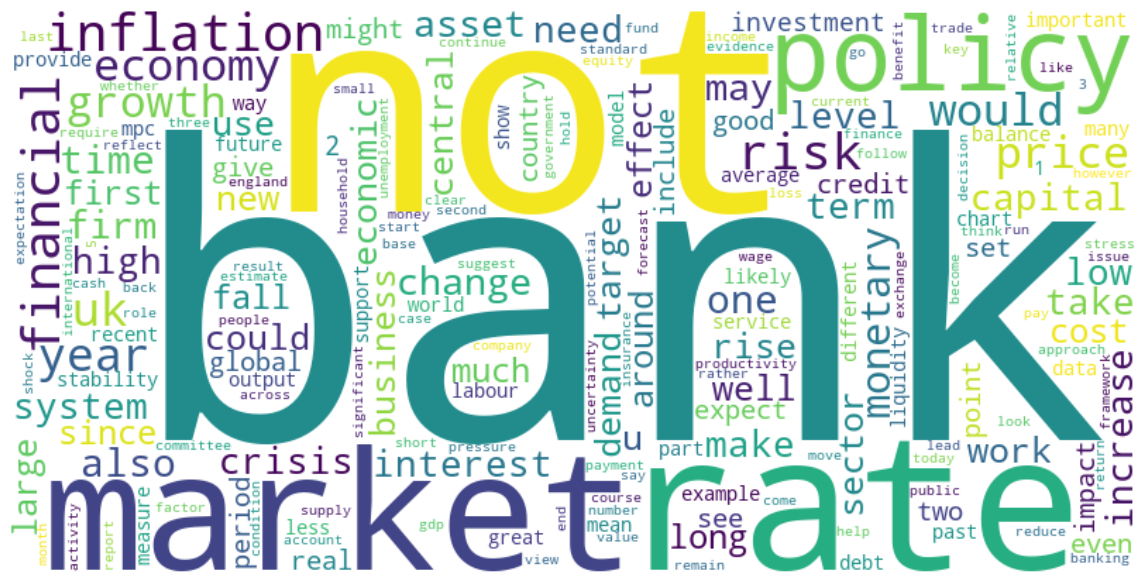

In [91]:
# Create wordcloud of lemmatised text
plot_top_non_stopwords_wordcloud(boe_speeches['text_lemmatised_str'])

In [92]:
# Define bar chart for top words
def top_words_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    # Set plot size
    plt.figure(figsize=(12, 8))
    
    # Plot
    sns.barplot(x=y, y=x)
    
    # Set label font sizes
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.title('Top Non-Stopword Words', fontsize=16)
    plt.tight_layout()
    plt.show()

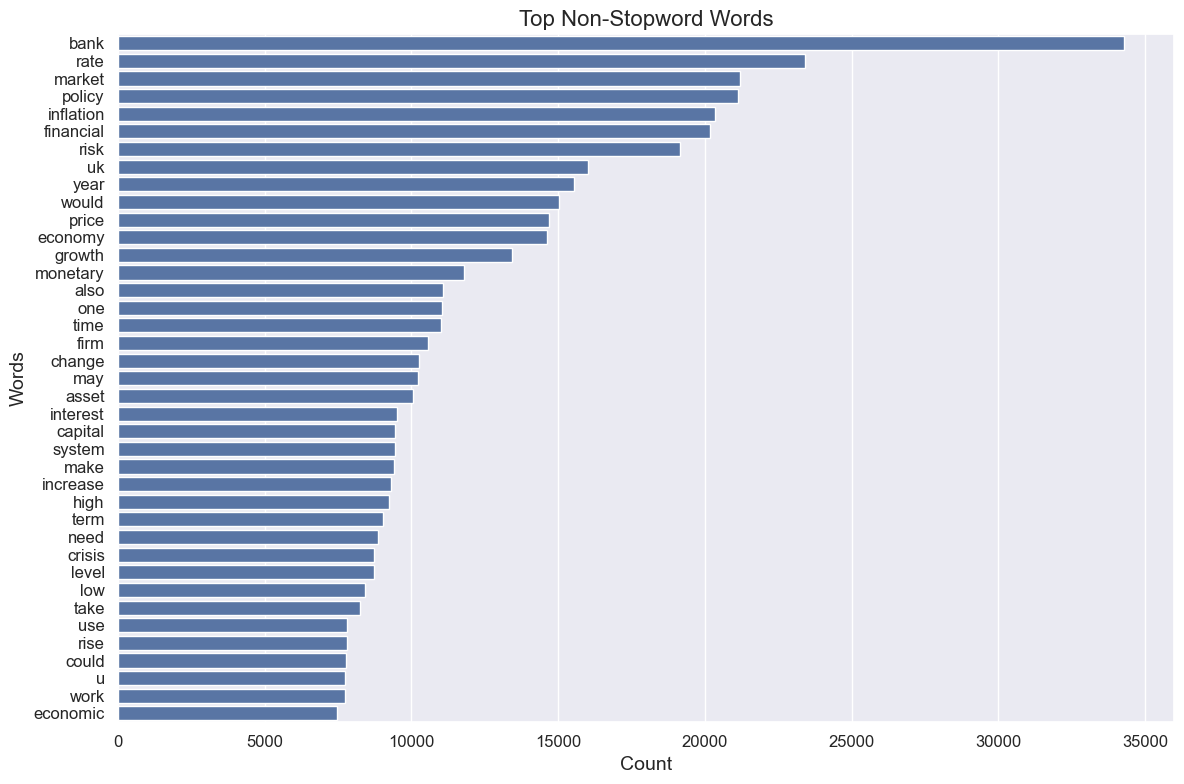

In [93]:
# Create bar chart to show top words
top_words_barchart(boe_speeches['text_lemmatised_str'])

In [94]:
# Define bar chart for top word groups
def top_word_group_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

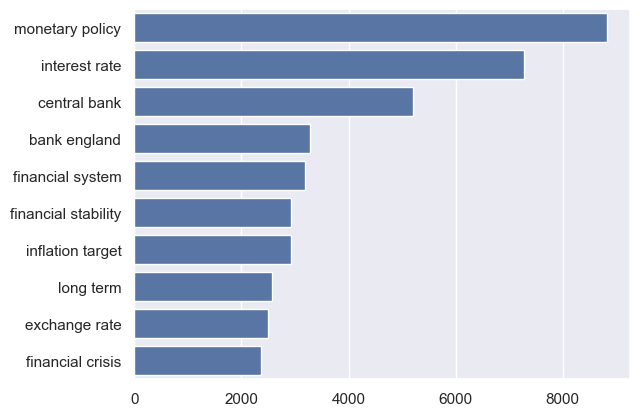

In [95]:
# Plot top phrases with 2 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],2)

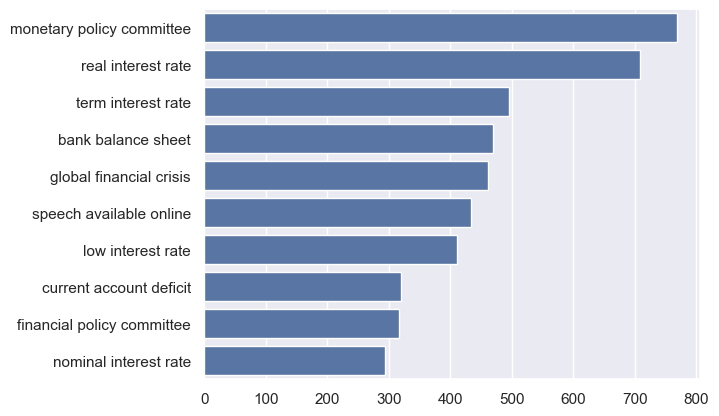

In [96]:
# Plot top phrases with 3 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],3)

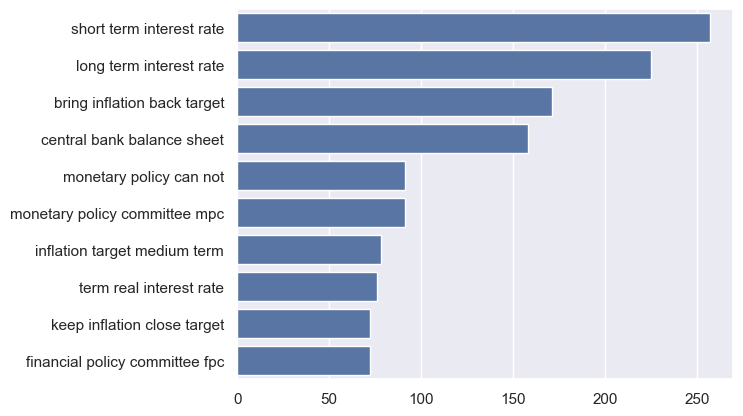

In [97]:
# Plot top phrases with 4 words
top_word_group_barchart(boe_speeches['text_lemmatised_str'],4)

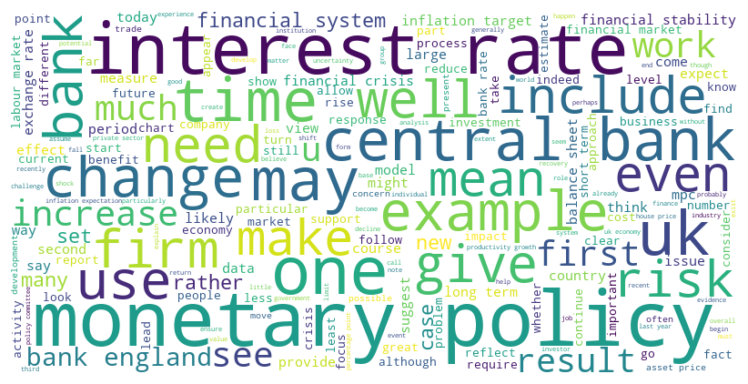

In [98]:
# Convert tokens into a single string.
boe_speeches_text = ' '.join(boe_speeches['text_lemmatised_str'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=42).generate(boe_speeches_text)

# Display the word cloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')

# Hide the axis.
plt.axis('off') 

# Dispaly the word cloud.
plt.tight_layout()
plt.show()

### Sentiment Analysis using VADER Sentiment Intensity Analyzer 

In [240]:
# Apply sentiment analysis to the columns using the lemmatised data converted into strings.
boe_speeches['sentiment_score_vader'] = boe_speeches['text_lemmatised'].apply(analyse_sentiment)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... lexicon_label_percentile  \
4961    1998-09  1998  ...                  Neutral   
4962    1998-10  1998  ...                 Positive   
4963    1998-10  1998  ...                  Neutral   
4964    1998-11  1998  ...                  Neutral   
4965    1998-11  1998  ...                  Neutral   

                                  yiyang_probs yiyang_neutral yiyang_positive  \
4961     [0.4900095, 0.5094528, 0.00053772976]       0.490009        0.509453   
4962    [0.969261, 0.030696781, 4.2198746e-05]       0.969261        0.030697   
4963      [0.37933072, 0.021060491, 0.5996088]       0.379331        0.021060   
4964     [0.9847193, 0.0149205, 0.00036025542]       0.984719        0.014921   
4965  [0.9990752, 0.0009056315, 1.9160354e-05]       0.999075        0.000906   

     yiyang_negative  yiyang_label  yiyang_confidence  sentiment_score_yiyang  \
4961        0.000538      Positive           0.509453                0.508915   
4962        0.000042       Neutral           0.969261                0.030655   
4963        0.599609      Negative           0.599609               -0.578548   
4964        0.000360       Neutral           0.984719                0.014560   
4965        0.000019       Neutral           0.999075                0.000886   

      sentiment_score_yiyang_std  \
4961                    1.291954   
4962                   -0.260091   
4963                   -2.237069   
4964                   -0.312321   
4965                   -0.356694   

                                  sentiment_score_vader  
4961  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...  
4962  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...  
4963  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...  
4964  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...  
4965  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...  

[5 rows x 41 columns]

In [245]:
# Extract individual sentiment scores for speeches.
boe_speeches['text_neg'] = boe_speeches['sentiment_score_vader'].apply(lambda x: x['neg'])
boe_speeches['text_neu'] = boe_speeches['sentiment_score_vader'].apply(lambda x: x['neu'])
boe_speeches['text_pos'] = boe_speeches['sentiment_score_vader'].apply(lambda x: x['pos'])
boe_speeches['text_compound'] = boe_speeches['sentiment_score_vader'].apply(lambda x: x['compound'])

In [247]:
# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... yiyang_negative yiyang_label yiyang_confidence  \
4961    1998-09  1998  ...        0.000538     Positive          0.509453   
4962    1998-10  1998  ...        0.000042      Neutral          0.969261   
4963    1998-10  1998  ...        0.599609     Negative          0.599609   
4964    1998-11  1998  ...        0.000360      Neutral          0.984719   
4965    1998-11  1998  ...        0.000019      Neutral          0.999075   

     sentiment_score_yiyang sentiment_score_yiyang_std  \
4961               0.508915                   1.291954   
4962               0.030655                  -0.260091   
4963              -0.578548                  -2.237069   
4964               0.014560                  -0.312321   
4965               0.000886                  -0.356694   

                                  sentiment_score_vader  text_neg  text_neu  \
4961  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...     0.143     0.700   
4962  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...     0.094     0.684   
4963  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...     0.106     0.732   
4964  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...     0.078     0.784   
4965  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...     0.093     0.783   

      text_pos  text_compound  
4961     0.157         0.9898  
4962     0.222         0.9998  
4963     0.161         0.9969  
4964     0.139         0.9993  
4965     0.124         0.9984  

[5 rows x 45 columns]

In [249]:
# Categories VADER sentiment according to compound_score
def vader_sentiment(compound_score):
    if compound_score >= 0.05:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply the sentiment labels to speeches
boe_speeches['vader_sentiment_score'] = boe_speeches['text_compound'].apply(vader_sentiment)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... yiyang_label yiyang_confidence  \
4961    1998-09  1998  ...     Positive          0.509453   
4962    1998-10  1998  ...      Neutral          0.969261   
4963    1998-10  1998  ...     Negative          0.599609   
4964    1998-11  1998  ...      Neutral          0.984719   
4965    1998-11  1998  ...      Neutral          0.999075   

     sentiment_score_yiyang sentiment_score_yiyang_std  \
4961               0.508915                   1.291954   
4962               0.030655                  -0.260091   
4963              -0.578548                  -2.237069   
4964               0.014560                  -0.312321   
4965               0.000886                  -0.356694   

                                  sentiment_score_vader  text_neg  text_neu  \
4961  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...     0.143     0.700   
4962  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...     0.094     0.684   
4963  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...     0.106     0.732   
4964  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...     0.078     0.784   
4965  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...     0.093     0.783   

      text_pos  text_compound  vader_sentiment_score  
4961     0.157         0.9898               Positive  
4962     0.222         0.9998               Positive  
4963     0.161         0.9969               Positive  
4964     0.139         0.9993               Positive  
4965     0.124         0.9984               Positive  

[5 rows x 46 columns]

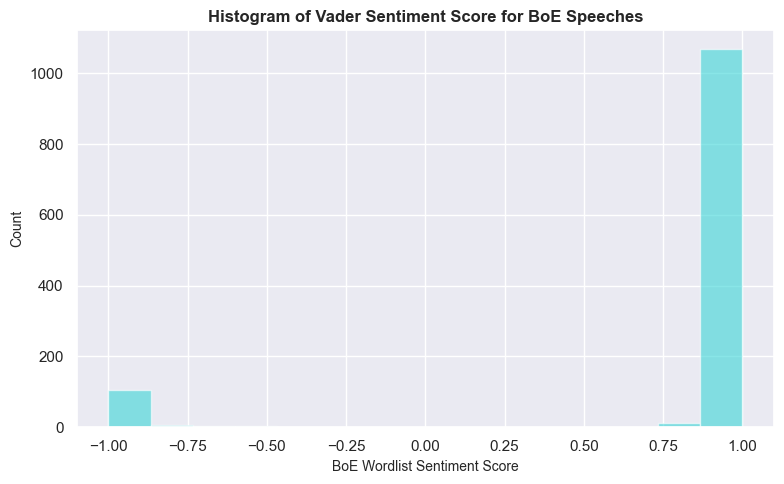

In [253]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['text_compound'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Vader Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [255]:
# Standardise the sentiment score
# Calculate mean and standard deviation
mean_score_vader = boe_speeches['text_compound'].mean()
std_score_vader = boe_speeches['text_compound'].std()

# Create a new column for standardized scores
boe_speeches['sentiment_score_vader_std'] = (boe_speeches['text_compound'] - mean_score_vader) / std_score_vader

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... yiyang_confidence sentiment_score_yiyang  \
4961    1998-09  1998  ...          0.509453               0.508915   
4962    1998-10  1998  ...          0.969261               0.030655   
4963    1998-10  1998  ...          0.599609              -0.578548   
4964    1998-11  1998  ...          0.984719               0.014560   
4965    1998-11  1998  ...          0.999075               0.000886   

     sentiment_score_yiyang_std  \
4961                   1.291954   
4962                  -0.260091   
4963                  -2.237069   
4964                  -0.312321   
4965                  -0.356694   

                                  sentiment_score_vader text_neg  text_neu  \
4961  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...    0.143     0.700   
4962  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...    0.094     0.684   
4963  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...    0.106     0.732   
4964  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...    0.078     0.784   
4965  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...    0.093     0.783   

      text_pos  text_compound  vader_sentiment_score  \
4961     0.157         0.9898               Positive   
4962     0.222         0.9998               Positive   
4963     0.161         0.9969               Positive   
4964     0.139         0.9993               Positive   
4965     0.124         0.9984               Positive   

      sentiment_score_vader_std  
4961                   0.330402  
4962                   0.347535  
4963                   0.342567  
4964                   0.346678  
4965                   0.345137  

[5 rows x 47 columns]

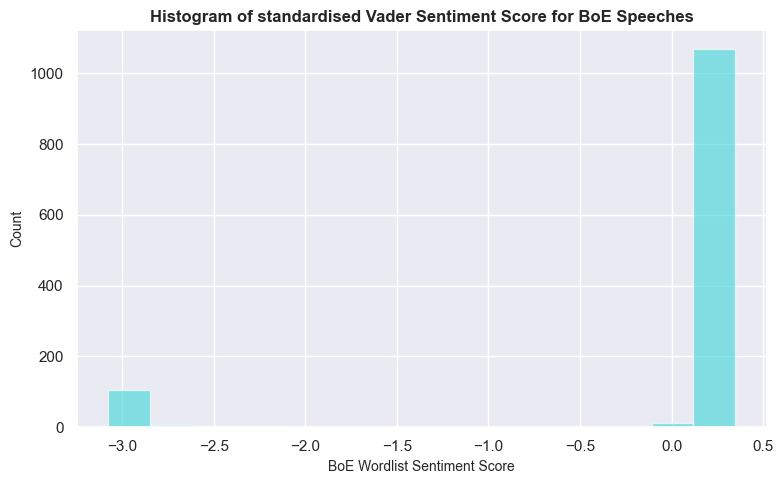

In [257]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_vader_std'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of standardised Vader Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

### 3.2. Sentiment Analysis with BoE Sentiment Wordlist for BoE speeches

In [101]:
# Prepare the lexicon
sentiment_lexicon = sentiment_lexicon.copy()

# Define categories
categories = [
     'Negative',
     'Positive',
     'Uncertainty',
     'Litigious',
     'Strong',
     'Weak',
     'Constraining',
 ]

# Create dictionary of categories, containing words that belong to that category based on your sentiment lexicon.
word_sets = {
    cat: set(sentiment_lexicon.loc[sentiment_lexicon[cat] == 1, 'Word'].str.lower())
    for cat in categories
}

In [102]:
# Define function to apply the lexicon to the text
def lexicon_counts(tokens):
    return pd.Series({
        cat: sum(t in word_sets[cat] for t in tokens)
        for cat in categories
    })

# Compute counts and add new columns for each category
boe_speeches = pd.concat(
    [boe_speeches, boe_speeches['text_lemmatised'].apply(lexicon_counts)], axis=1
 )

boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                    text_lemmatised  \
4961    1998-09  1998  ...  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  ...  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  ...  [industry, suffer, volatility, british, econom...   
4964    1998-11  1998  ...  [topic, evening, use, forecast, economic, poli...   
4965    1998-11  1998  ...  [six, year, ago, week, sterling, leave, exchan...   

                                    text_lemmatised_str word_count Negative  \
4961  thank chairman actually pleased opportunity re...       1162       62   
4962  great pleasure beautiful city bruges honour op...       2108       80   
4963  industry suffer volatility british economy pas...       1240       63   
4964  topic evening use forecast economic policy mak...       2380       79   
4965  six year ago week sterling leave exchange rate...       2580      102   

     Positive  Uncertainty  Litigious  Strong  Weak  Constraining  
4961       39           24          3      14    16             2  
4962       88           51          6      10    28            17  
4963       32           49          2       3    15             6  
4964       42           91         12      14    42            15  
4965       46          113         22      13    48            12  

[5 rows x 23 columns]

In [103]:
# Initialise a dictionary to store word counts per category
word_counts_in_category = {cat: {} for cat in categories}

# Loop through each tokenised text
for tokens in boe_speeches['text_lemmatised']:
    tokens_lower = [t.lower() for t in tokens]
    for cat in categories:
        category_words = word_sets[cat]
        for t in tokens_lower:
            if t in category_words:
                # Count occurrences
                word_counts_in_category[cat][t] = word_counts_in_category[cat].get(t, 0) + 1

# Create a new DataFrame
records = []

for cat in categories:
    for word, count in word_counts_in_category[cat].items():
        records.append({'Word': word, 'Category': cat, 'Count': count})

words_df = pd.DataFrame(records)

# Sort alphabetically or by count
words_df = words_df.sort_values(['Category', 'Word'])

# Display the DataFrame
words_df

Word      Category  Count
2072        abide  Constraining     20
2035        bound  Constraining    580
2138      bounded  Constraining      4
2020       commit  Constraining    444
2017   commitment  Constraining    706
...           ...           ...    ...
2001     somewhat          Weak    942
1998      suggest          Weak   4079
2005     suggests          Weak    222
1996    uncertain          Weak    654
2011  uncertainly          Weak      1

[2141 rows x 3 columns]

In [104]:
# Export the wordlist to Excel
words_df.to_excel('found_words_counts.xlsx', index=False)

print("DataFrame was exported successfully.")

DataFrame was exported successfully.


In [105]:
# Filter the data for governor speeches only
boe_speeches_gov = boe_speeches[boe_speeches['is_gov'] == 1]

# View the DataFrame
boe_speeches_gov.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4966  r981119a_BOE  united kingdom 1998-11-19   
4969  r990112a_BOE  united kingdom 1999-01-12   

                                                  title  author  is_gov  \
4961                                             Speech  george       1   
4962                                  Britain in Europe  george       1   
4963  Impact of the recent turbulence in internation...    king       1   
4966                                             Speech  george       1   
4969                                             Speech  george       1   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4966  Let me put some of the recent newspaper headli...  1998-11-19   
4969  I am only too well aware of the pressure curre...  1999-01-12   

     year_month  year  ...                                    text_lemmatised  \
4961    1998-09  1998  ...  [thank, chairman, actually, pleased, opportuni...   
4962    1998-10  1998  ...  [great, pleasure, beautiful, city, bruges, hon...   
4963    1998-10  1998  ...  [industry, suffer, volatility, british, econom...   
4966    1998-11  1998  ...  [let, put, recent, newspaper, headline, alongs...   
4969    1999-01  1999  ...  [well, aware, pressure, currently, face, large...   

                                    text_lemmatised_str word_count Negative  \
4961  thank chairman actually pleased opportunity re...       1162       62   
4962  great pleasure beautiful city bruges honour op...       2108       80   
4963  industry suffer volatility british economy pas...       1240       63   
4966  let put recent newspaper headline alongside fa...       1174       70   
4969  well aware pressure currently face large part ...       1304       80   

     Positive  Uncertainty  Litigious  Strong  Weak  Constraining  
4961       39           24          3      14    16             2  
4962       88           51          6      10    28            17  
4963       32           49          2       3    15             6  
4966       40           27          1       7    14             3  
4969       42           40          6       4    20             3  

[5 rows x 23 columns]

In [106]:
# Initialise a dictionary to store word counts per category for governor speeches only
word_counts_in_category = {cat: {} for cat in categories}

# Loop through each tokenized text
for tokens in boe_speeches_gov['text_lemmatised']:
    tokens_lower = [t.lower() for t in tokens]
    for cat in categories:
        category_words = word_sets[cat]
        for t in tokens_lower:
            if t in category_words:
                # Count occurrences
                word_counts_in_category[cat][t] = word_counts_in_category[cat].get(t, 0) + 1

# Create a DataFrame from this data
records_gov = []

for cat in categories:
    for word, count in word_counts_in_category[cat].items():
        records_gov.append({'Word': word, 'Category': cat, 'Count': count})

words_df_gov = pd.DataFrame(records)

# Optional: sort alphabetically or by count
words_df_gov = words_df_gov.sort_values(['Category', 'Word'])

# Display the DataFrame
words_df_gov

Word      Category  Count
2072        abide  Constraining     20
2035        bound  Constraining    580
2138      bounded  Constraining      4
2020       commit  Constraining    444
2017   commitment  Constraining    706
...           ...           ...    ...
2001     somewhat          Weak    942
1998      suggest          Weak   4079
2005     suggests          Weak    222
1996    uncertain          Weak    654
2011  uncertainly          Weak      1

[2141 rows x 3 columns]

In [107]:
# Export to Excel
words_df_gov.to_excel('found_words_counts_gov.xlsx', index=False)

print("DataFrame was exported successfully.")

DataFrame was exported successfully.


**Observations**: The percentages share of negative (32%) and positive words (25%) does not change between governor and non-governor speeches.

**3.2.a. BoE Sentiment Score based on Positive & Negative Scores**

In [110]:
# Calculate the sentiment score by subtracting the negative score from the positive score and dividing by the total number of words
boe_speeches['sentiment_score_lexicon'] = (boe_speeches['Positive'] - boe_speeches['Negative'])/ boe_speeches['word_count']

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ...                                text_lemmatised_str  \
4961    1998-09  1998  ...  thank chairman actually pleased opportunity re...   
4962    1998-10  1998  ...  great pleasure beautiful city bruges honour op...   
4963    1998-10  1998  ...  industry suffer volatility british economy pas...   
4964    1998-11  1998  ...  topic evening use forecast economic policy mak...   
4965    1998-11  1998  ...  six year ago week sterling leave exchange rate...   

     word_count Negative Positive Uncertainty  Litigious  Strong  Weak  \
4961       1162       62       39          24          3      14    16   
4962       2108       80       88          51          6      10    28   
4963       1240       63       32          49          2       3    15   
4964       2380       79       42          91         12      14    42   
4965       2580      102       46         113         22      13    48   

      Constraining  sentiment_score_lexicon  
4961             2                -0.019793  
4962            17                 0.003795  
4963             6                -0.025000  
4964            15                -0.015546  
4965            12                -0.021705  

[5 rows x 24 columns]

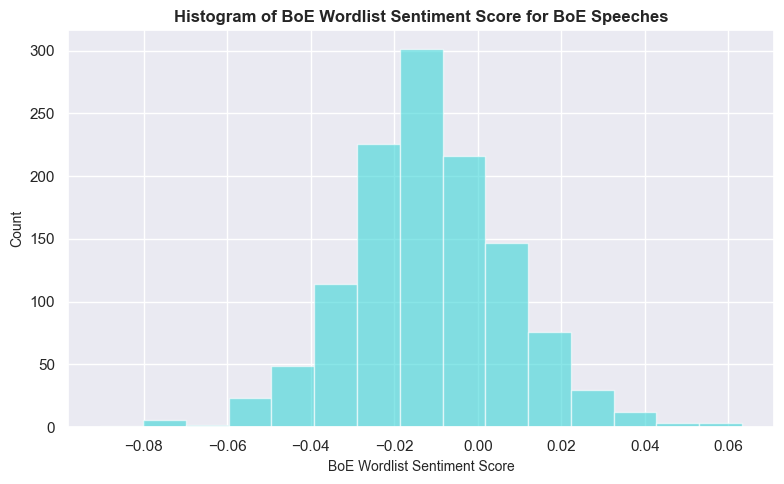

In [111]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_lexicon'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [112]:
# View distribution of sentiment scores
boe_speeches['sentiment_score_lexicon'].describe()

count    1209.000000
mean       -0.011770
std         0.019079
min        -0.090339
25%        -0.023582
50%        -0.012294
75%        -0.000405
max         0.063218
Name: sentiment_score_lexicon, dtype: float64

In [113]:
# Standardise the sentiment score
# Calculate mean and standard deviation
mean_score = boe_speeches['sentiment_score_lexicon'].mean()
std_score = boe_speeches['sentiment_score_lexicon'].std()

# Create a new column for standardized scores
boe_speeches['sentiment_score_lexicon_std'] = (boe_speeches['sentiment_score_lexicon'] - mean_score) / std_score

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... word_count Negative Positive Uncertainty Litigious  \
4961    1998-09  1998  ...       1162       62       39          24         3   
4962    1998-10  1998  ...       2108       80       88          51         6   
4963    1998-10  1998  ...       1240       63       32          49         2   
4964    1998-11  1998  ...       2380       79       42          91        12   
4965    1998-11  1998  ...       2580      102       46         113        22   

      Strong  Weak  Constraining  sentiment_score_lexicon  \
4961      14    16             2                -0.019793   
4962      10    28            17                 0.003795   
4963       3    15             6                -0.025000   
4964      14    42            15                -0.015546   
4965      13    48            12                -0.021705   

      sentiment_score_lexicon_std  
4961                    -0.420532  
4962                     0.815821  
4963                    -0.693424  
4964                    -0.197920  
4965                    -0.520744  

[5 rows x 25 columns]

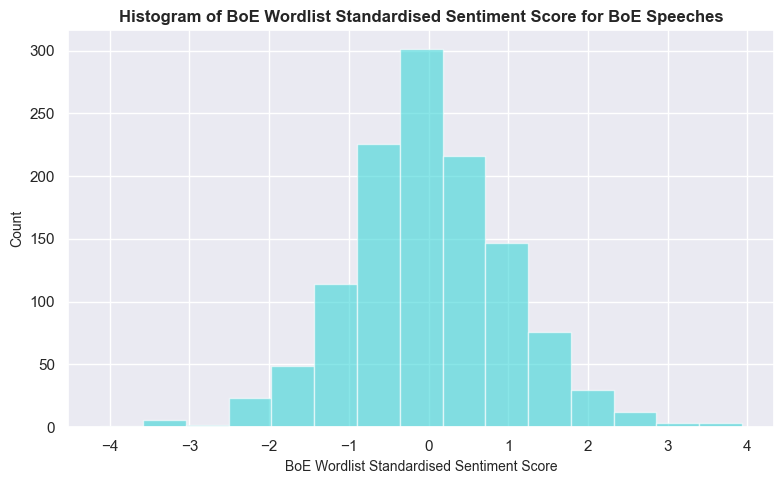

In [114]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_lexicon_std'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Standardised Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Standardised Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [115]:
# View distribution of sentiment scores
boe_speeches['sentiment_score_lexicon_std'].describe()

count    1.209000e+03
mean     9.403378e-17
std      1.000000e+00
min     -4.118045e+00
25%     -6.190852e-01
50%     -2.745708e-02
75%      5.956975e-01
max      3.930394e+00
Name: sentiment_score_lexicon_std, dtype: float64

**3.2.b. BoE Sentiment Score based on all Categories**

In [117]:
# Assign weights to the categories
category_weights = {
    'Negative': -1,
    'Positive': 1.5,
    'Uncertainty': 0.2,
    'Litigious': -0.2,
    'Strong': 1.5,
    'Weak': 0.5,
    'Constraining': -0.5
}

In [118]:
# Define function to apply the lexicon to the text
def lexicon_score_weighted(tokens):
    score = 0
    for cat in categories:
        count = sum(t in word_sets[cat] for t in tokens)
        score += count * category_weights[cat]
    return score

# Compute counts and store as a new column
boe_speeches['sentiment_score_lexicon_weighted'] = boe_speeches['text_lemmatised'].apply(lexicon_score_weighted) \
                                                    / boe_speeches['word_count']

# View the DataFrame
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... Negative Positive Uncertainty Litigious Strong  \
4961    1998-09  1998  ...       62       39          24         3     14   
4962    1998-10  1998  ...       80       88          51         6     10   
4963    1998-10  1998  ...       63       32          49         2      3   
4964    1998-11  1998  ...       79       42          91        12     14   
4965    1998-11  1998  ...      102       46         113        22     13   

      Weak  Constraining  sentiment_score_lexicon  \
4961    16             2                -0.019793   
4962    28            17                 0.003795   
4963    15             6                -0.025000   
4964    42            15                -0.015546   
4965    48            12                -0.021705   

      sentiment_score_lexicon_std  sentiment_score_lexicon_weighted  
4961                    -0.420532                          0.024699  
4962                     0.815821                          0.038662  
4963                    -0.693424                          0.002742  
4964                    -0.197920                          0.014412  
4965                    -0.520744                          0.008798  

[5 rows x 26 columns]

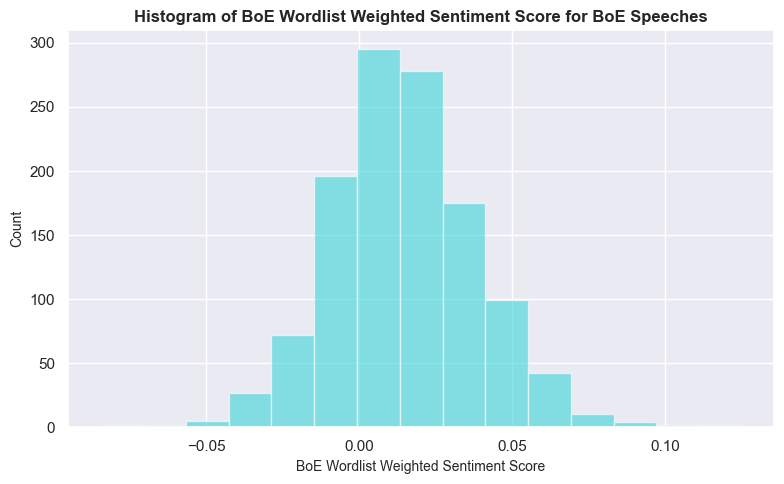

In [119]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_lexicon_weighted'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Weighted Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Weighted Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [120]:
# View distribution of sentiment scores
boe_speeches['sentiment_score_lexicon_weighted'].describe()

count    1209.000000
mean        0.014629
std         0.023584
min        -0.084567
25%        -0.000746
50%         0.013462
75%         0.029257
max         0.125037
Name: sentiment_score_lexicon_weighted, dtype: float64

In [121]:
# Standardise the sentiment score
# Calculate mean and standard deviation
mean_score_weighted = boe_speeches['sentiment_score_lexicon_weighted'].mean()
std_score_weighted = boe_speeches['sentiment_score_lexicon_weighted'].std()

# Create a new column for standardized scores
boe_speeches['sentiment_score_lexicon_weighted_std'] = (boe_speeches['sentiment_score_lexicon_weighted'] - mean_score_weighted) / std_score_weighted

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... Positive Uncertainty Litigious Strong Weak  \
4961    1998-09  1998  ...       39          24         3     14   16   
4962    1998-10  1998  ...       88          51         6     10   28   
4963    1998-10  1998  ...       32          49         2      3   15   
4964    1998-11  1998  ...       42          91        12     14   42   
4965    1998-11  1998  ...       46         113        22     13   48   

      Constraining  sentiment_score_lexicon  sentiment_score_lexicon_std  \
4961             2                -0.019793                    -0.420532   
4962            17                 0.003795                     0.815821   
4963             6                -0.025000                    -0.693424   
4964            15                -0.015546                    -0.197920   
4965            12                -0.021705                    -0.520744   

      sentiment_score_lexicon_weighted  sentiment_score_lexicon_weighted_std  
4961                          0.024699                              0.426960  
4962                          0.038662                              1.019040  
4963                          0.002742                             -0.504057  
4964                          0.014412                             -0.009231  
4965                          0.008798                             -0.247248  

[5 rows x 27 columns]

In [122]:
# View distribution of sentiment scores
boe_speeches['sentiment_score_lexicon_weighted_std'].describe()

count    1.209000e+03
mean     6.170967e-17
std      1.000000e+00
min     -4.206145e+00
25%     -6.519472e-01
50%     -4.952307e-02
75%      6.202511e-01
max      4.681532e+00
Name: sentiment_score_lexicon_weighted_std, dtype: float64

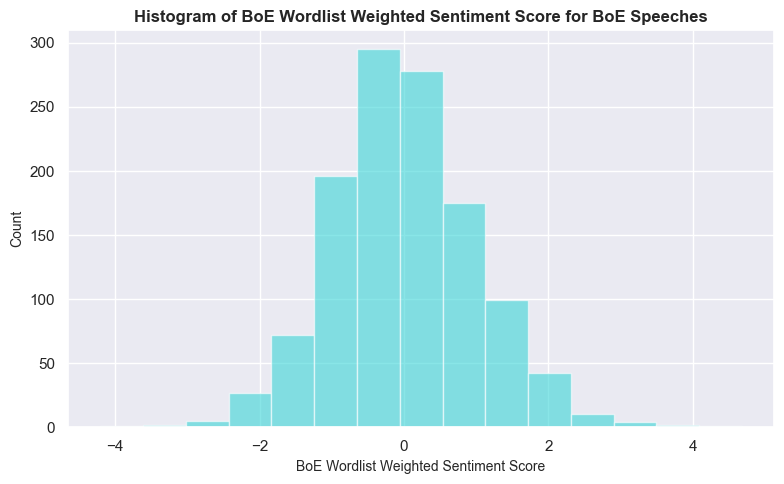

In [123]:
# Plot a histogram of the vader sentiment score for summary
# Set the number of bins.
num_bins = 15
# Set the plot area.
plt.figure(figsize=(8,5))

# Define the bars.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_lexicon_weighted_std'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('BoE Wordlist Weighted Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of BoE Wordlist Weighted Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

**3.2.c. BoE Sentiment Score Labelling**

In [125]:
# Categories sentiment according to sentiment score
def categorise_sentiment(sentiment_score, pos_threshold=1, neg_threshold=-1):
    if sentiment_score >= pos_threshold:
        return 'Positive'
    elif sentiment_score <= neg_threshold:
        return 'Negative'
    else:
        return 'Neutral'

In [126]:
# Apply the sentiment labels to speeches
boe_speeches['lexicon_label'] = boe_speeches['sentiment_score_lexicon_std'].apply(categorise_sentiment)
boe_speeches['lexicon_label_2'] = boe_speeches['sentiment_score_lexicon_std'].apply(categorise_sentiment, pos_threshold=0.5, neg_threshold=-0.5)
boe_speeches['lexicon_label_weighted'] = boe_speeches['sentiment_score_lexicon_weighted_std'].apply(categorise_sentiment)
boe_speeches['lexicon_label_weighted_2'] = boe_speeches['sentiment_score_lexicon_weighted_std'].apply(categorise_sentiment, pos_threshold=0.5, neg_threshold=-0.5)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... Weak Constraining sentiment_score_lexicon  \
4961    1998-09  1998  ...   16            2               -0.019793   
4962    1998-10  1998  ...   28           17                0.003795   
4963    1998-10  1998  ...   15            6               -0.025000   
4964    1998-11  1998  ...   42           15               -0.015546   
4965    1998-11  1998  ...   48           12               -0.021705   

     sentiment_score_lexicon_std sentiment_score_lexicon_weighted  \
4961                   -0.420532                         0.024699   
4962                    0.815821                         0.038662   
4963                   -0.693424                         0.002742   
4964                   -0.197920                         0.014412   
4965                   -0.520744                         0.008798   

      sentiment_score_lexicon_weighted_std  lexicon_label  lexicon_label_2  \
4961                              0.426960        Neutral          Neutral   
4962                              1.019040        Neutral         Positive   
4963                             -0.504057        Neutral         Negative   
4964                             -0.009231        Neutral          Neutral   
4965                             -0.247248        Neutral         Negative   

      lexicon_label_weighted  lexicon_label_weighted_2  
4961                 Neutral                   Neutral  
4962                Positive                  Positive  
4963                 Neutral                  Negative  
4964                 Neutral                   Neutral  
4965                 Neutral                   Neutral  

[5 rows x 31 columns]

In [127]:
# Categories sentiment according to percentile thresholds
lower_thresh = boe_speeches['sentiment_score_lexicon_std'].quantile(0.20)
upper_thresh = boe_speeches['sentiment_score_lexicon_std'].quantile(0.80)

def classify_score(z):
    if z >= upper_thresh:
        return 'Positive'
    elif z <= lower_thresh:
        return 'Negative'
    else:
        return 'Neutral'

In [128]:
# Apply the sentiment labels to speeches
boe_speeches['lexicon_label_percentile'] = boe_speeches['sentiment_score_lexicon_std'].apply(classify_score)

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... Constraining sentiment_score_lexicon  \
4961    1998-09  1998  ...            2               -0.019793   
4962    1998-10  1998  ...           17                0.003795   
4963    1998-10  1998  ...            6               -0.025000   
4964    1998-11  1998  ...           15               -0.015546   
4965    1998-11  1998  ...           12               -0.021705   

     sentiment_score_lexicon_std sentiment_score_lexicon_weighted  \
4961                   -0.420532                         0.024699   
4962                    0.815821                         0.038662   
4963                   -0.693424                         0.002742   
4964                   -0.197920                         0.014412   
4965                   -0.520744                         0.008798   

     sentiment_score_lexicon_weighted_std  lexicon_label  lexicon_label_2  \
4961                             0.426960        Neutral          Neutral   
4962                             1.019040        Neutral         Positive   
4963                            -0.504057        Neutral         Negative   
4964                            -0.009231        Neutral          Neutral   
4965                            -0.247248        Neutral         Negative   

      lexicon_label_weighted  lexicon_label_weighted_2  \
4961                 Neutral                   Neutral   
4962                Positive                  Positive   
4963                 Neutral                  Negative   
4964                 Neutral                   Neutral   
4965                 Neutral                   Neutral   

      lexicon_label_percentile  
4961                   Neutral  
4962                  Positive  
4963                   Neutral  
4964                   Neutral  
4965                   Neutral  

[5 rows x 32 columns]

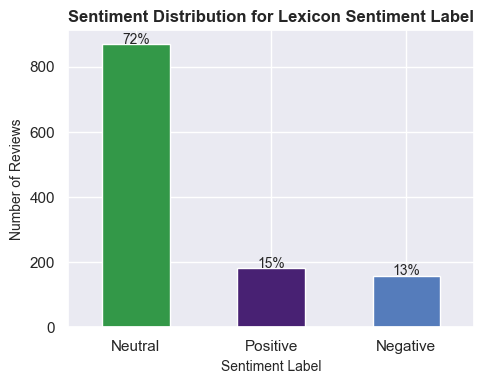

In [129]:
# Plot the sentiments distribution for lexicon label
sentiment_labels_lexicon = boe_speeches['lexicon_label']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_lexicon.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Lexicon Sentiment Label', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

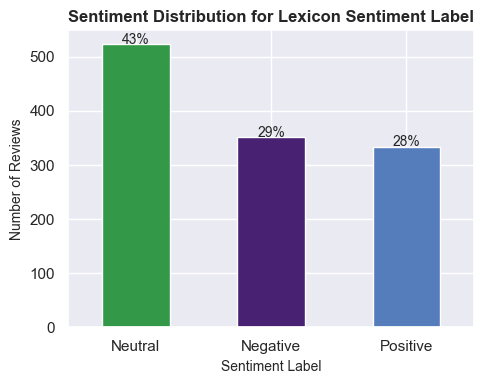

In [130]:
# Plot the sentiments distribution for lexicon label
sentiment_labels_lexicon = boe_speeches['lexicon_label_2']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_lexicon.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Lexicon Sentiment Label', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

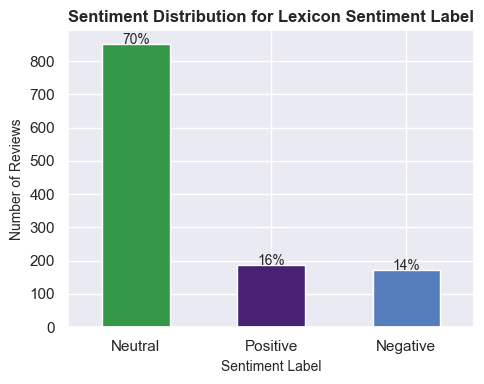

In [131]:
# Plot the sentiments distribution for lexicon label
sentiment_labels_lexicon = boe_speeches['lexicon_label_weighted']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_lexicon.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Lexicon Sentiment Label', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

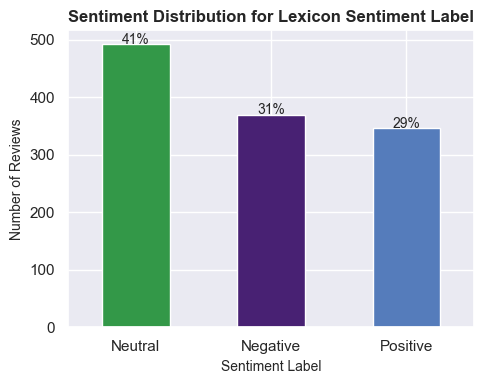

In [132]:
# Plot the sentiments distribution for lexicon label
sentiment_labels_lexicon = boe_speeches['lexicon_label_weighted_2']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_lexicon.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Lexicon Sentiment Label', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

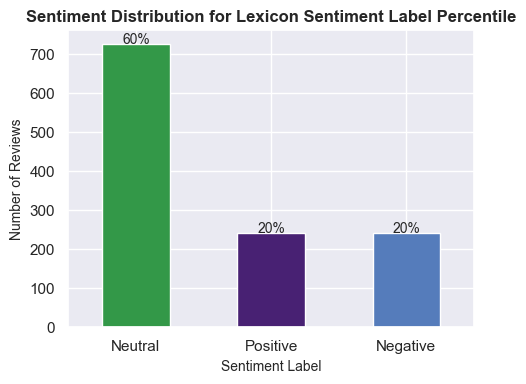

In [133]:
# Plot the sentiments distribution for lexicon percentile
sentiment_labels_lexicon_percentile = boe_speeches['lexicon_label_percentile']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_lexicon_percentile.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Lexicon Sentiment Label Percentile', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

### 3.3. Sentiment Analysis with GPT Sentiment

In [135]:
# View the DataFrame
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  gpt_sentiment  
0      Positive  
1      Positive  
2       Neutral  
3       Neutral  
4      Positive

In [136]:
# Define the mapping dictionary
sentiment_mapping = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

# Apply the mapping to the sentiment column
gpt_sentiment['gpt_sentiment_numeric'] = gpt_sentiment['gpt_sentiment'].map(sentiment_mapping)

# View the DataFrame
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  gpt_sentiment  gpt_sentiment_numeric  
0      Positive                      1  
1      Positive                      1  
2       Neutral                      0  
3       Neutral                      0  
4      Positive                      1

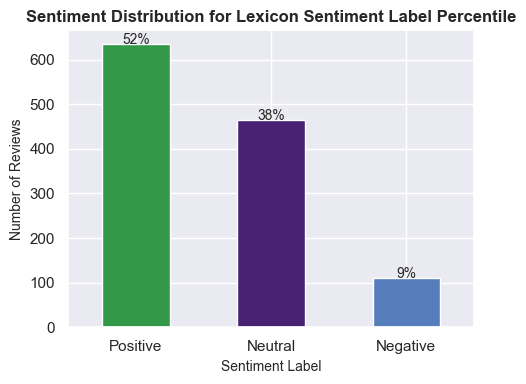

In [137]:
# Plot the sentiments distribution for lexicon percentile
sentiment_labels_gpt = gpt_sentiment['gpt_sentiment']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_gpt.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Lexicon Sentiment Label Percentile', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Reviews', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

In [138]:
# Standardise the sentiment score
# Calculate mean and standard deviation
mean_score_gpt = gpt_sentiment['gpt_sentiment_numeric'].mean()
std_score = gpt_sentiment['gpt_sentiment_numeric'].std()

# Create a new column for standardized scores
gpt_sentiment['gpt_sentiment_std'] = (gpt_sentiment['gpt_sentiment_numeric'] - mean_score) / std_score

# View the DataFrame.
gpt_sentiment.head()

reference                                              Title  \
0  r980915a_BOE                                             Speech   
1  r981021b_BOE                                  Britain in Europe   
2  r981021a_BOE  Impact of the recent turbulence in internation...   
3  r981101a_BOE        Economic policy, with and without forecasts   
4  r981101b_BOE  Inflation targeting in practice: the UK experi...   

  gpt_sentiment  gpt_sentiment_numeric  gpt_sentiment_std  
0      Positive                      1           1.546736  
1      Positive                      1           1.546736  
2       Neutral                      0           0.017993  
3       Neutral                      0           0.017993  
4      Positive                      1           1.546736

### 3.4. Sentiment Analysis with FinBERT for BoE speeches using yiyanghkurts model

In [140]:
# Define a function to predict probabilities in batches
def predict_batch(texts, tokenizer, model, max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')  # Tokenize batch of texts
    inputs = {k: v.to(device) for k, v in inputs.items()}                 # Move inputs to the device (GPU or CPU)
    with torch.no_grad():                                                 # Get model outputs without computing gradients
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)                              # Convert logits to probabilities
    return probs.cpu().numpy()

In [141]:
# Check the order of labels in the model
model_yiyang.config.id2label

{0: 'Neutral', 1: 'Positive', 2: 'Negative'}

In [142]:
# Column that the model should be applied to
texts = boe_speeches['text_lemmatised'].astype(str).tolist()

# Specify batch size for efficiency
batch_size = 32
all_probs = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i + batch_size]
    batch_probs = predict_batch(batch_texts, tokenizer_yiyang, model_yiyang)
    all_probs.extend(batch_probs)

# Store the predicted probabilities back into your DataFrame
boe_speeches['yiyang_probs'] = all_probs

# Extract top labels using the order established above
labels = ['Neutral', 'Positive', 'Negative']

def get_probs_yiyang_dict(probs):
    # Assumes probs is an array/list like [neutral_score, positive_score, negative_score]
    return {
        'yiyang_neutral': probs[0],
        'yiyang_positive': probs[1],
        'yiyang_negative': probs[2]
    }

def get_top_label(probs):
    idx = probs.argmax()
    return labels[idx], probs.max()

In [143]:
# Create a DataFrame with all class probabilities
probs_yiyang = boe_speeches['yiyang_probs'].apply(lambda x: get_probs_yiyang_dict(x)).apply(pd.Series)

# Assign back to your main DataFrame
boe_speeches = pd.concat([boe_speeches, probs_yiyang], axis=1)

# Apply and extract label + confidence
boe_speeches[['yiyang_label', 'yiyang_confidence']] = boe_speeches['yiyang_probs'].apply(lambda x: get_top_label(x)).apply(pd.Series)

# Now, your DataFrame has the probabilities, top label, and confidence score
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... lexicon_label_2 lexicon_label_weighted  \
4961    1998-09  1998  ...         Neutral                Neutral   
4962    1998-10  1998  ...        Positive               Positive   
4963    1998-10  1998  ...        Negative                Neutral   
4964    1998-11  1998  ...         Neutral                Neutral   
4965    1998-11  1998  ...        Negative                Neutral   

     lexicon_label_weighted_2 lexicon_label_percentile  \
4961                  Neutral                  Neutral   
4962                 Positive                 Positive   
4963                 Negative                  Neutral   
4964                  Neutral                  Neutral   
4965                  Neutral                  Neutral   

                                  yiyang_probs  yiyang_neutral  \
4961     [0.4900095, 0.5094528, 0.00053772976]        0.490009   
4962    [0.969261, 0.030696781, 4.2198746e-05]        0.969261   
4963      [0.37933072, 0.021060491, 0.5996088]        0.379331   
4964     [0.9847193, 0.0149205, 0.00036025542]        0.984719   
4965  [0.9990752, 0.0009056315, 1.9160354e-05]        0.999075   

      yiyang_positive  yiyang_negative  yiyang_label  yiyang_confidence  
4961         0.509453         0.000538      Positive           0.509453  
4962         0.030697         0.000042       Neutral           0.969261  
4963         0.021060         0.599609      Negative           0.599609  
4964         0.014921         0.000360       Neutral           0.984719  
4965         0.000906         0.000019       Neutral           0.999075  

[5 rows x 38 columns]

In [144]:
# Define weights 
weights = {
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1
}

In [145]:
# Define function to calculate one sentiment score
def compute_tone_score(probs):
    class_labels = ['Neutral', 'Positive', 'Negative']
    prob_dict = dict(zip(class_labels, probs))
    return (
        prob_dict['Positive'] * weights['Positive'] +
        prob_dict['Neutral'] * weights['Neutral'] +
        prob_dict['Negative'] * weights['Negative']
    )

In [146]:
# Apply to all rows
boe_speeches['sentiment_score_yiyang'] = boe_speeches['yiyang_probs'].apply(compute_tone_score)

# View the dataframe
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... lexicon_label_weighted lexicon_label_weighted_2  \
4961    1998-09  1998  ...                Neutral                  Neutral   
4962    1998-10  1998  ...               Positive                 Positive   
4963    1998-10  1998  ...                Neutral                 Negative   
4964    1998-11  1998  ...                Neutral                  Neutral   
4965    1998-11  1998  ...                Neutral                  Neutral   

     lexicon_label_percentile                              yiyang_probs  \
4961                  Neutral     [0.4900095, 0.5094528, 0.00053772976]   
4962                 Positive    [0.969261, 0.030696781, 4.2198746e-05]   
4963                  Neutral      [0.37933072, 0.021060491, 0.5996088]   
4964                  Neutral     [0.9847193, 0.0149205, 0.00036025542]   
4965                  Neutral  [0.9990752, 0.0009056315, 1.9160354e-05]   

     yiyang_neutral  yiyang_positive  yiyang_negative  yiyang_label  \
4961       0.490009         0.509453         0.000538      Positive   
4962       0.969261         0.030697         0.000042       Neutral   
4963       0.379331         0.021060         0.599609      Negative   
4964       0.984719         0.014921         0.000360       Neutral   
4965       0.999075         0.000906         0.000019       Neutral   

      yiyang_confidence  sentiment_score_yiyang  
4961           0.509453                0.508915  
4962           0.969261                0.030655  
4963           0.599609               -0.578548  
4964           0.984719                0.014560  
4965           0.999075                0.000886  

[5 rows x 39 columns]

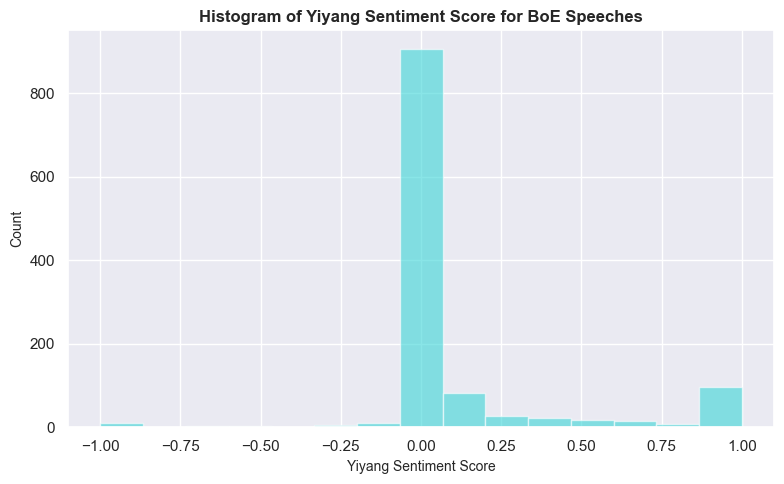

In [147]:
# Plot a histogram of the confidence score for BoE speeches
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_yiyang'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Yiyang Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Yiyang Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

In [148]:
# Standardise the sentiment score
# Calculate mean and standard deviation
mean_score_yiyang = boe_speeches['sentiment_score_yiyang'].mean()
std_score_yiyang = boe_speeches['sentiment_score_yiyang'].std()

# Create a new column for standardized scores
boe_speeches['sentiment_score_yiyang_std'] = (boe_speeches['sentiment_score_yiyang'] - mean_score_yiyang) / std_score_yiyang

# View the DataFrame.
boe_speeches.head()

reference         country       date  \
4961  r980915a_BOE  united kingdom 1998-09-15   
4962  r981021b_BOE  united kingdom 1998-10-21   
4963  r981021a_BOE  united kingdom 1998-10-21   
4964  r981101a_BOE  united kingdom 1998-11-01   
4965  r981101b_BOE  united kingdom 1998-11-01   

                                                  title   author  is_gov  \
4961                                             Speech   george       1   
4962                                  Britain in Europe   george       1   
4963  Impact of the recent turbulence in internation...     king       1   
4964        Economic policy, with and without forecasts     budd       0   
4965  Inflation targeting in practice: the UK experi...  vickers       0   

                                                   text date_format  \
4961  Thank you, Chairman. I'm actually very pleased...  1998-09-15   
4962  It's a great pleasure to be here in the beauti...  1998-10-21   
4963  Few industries have suffered more from volatil...  1998-10-21   
4964  My topic this evening is the use of forecasts ...  1998-11-01   
4965  Six years ago this week, sterling left the exc...  1998-11-01   

     year_month  year  ... lexicon_label_weighted_2 lexicon_label_percentile  \
4961    1998-09  1998  ...                  Neutral                  Neutral   
4962    1998-10  1998  ...                 Positive                 Positive   
4963    1998-10  1998  ...                 Negative                  Neutral   
4964    1998-11  1998  ...                  Neutral                  Neutral   
4965    1998-11  1998  ...                  Neutral                  Neutral   

                                  yiyang_probs yiyang_neutral yiyang_positive  \
4961     [0.4900095, 0.5094528, 0.00053772976]       0.490009        0.509453   
4962    [0.969261, 0.030696781, 4.2198746e-05]       0.969261        0.030697   
4963      [0.37933072, 0.021060491, 0.5996088]       0.379331        0.021060   
4964     [0.9847193, 0.0149205, 0.00036025542]       0.984719        0.014921   
4965  [0.9990752, 0.0009056315, 1.9160354e-05]       0.999075        0.000906   

      yiyang_negative  yiyang_label  yiyang_confidence  \
4961         0.000538      Positive           0.509453   
4962         0.000042       Neutral           0.969261   
4963         0.599609      Negative           0.599609   
4964         0.000360       Neutral           0.984719   
4965         0.000019       Neutral           0.999075   

      sentiment_score_yiyang  sentiment_score_yiyang_std  
4961                0.508915                    1.291954  
4962                0.030655                   -0.260091  
4963               -0.578548                   -2.237069  
4964                0.014560                   -0.312321  
4965                0.000886                   -0.356694  

[5 rows x 40 columns]

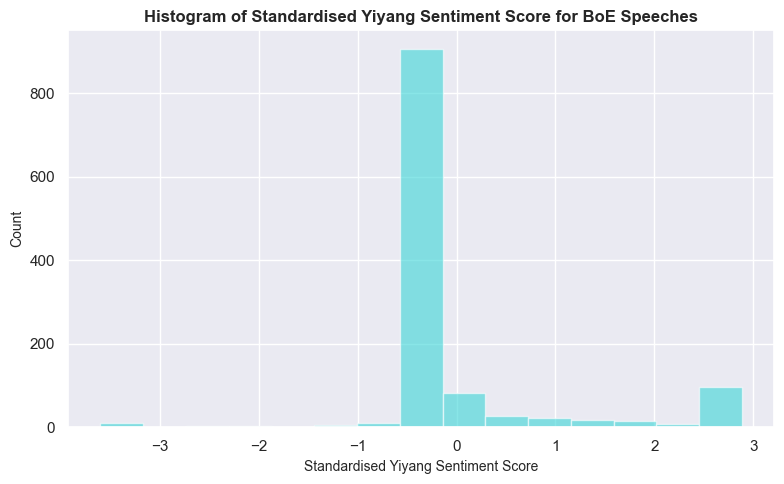

In [149]:
# Plot a histogram of the standardised sentiment score for BoE speeches
# Set the number of bins.
num_bins = 15

# Set the plot area.
plt.figure(figsize=(8,5))

# Define the plot.
n, bins, patches = plt.hist(boe_speeches['sentiment_score_yiyang_std'], num_bins, facecolor='#3bd5d7', alpha=0.6)

# Set the labels.
plt.xlabel('Standardised Yiyang Sentiment Score', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.title('Histogram of Standardised Yiyang Sentiment Score for BoE Speeches', fontsize=12, fontweight='bold')

# Display the chart.
plt.tight_layout()
plt.show()

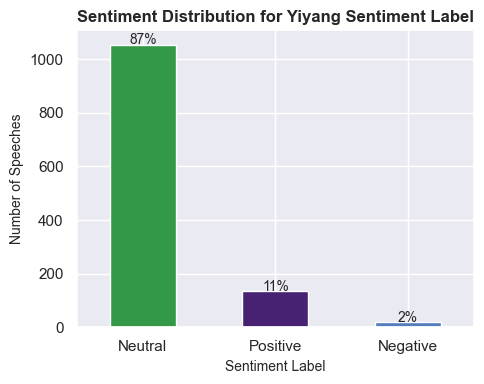

In [150]:
# Plot the sentiments distribution for yiyang
sentiment_labels_yiyang = boe_speeches['yiyang_label']

# Create a figure
plt.figure(figsize=(5, 4))

# Calculate the counts and percentages
sentiment_counts = pd.Series(sentiment_labels_yiyang.value_counts())
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100  # Calculate percentages

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['#339848', '#482173', '#557cbb'])

# Add labels.
plt.title('Sentiment Distribution for Yiyang Sentiment Label', fontsize=12, fontweight='bold')
plt.xlabel('Sentiment Label', fontsize=10)
plt.ylabel('Number of Speeches', fontsize=10)
plt.xticks(rotation=0)

# Annotate the bars with percentages
for index, value in enumerate(sentiment_counts):
    plt.text(index, value + 0.5, f'{sentiment_percentages[index]:.0f}%', ha='center', fontsize=10)

# Save the plot.
# plt.savefig('Fig_Sentiment_Reviews.png', dpi=500, bbox_inches='tight')

# Display the plot.
plt.tight_layout()
plt.show()

In [151]:
# View the weighted Sentiment scores.
boe_speeches['sentiment_score_yiyang'].describe()

count    1209.000000
mean        0.110801
std         0.308149
min        -0.998919
25%         0.000640
50%         0.004308
75%         0.043896
max         1.000000
Name: sentiment_score_yiyang, dtype: float64

### 3.5. Compare sentiment scores

Create a new dataframe with only relevant indices.

In [259]:
boe_speeches.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'date_format', 'year_month', 'year', 'year_month_dt', 'text_cleaned',
       'text_tokenised', 'text_lemmatised', 'text_lemmatised_str',
       'word_count', 'Negative', 'Positive', 'Uncertainty', 'Litigious',
       'Strong', 'Weak', 'Constraining', 'sentiment_score_lexicon',
       'sentiment_score_lexicon_std', 'sentiment_score_lexicon_weighted',
       'sentiment_score_lexicon_weighted_std', 'lexicon_label',
       'lexicon_label_2', 'lexicon_label_weighted', 'lexicon_label_weighted_2',
       'lexicon_label_percentile', 'yiyang_probs', 'yiyang_neutral',
       'yiyang_positive', 'yiyang_negative', 'yiyang_label',
       'yiyang_confidence', 'sentiment_score_yiyang',
       'sentiment_score_yiyang_std', 'sentiment_score_vader', 'text_neg',
       'text_neu', 'text_pos', 'text_compound', 'vader_sentiment_score',
       'sentiment_score_vader_std'],
      dtype='object')

In [261]:
# Merge gpt_sentiment with boe_speeches
boe_speeches_new = pd.merge(boe_speeches, gpt_sentiment[['reference', 'gpt_sentiment', 'gpt_sentiment_numeric', \
                                                         'gpt_sentiment_std']], on='reference', how='left')

# View the DataFrame
boe_speeches_new.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

   year  ...                              sentiment_score_vader text_neg  \
0  1998  ...  {'neg': 0.143, 'neu': 0.7, 'pos': 0.157, 'comp...    0.143   
1  1998  ...  {'neg': 0.094, 'neu': 0.684, 'pos': 0.222, 'co...    0.094   
2  1998  ...  {'neg': 0.106, 'neu': 0.732, 'pos': 0.161, 'co...    0.106   
3  1998  ...  {'neg': 0.078, 'neu': 0.784, 'pos': 0.139, 'co...    0.078   
4  1998  ...  {'neg': 0.093, 'neu': 0.783, 'pos': 0.124, 'co...    0.093   

  text_neu text_pos text_compound  vader_sentiment_score  \
0    0.700    0.157        0.9898               Positive   
1    0.684    0.222        0.9998               Positive   
2    0.732    0.161        0.9969               Positive   
3    0.784    0.139        0.9993               Positive   
4    0.783    0.124        0.9984               Positive   

   sentiment_score_vader_std  gpt_sentiment  gpt_sentiment_numeric  \
0                   0.330402       Positive                      1   
1                   0.347535       Positive                      1   
2                   0.342567        Neutral                      0   
3                   0.346678        Neutral                      0   
4                   0.345137       Positive                      1   

   gpt_sentiment_std  
0           1.546736  
1           1.546736  
2           0.017993  
3           0.017993  
4           1.546736  

[5 rows x 50 columns]

In [263]:
# Create a new DataFrame with all sentiment scores to include for comparison.
boe_speeches_sentiment = boe_speeches_new[['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
                                           'date_format', 'year_month', 'year_month_dt', 'year',
                                           'text_lemmatised', 'text_lemmatised_str', 'word_count',
                                           'sentiment_score_lexicon', 'sentiment_score_lexicon_std', 'sentiment_score_lexicon_weighted_std',
                                           'lexicon_label', 'lexicon_label_2', 'lexicon_label_weighted', 'lexicon_label_weighted_2', 
                                           'lexicon_label_percentile',
                                           'sentiment_score_yiyang', 'sentiment_score_yiyang_std', 'yiyang_label', 
                                           'gpt_sentiment', 'gpt_sentiment_numeric', 'gpt_sentiment_std',
                                          'text_neg', 'text_neu', 'text_pos', 'text_compound', 'vader_sentiment_score',
                                           'sentiment_score_vader_std']]

# View the DataFrame.
boe_speeches_sentiment.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

  year_month_dt  ...  yiyang_label gpt_sentiment gpt_sentiment_numeric  \
0    1998-09-01  ...      Positive      Positive                     1   
1    1998-10-01  ...       Neutral      Positive                     1   
2    1998-10-01  ...      Negative       Neutral                     0   
3    1998-11-01  ...       Neutral       Neutral                     0   
4    1998-11-01  ...       Neutral      Positive                     1   

   gpt_sentiment_std  text_neg  text_neu  text_pos text_compound  \
0           1.546736     0.143     0.700     0.157        0.9898   
1           1.546736     0.094     0.684     0.222        0.9998   
2           0.017993     0.106     0.732     0.161        0.9969   
3           0.017993     0.078     0.784     0.139        0.9993   
4           1.546736     0.093     0.783     0.124        0.9984   

  vader_sentiment_score sentiment_score_vader_std  
0              Positive                  0.330402  
1              Positive                  0.347535  
2              Positive                  0.342567  
3              Positive                  0.346678  
4              Positive                  0.345137  

[5 rows x 34 columns]

In [265]:
# Review the data
boe_speeches_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   reference                             1209 non-null   object        
 1   country                               1209 non-null   object        
 2   date                                  1209 non-null   datetime64[ns]
 3   title                                 1209 non-null   object        
 4   author                                1209 non-null   object        
 5   is_gov                                1209 non-null   int64         
 6   text                                  1209 non-null   object        
 7   date_format                           1209 non-null   datetime64[ns]
 8   year_month                            1209 non-null   period[M]     
 9   year_month_dt                         1209 non-null   datetime64[ns]
 10  

In [267]:
# Correlation between BoE Wordlist and Finbert sentiment scores
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_score_lexicon_std'], boe_speeches_sentiment['sentiment_score_yiyang_std'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.12


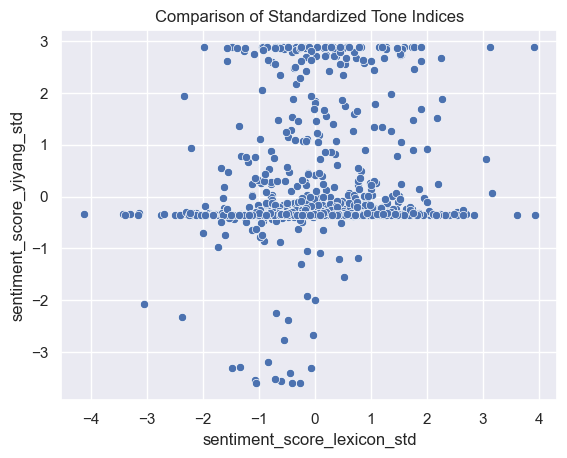

In [269]:
# Scatterplot for BoE dictionary and Finbert sentiment scores
sns.scatterplot(x='sentiment_score_lexicon_std', y='sentiment_score_yiyang_std', data=boe_speeches_sentiment)
plt.title('Comparison of Standardized Tone Indices')
plt.show()

In [160]:
# Correlation between GPT sentiment and Finbert
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['gpt_sentiment_std'], boe_speeches_sentiment['sentiment_score_yiyang_std'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.12


In [161]:
# Correlation between GPT sentiment and BoE Wordlist
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['gpt_sentiment_std'], boe_speeches_sentiment['sentiment_score_lexicon_std'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.31


In [273]:
# Correlation between GPT sentiment and BoE Wordlist
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['gpt_sentiment_std'], boe_speeches_sentiment['sentiment_score_lexicon_weighted_std'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.30


In [271]:
# Correlation between GPT sentiment and BoE Wordlist
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['gpt_sentiment_std'], boe_speeches_sentiment['sentiment_score_vader_std'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.21


In [275]:
# Correlation between GPT sentiment and BoE Wordlist
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_score_lexicon_std'], boe_speeches_sentiment['sentiment_score_vader_std'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.42


In [289]:
# Correlation between GPT sentiment and BoE Wordlist
from scipy.stats import pearsonr
corr, p_value = pearsonr(boe_speeches_sentiment['sentiment_score_lexicon_weighted_std'], boe_speeches_sentiment['sentiment_score_vader_std'])
print(f'Correlation: {corr:.2f}')

Correlation: 0.39


In [163]:
# Export the DataFrame to an Excel file
# boe_speeches_sentiment.to_excel('boe_speeches_sentiment.xlsx', index=False)

# print("DataFrame was exported successfully.")

In [164]:
# Create a new column for agreement (1 for agree, 0 for disagree)
boe_speeches_sentiment['agreement_lexicon_yiyang'] = (boe_speeches_sentiment['lexicon_label'] == boe_speeches_sentiment['yiyang_label']).astype(int)

boe_speeches_sentiment.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

  year_month_dt  ...  lexicon_label_weighted lexicon_label_weighted_2  \
0    1998-09-01  ...                 Neutral                  Neutral   
1    1998-10-01  ...                Positive                 Positive   
2    1998-10-01  ...                 Neutral                 Negative   
3    1998-11-01  ...                 Neutral                  Neutral   
4    1998-11-01  ...                 Neutral                  Neutral   

  lexicon_label_percentile  sentiment_score_yiyang  \
0                  Neutral                0.508915   
1                 Positive                0.030655   
2                  Neutral               -0.578548   
3                  Neutral                0.014560   
4                  Neutral                0.000886   

   sentiment_score_yiyang_std  yiyang_label  gpt_sentiment  \
0                    1.291954      Positive       Positive   
1                   -0.260091       Neutral       Positive   
2                   -2.237069      Negative        Neutral   
3                   -0.312321       Neutral        Neutral   
4                   -0.356694       Neutral       Positive   

  gpt_sentiment_numeric gpt_sentiment_std agreement_lexicon_yiyang  
0                     1          1.546736                        0  
1                     1          1.546736                        1  
2                     0          0.017993                        0  
3                     0          0.017993                        1  
4                     1          1.546736                        1  

[5 rows x 29 columns]

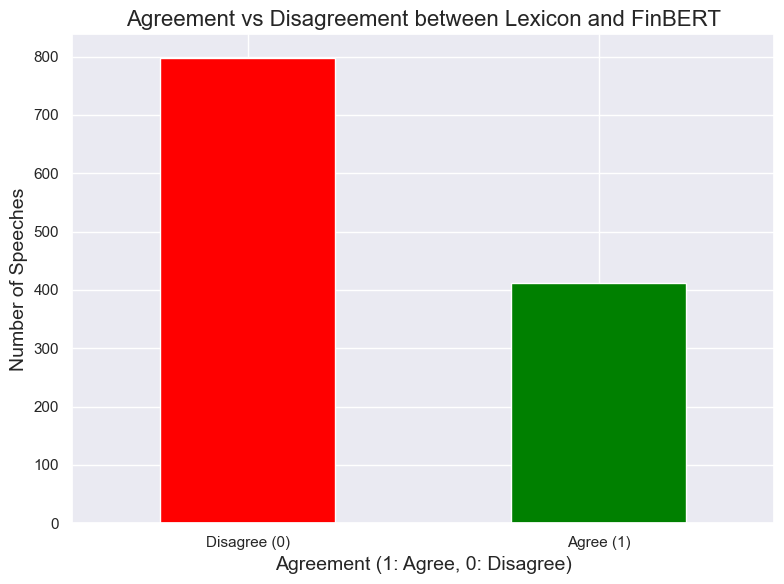

In [165]:
# Step 3: Visualize the agreement vs disagreement
agreement_count = boe_speeches_sentiment['agreement_lexicon_yiyang'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
agreement_count.plot(kind='bar', color=['red', 'green'])

# Adding labels and title
plt.title('Agreement vs Disagreement between Lexicon and FinBERT', fontsize=16)
plt.xlabel('Agreement (1: Agree, 0: Disagree)', fontsize=14)
plt.ylabel('Number of Speeches', fontsize=14)
plt.xticks([0, 1], ['Disagree (0)', 'Agree (1)'], rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

In [166]:
# Create a new column for agreement (1 for agree, 0 for disagree)
boe_speeches_sentiment['agreement_gpt_yiyang'] = (boe_speeches_sentiment['gpt_sentiment'] == boe_speeches_sentiment['yiyang_label']).astype(int)

boe_speeches_sentiment.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

  year_month_dt  ...  lexicon_label_weighted_2 lexicon_label_percentile  \
0    1998-09-01  ...                   Neutral                  Neutral   
1    1998-10-01  ...                  Positive                 Positive   
2    1998-10-01  ...                  Negative                  Neutral   
3    1998-11-01  ...                   Neutral                  Neutral   
4    1998-11-01  ...                   Neutral                  Neutral   

  sentiment_score_yiyang  sentiment_score_yiyang_std  yiyang_label  \
0               0.508915                    1.291954      Positive   
1               0.030655                   -0.260091       Neutral   
2              -0.578548                   -2.237069      Negative   
3               0.014560                   -0.312321       Neutral   
4               0.000886                   -0.356694       Neutral   

   gpt_sentiment  gpt_sentiment_numeric gpt_sentiment_std  \
0       Positive                      1          1.546736   
1       Positive                      1          1.546736   
2        Neutral                      0          0.017993   
3        Neutral                      0          0.017993   
4       Positive                      1          1.546736   

  agreement_lexicon_yiyang agreement_gpt_yiyang  
0                        0                    1  
1                        1                    0  
2                        0                    0  
3                        1                    1  
4                        1                    0  

[5 rows x 30 columns]

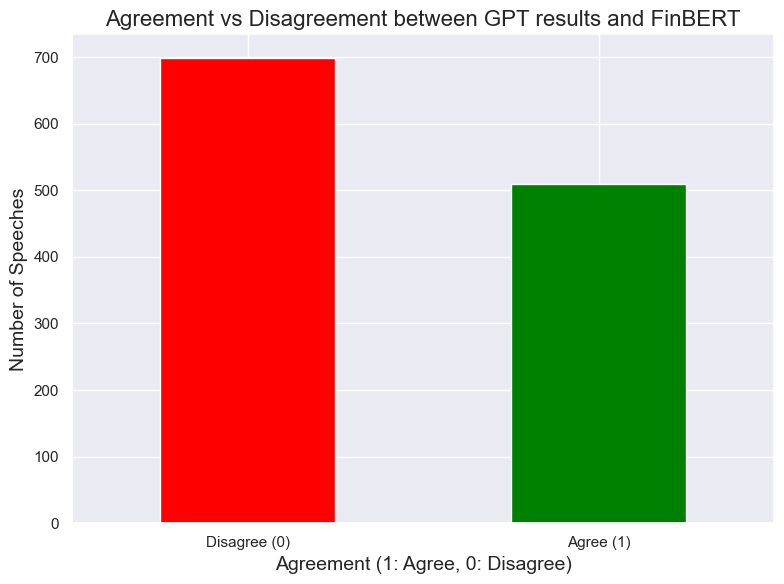

In [167]:
# Step 3: Visualize the agreement vs disagreement
agreement_count = boe_speeches_sentiment['agreement_gpt_yiyang'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
agreement_count.plot(kind='bar', color=['red', 'green'])

# Adding labels and title
plt.title('Agreement vs Disagreement between GPT results and FinBERT', fontsize=16)
plt.xlabel('Agreement (1: Agree, 0: Disagree)', fontsize=14)
plt.ylabel('Number of Speeches', fontsize=14)
plt.xticks([0, 1], ['Disagree (0)', 'Agree (1)'], rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

In [168]:
# Create a new column for agreement (1 for agree, 0 for disagree)
boe_speeches_sentiment['agreement_gpt_lexicon'] = (boe_speeches_sentiment['gpt_sentiment'] == boe_speeches_sentiment['lexicon_label']).astype(int)

boe_speeches_sentiment.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

  year_month_dt  ...  lexicon_label_percentile sentiment_score_yiyang  \
0    1998-09-01  ...                   Neutral               0.508915   
1    1998-10-01  ...                  Positive               0.030655   
2    1998-10-01  ...                   Neutral              -0.578548   
3    1998-11-01  ...                   Neutral               0.014560   
4    1998-11-01  ...                   Neutral               0.000886   

  sentiment_score_yiyang_std  yiyang_label  gpt_sentiment  \
0                   1.291954      Positive       Positive   
1                  -0.260091       Neutral       Positive   
2                  -2.237069      Negative        Neutral   
3                  -0.312321       Neutral        Neutral   
4                  -0.356694       Neutral       Positive   

   gpt_sentiment_numeric  gpt_sentiment_std agreement_lexicon_yiyang  \
0                      1           1.546736                        0   
1                      1           1.546736                        1   
2                      0           0.017993                        0   
3                      0           0.017993                        1   
4                      1           1.546736                        1   

  agreement_gpt_yiyang agreement_gpt_lexicon  
0                    1                     0  
1                    0                     0  
2                    0                     1  
3                    1                     1  
4                    0                     0  

[5 rows x 31 columns]

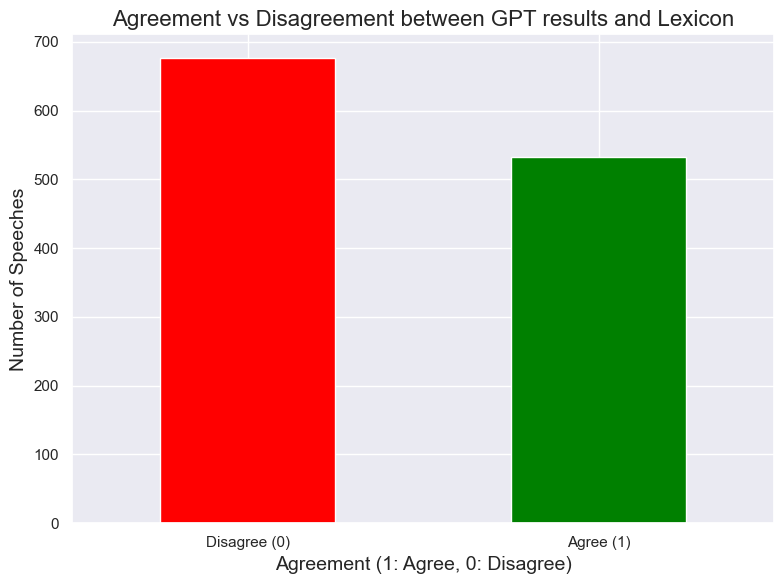

In [169]:
# Visualize the agreement vs disagreement
agreement_count = boe_speeches_sentiment['agreement_gpt_lexicon'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
agreement_count.plot(kind='bar', color=['red', 'green'])

# Adding labels and title
plt.title('Agreement vs Disagreement between GPT results and Lexicon', fontsize=16)
plt.xlabel('Agreement (1: Agree, 0: Disagree)', fontsize=14)
plt.ylabel('Number of Speeches', fontsize=14)
plt.xticks([0, 1], ['Disagree (0)', 'Agree (1)'], rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

In [170]:
# Create a new column for agreement (1 for agree, 0 for disagree)
boe_speeches_sentiment['agreement_gpt_lexicon_2'] = (boe_speeches_sentiment['gpt_sentiment'] == boe_speeches_sentiment['lexicon_label_2']).astype(int)

boe_speeches_sentiment.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

  year_month_dt  ...  sentiment_score_yiyang sentiment_score_yiyang_std  \
0    1998-09-01  ...                0.508915                   1.291954   
1    1998-10-01  ...                0.030655                  -0.260091   
2    1998-10-01  ...               -0.578548                  -2.237069   
3    1998-11-01  ...                0.014560                  -0.312321   
4    1998-11-01  ...                0.000886                  -0.356694   

  yiyang_label  gpt_sentiment  gpt_sentiment_numeric  gpt_sentiment_std  \
0     Positive       Positive                      1           1.546736   
1      Neutral       Positive                      1           1.546736   
2     Negative        Neutral                      0           0.017993   
3      Neutral        Neutral                      0           0.017993   
4      Neutral       Positive                      1           1.546736   

   agreement_lexicon_yiyang agreement_gpt_yiyang agreement_gpt_lexicon  \
0                         0                    1                     0   
1                         1                    0                     0   
2                         0                    0                     1   
3                         1                    1                     1   
4                         1                    0                     0   

  agreement_gpt_lexicon_2  
0                       0  
1                       1  
2                       0  
3                       1  
4                       0  

[5 rows x 32 columns]

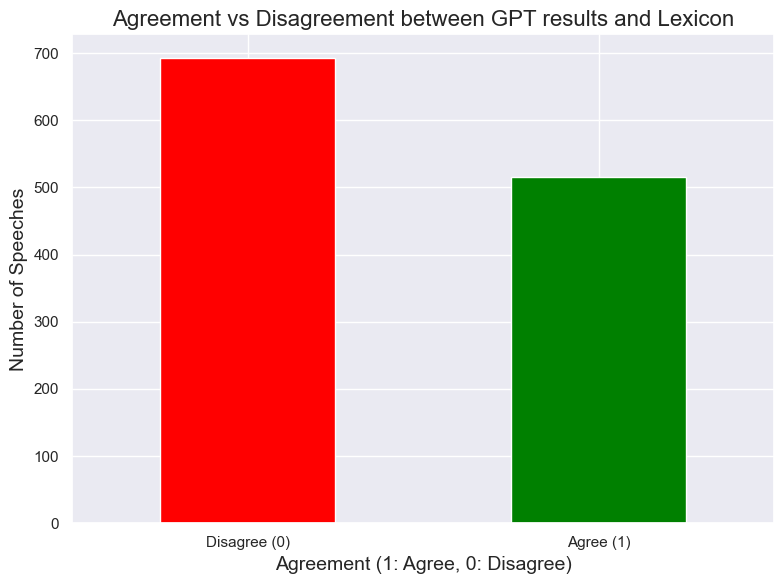

In [171]:
# Visualize the agreement vs disagreement
agreement_count = boe_speeches_sentiment['agreement_gpt_lexicon_2'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
agreement_count.plot(kind='bar', color=['red', 'green'])

# Adding labels and title
plt.title('Agreement vs Disagreement between GPT results and Lexicon', fontsize=16)
plt.xlabel('Agreement (1: Agree, 0: Disagree)', fontsize=14)
plt.ylabel('Number of Speeches', fontsize=14)
plt.xticks([0, 1], ['Disagree (0)', 'Agree (1)'], rotation=0)
plt.tight_layout()

# Display the plot
plt.show()

**Accuracy Test**

In [173]:
# Randomly sample 5 reviews from the DataFrame.
# accuracy_test = boe_speeches_sentiment.sample(n=5, random_state=101)

# Extract only the original review and summary columns.
# accuracy_test = accuracy_test[['year_month','text', 'lexicon_label', 'yiyang_label', 'gpt_sentiment']]

# Add columns for manually labelling the sentiment.
# accuracy_test['sentiment_labelled'] = ''

# Display the sampled reviews.
# accuracy_test

In [174]:
# Extract a CSV file.
#  accuracy_test.to_csv('sentiment_accuracy_test.csv', index = True)

# print("DataFrame was exported successfully.")

## 4. Display the data

In [277]:
boe_speeches_sentiment.dtypes

reference                                       object
country                                         object
date                                    datetime64[ns]
title                                           object
author                                          object
is_gov                                           int64
text                                            object
date_format                             datetime64[ns]
year_month                                   period[M]
year_month_dt                           datetime64[ns]
year                                             int32
text_lemmatised                                 object
text_lemmatised_str                             object
word_count                                       int64
sentiment_score_lexicon                        float64
sentiment_score_lexicon_std                    float64
sentiment_score_lexicon_weighted_std           float64
lexicon_label                                   object
lexicon_la

**Filter for 2012 to 2022**

In [279]:
# Filter the data for 2012 to 2022
start_date = '2012-01'
end_date = '2022-12'

In [281]:
# Filter the data for specified period
boe_speeches_sentiment_12_22 = boe_speeches_sentiment[(boe_speeches_sentiment['year_month'] >= start_date) & (boe_speeches_sentiment['year_month'] <= end_date)]

# View the DataFrame
boe_speeches_sentiment_12_22

reference         country       date  \
488   r120117a_BOE  united kingdom 2012-01-17   
489   r120119a_BOE  united kingdom 2012-01-19   
490   r120124a_BOE  united kingdom 2012-01-24   
491   r120126a_BOE  united kingdom 2012-01-26   
492   r120201a_BOE  united kingdom 2012-02-01   
...            ...             ...        ...   
1204  r221007a_BOE  united kingdom 2022-10-07   
1205  r221012a_BOE  united kingdom 2022-10-12   
1206  r221015a_BOE  united kingdom 2022-10-15   
1207  r221019a_BOE  united kingdom 2022-10-19   
1208  r221020a_BOE  united kingdom 2022-10-20   

                                                  title     author  is_gov  \
488   What the return of 19th century economics mean...      posen       0   
489                     Accounting for bank uncertainty    haldane       0   
490                                              Speech       king       1   
491   Towards a new architecture for payment arrange...     salmon       0   
492   Introductory remarks at the book launch for ‘I...     tucker       0   
...                                                 ...        ...     ...   
1204         Shocks, inflation, and the policy response    ramsden       0   
1205    Monetary policy: an anchor in challenging times       pill       0   
1206  Monetary policy and financial stability interv...     bailey       1   
1207  Governance of “Decentralised” Finance: Get up,...    wilkins       0   
1208       The inflationary consequences of real shocks  broadbent       0   

                                                   text date_format  \
488   I am very pleased to have the opportunity to s...  2012-01-17   
489   Fair value accounting principles are under att...  2012-01-19   
490   As we head into a challenging year for the wor...  2012-01-24   
491   It is a pleasure to participate in this annual...  2012-01-26   
492   The contributions come from journalism, politi...  2012-02-01   
...                                                 ...         ...   
1204  Thank you very much for the invitation to spea...  2022-10-07   
1205  Huw Pill talks about how we will bring inflati...  2022-10-12   
1206  We are meeting in the most difficult of times....  2022-10-15   
1207  These are divided into seven categories, suffr...  2022-10-19   
1208  Between them, the Covid-19 pandemic and Russia...  2022-10-20   

     year_month year_month_dt  ...  yiyang_label gpt_sentiment  \
488     2012-01    2012-01-01  ...      Positive      Positive   
489     2012-01    2012-01-01  ...       Neutral      Positive   
490     2012-01    2012-01-01  ...      Positive      Negative   
491     2012-01    2012-01-01  ...       Neutral       Neutral   
492     2012-02    2012-02-01  ...       Neutral      Positive   
...         ...           ...  ...           ...           ...   
1204    2022-10    2022-10-01  ...       Neutral      Negative   
1205    2022-10    2022-10-01  ...       Neutral      Positive   
1206    2022-10    2022-10-01  ...       Neutral       Neutral   
1207    2022-10    2022-10-01  ...       Neutral       Neutral   
1208    2022-10    2022-10-01  ...       Neutral      Negative   

     gpt_sentiment_numeric  gpt_sentiment_std  text_neg  text_neu  text_pos  \
488                      1           1.546736     0.094     0.726     0.180   
489                      1           1.546736     0.132     0.622     0.246   
490                     -1          -1.510749     0.149     0.675     0.177   
491                      0           0.017993     0.101     0.726     0.173   
492                      1           1.546736     0.117     0.705     0.178   
...                    ...                ...       ...       ...       ...   
1204                    -1          -1.510749     0.091     0.786     0.123   
1205                     1           1.546736     0.069     0.769     0.162   
1206                     0           0.017993     0.136     0.731     0.133   
1207                     0           0.017993  

### Speech Statistics

**Word Count per Year**

In [183]:
# Group and aggregate sentiment scores by month
wordcount_monthly = boe_speeches_sentiment_12_22.groupby('year_month_dt')['word_count'].mean().reset_index()

# View the DataFrame
wordcount_monthly.head()

year_month_dt  word_count
0    2012-01-01    1714.250
1    2012-02-01    2275.600
2    2012-03-01    1770.250
3    2012-04-01    2163.000
4    2012-05-01    1678.375

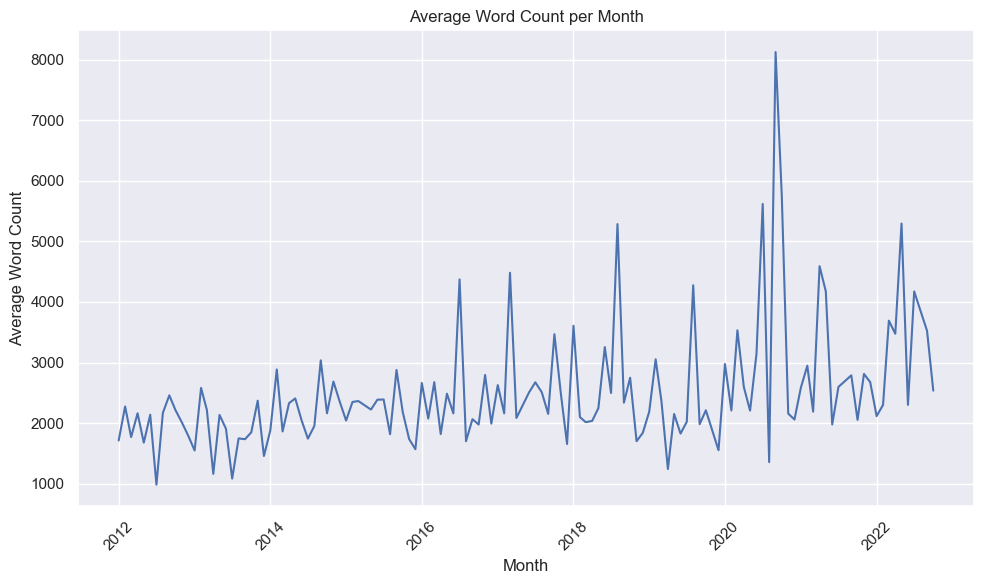

In [184]:
# Plot a line chart of average word count per month
plt.figure(figsize=(10, 6))
plt.plot(wordcount_monthly['year_month_dt'], wordcount_monthly['word_count'])
plt.xlabel('Month')
plt.ylabel('Average Word Count')
plt.title('Average Word Count per Month')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [185]:
# Group and aggregate sentiment scores by year
wordcount_yearly = boe_speeches_sentiment_12_22.groupby('year')['word_count'].mean().reset_index()

# View the DataFrame
wordcount_yearly.head()

year   word_count
0  2012  2002.661538
1  2013  1848.116667
2  2014  2236.535211
3  2015  2240.148148
4  2016  2365.552632

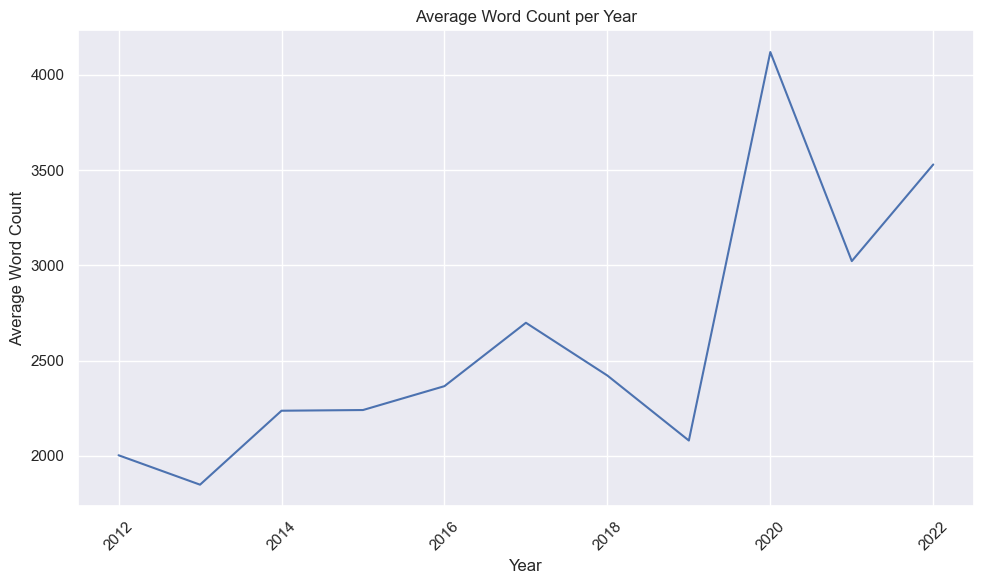

In [186]:
# Plot a line chart of average word count per year
plt.figure(figsize=(10, 6))
plt.plot(wordcount_yearly['year'], wordcount_yearly['word_count'])
plt.xlabel('Year')
plt.ylabel('Average Word Count')
plt.title('Average Word Count per Year')
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

In [187]:
# Group and aggregate sentiment scores by year
wordcount_count_yearly = boe_speeches_sentiment_12_22.groupby('year').agg({'word_count': 'mean',
                                                                           'reference': 'count'
                                                                          }).reset_index().rename(columns={'reference': 'speech_count'})

# View the DataFrame
wordcount_count_yearly.head()

year   word_count  speech_count
0  2012  2002.661538            65
1  2013  1848.116667            60
2  2014  2236.535211            71
3  2015  2240.148148            81
4  2016  2365.552632            76

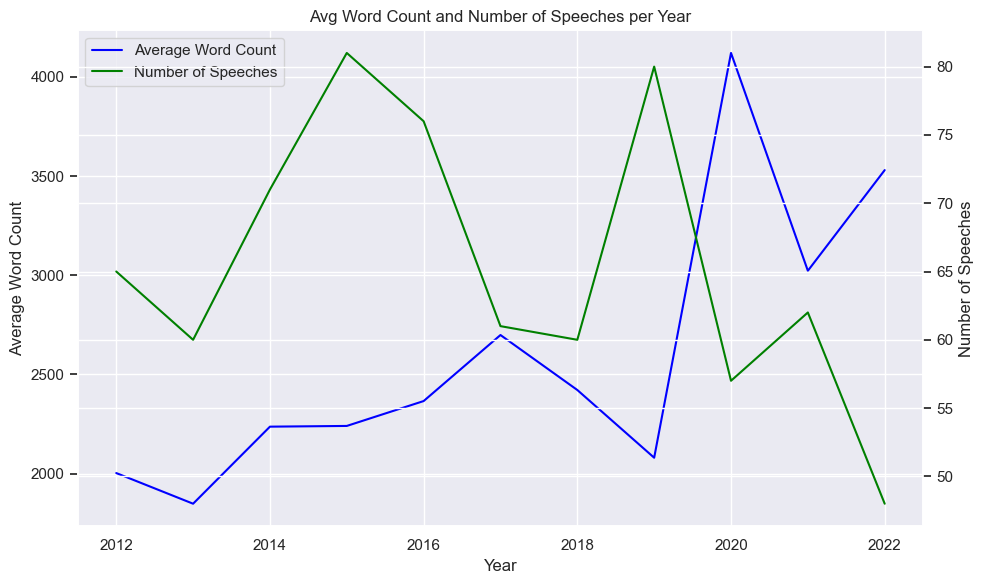

In [188]:
# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot 'word_count' on the primary y-axis
ax1.plot(wordcount_count_yearly['year'], wordcount_count_yearly['word_count'], color='blue', label='Average Word Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Word Count')
ax1.tick_params(axis='y')

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot 'speech_count' on the secondary y-axis
ax2.plot(wordcount_count_yearly['year'], wordcount_count_yearly['speech_count'], color='green', label='Number of Speeches')
ax2.set_ylabel('Number of Speeches')
ax2.tick_params(axis='y')

# Add titles and grid if needed
plt.title('Avg Word Count and Number of Speeches per Year')

# Optionally, add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Number of Speeches per Year**

In [190]:
# Group and aggregate number of speeches by governor by year
governor_speeches_monthly = boe_speeches_sentiment_12_22.groupby(['year', 'is_gov']).size().reset_index(name='count')

# View the DataFrame
governor_speeches_monthly.head()

year  is_gov  count
0  2012       0     57
1  2012       1      8
2  2013       0     48
3  2013       1     12
4  2014       0     61

In [191]:
# Pivot the data for plotting
governor_speeches_monthly_pivot = governor_speeches_monthly.pivot(index='year', columns='is_gov', values='count').fillna(0)

# View the DataFrame
governor_speeches_monthly_pivot.head()

is_gov   0   1
year          
2012    57   8
2013    48  12
2014    61  10
2015    65  16
2016    62  14

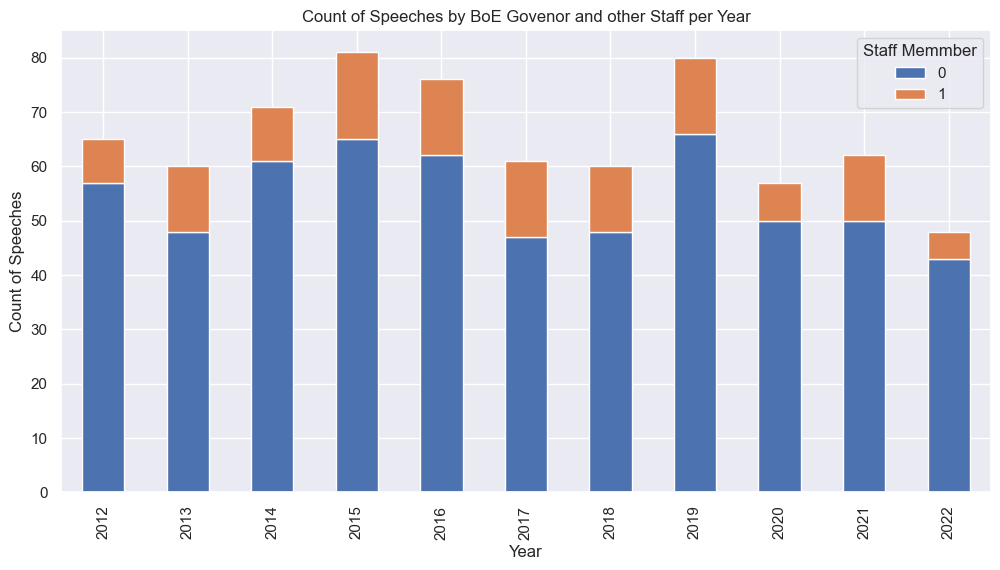

In [192]:
# Plot a bar chart per month
ax = governor_speeches_monthly_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Count of Speeches')
ax.set_title('Count of Speeches by BoE Govenor and other Staff per Year')
ax.legend(title='Staff Memmber')

# Display the plot
plt.show()

In [193]:
boe_speeches_sentiment_12_22.head()

reference         country       date  \
488  r120117a_BOE  united kingdom 2012-01-17   
489  r120119a_BOE  united kingdom 2012-01-19   
490  r120124a_BOE  united kingdom 2012-01-24   
491  r120126a_BOE  united kingdom 2012-01-26   
492  r120201a_BOE  united kingdom 2012-02-01   

                                                 title   author  is_gov  \
488  What the return of 19th century economics mean...    posen       0   
489                    Accounting for bank uncertainty  haldane       0   
490                                             Speech     king       1   
491  Towards a new architecture for payment arrange...   salmon       0   
492  Introductory remarks at the book launch for ‘I...   tucker       0   

                                                  text date_format year_month  \
488  I am very pleased to have the opportunity to s...  2012-01-17    2012-01   
489  Fair value accounting principles are under att...  2012-01-19    2012-01   
490  As we head into a challenging year for the wor...  2012-01-24    2012-01   
491  It is a pleasure to participate in this annual...  2012-01-26    2012-01   
492  The contributions come from journalism, politi...  2012-02-01    2012-02   

    year_month_dt  ...  sentiment_score_yiyang sentiment_score_yiyang_std  \
488    2012-01-01  ...                0.998556                   2.880930   
489    2012-01-01  ...                0.002392                  -0.351808   
490    2012-01-01  ...                0.999821                   2.885036   
491    2012-01-01  ...                0.004129                  -0.346173   
492    2012-02-01  ...                0.000219                  -0.358860   

    yiyang_label  gpt_sentiment  gpt_sentiment_numeric  gpt_sentiment_std  \
488     Positive       Positive                      1           1.546736   
489      Neutral       Positive                      1           1.546736   
490     Positive       Negative                     -1          -1.510749   
491      Neutral        Neutral                      0           0.017993   
492      Neutral       Positive                      1           1.546736   

     agreement_lexicon_yiyang agreement_gpt_yiyang agreement_gpt_lexicon  \
488                         0                    1                     0   
489                         1                    0                     0   
490                         0                    0                     0   
491                         1                    1                     1   
492                         1                    0                     0   

    agreement_gpt_lexicon_2  
488                       0  
489                       0  
490                       1  
491                       1  
492                       0  

[5 rows x 32 columns]

In [194]:
# Group and aggregate sentiment scores by year
gpt_sentiment_yearly= boe_speeches_sentiment_12_22.groupby(['year', 'gpt_sentiment']).size().reset_index(name='count')

# View the DataFrame
gpt_sentiment_yearly.head()

year gpt_sentiment  count
0  2012      Negative     14
1  2012       Neutral     29
2  2012      Positive     22
3  2013      Negative      2
4  2013       Neutral     26

In [195]:
# Pivot the data for plotting
gpt_sentiment_yearly_pivot = gpt_sentiment_yearly.pivot(index='year', columns='gpt_sentiment', values='count').fillna(0)

# View the DataFrame
gpt_sentiment_yearly_pivot.head()

gpt_sentiment  Negative  Neutral  Positive
year                                      
2012               14.0     29.0      22.0
2013                2.0     26.0      32.0
2014                5.0     21.0      45.0
2015                3.0     39.0      39.0
2016                3.0     24.0      49.0

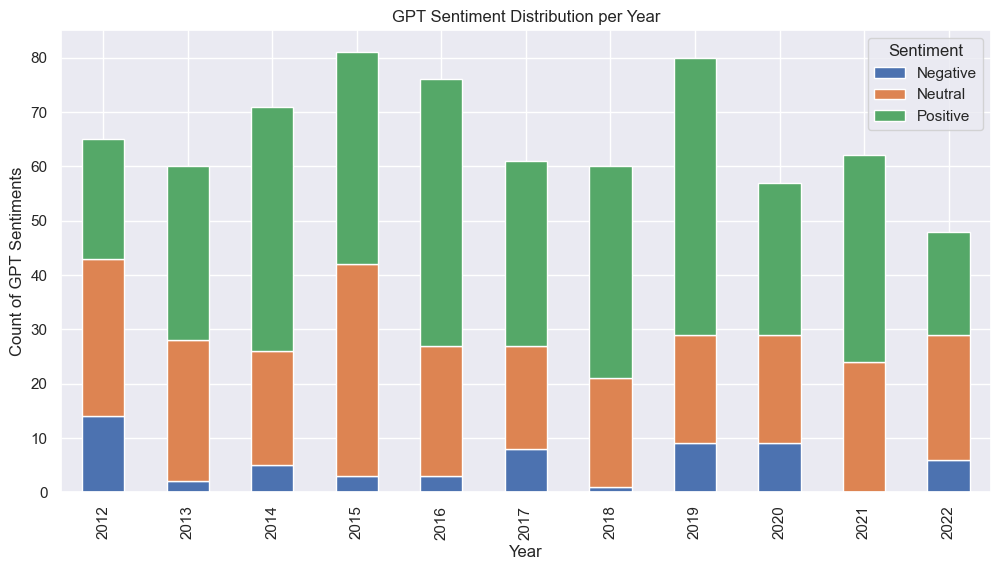

In [196]:
# Plot a bar chart per month
ax = gpt_sentiment_yearly_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Count of GPT Sentiments')
ax.set_title('GPT Sentiment Distribution per Year')
ax.legend(title='Sentiment')

# Display the plot
plt.show()

In [197]:
# Group and aggregate sentiment scores by year
lexicon_sentiment_yearly= boe_speeches_sentiment_12_22.groupby(['year', 'lexicon_label']).size().reset_index(name='count')

# View the DataFrame
lexicon_sentiment_yearly.head()

year lexicon_label  count
0  2012      Negative     17
1  2012       Neutral     47
2  2012      Positive      1
3  2013      Negative      5
4  2013       Neutral     49

In [198]:
# Pivot the data for plotting
lexicon_sentiment_yearly_pivot = lexicon_sentiment_yearly.pivot(index='year', columns='lexicon_label', values='count').fillna(0)

# View the DataFrame
lexicon_sentiment_yearly_pivot.head()

lexicon_label  Negative  Neutral  Positive
year                                      
2012                 17       47         1
2013                  5       49         6
2014                  8       58         5
2015                  9       57        15
2016                 11       54        11

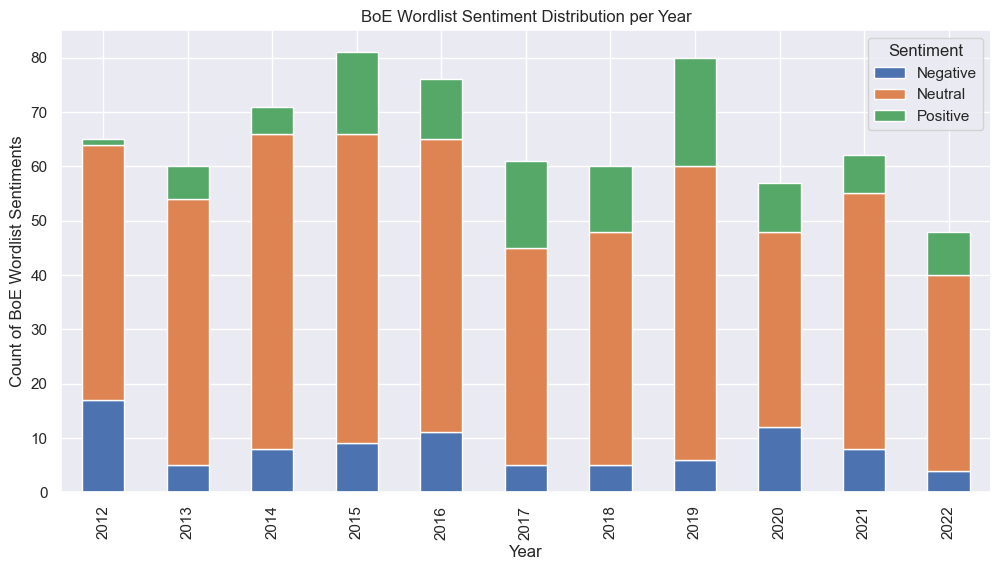

In [199]:
# Plot a bar chart per month
ax = lexicon_sentiment_yearly_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Count of BoE Wordlist Sentiments')
ax.set_title('BoE Wordlist Sentiment Distribution per Year')
ax.legend(title='Sentiment')

# Display the plot
plt.show()

In [200]:
# Group and aggregate sentiment scores by year
lexicon_sentiment_2_yearly= boe_speeches_sentiment_12_22.groupby(['year', 'lexicon_label_2']).size().reset_index(name='count')

# View the DataFrame
lexicon_sentiment_2_yearly.head()

year lexicon_label_2  count
0  2012        Negative     38
1  2012         Neutral     23
2  2012        Positive      4
3  2013        Negative     13
4  2013         Neutral     33

In [201]:
# Pivot the data for plotting
lexicon_sentiment_2_yearly_pivot = lexicon_sentiment_2_yearly.pivot(index='year', columns='lexicon_label_2', values='count').fillna(0)

# View the DataFrame
lexicon_sentiment_2_yearly_pivot.head()

lexicon_label_2  Negative  Neutral  Positive
year                                        
2012                   38       23         4
2013                   13       33        14
2014                   23       41         7
2015                   21       36        24
2016                   15       41        20

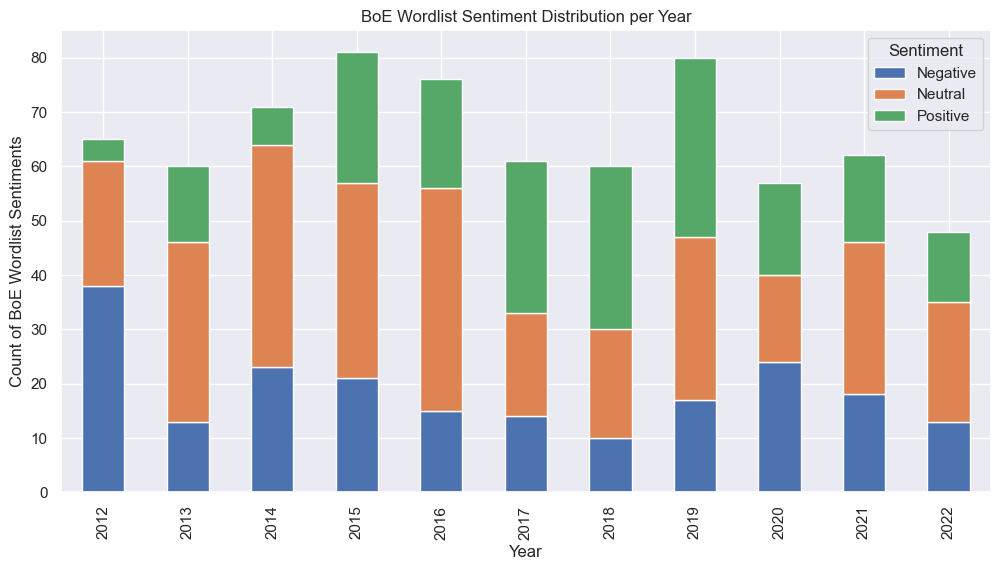

In [202]:
# Plot a bar chart per month
ax = lexicon_sentiment_2_yearly_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Count of BoE Wordlist Sentiments')
ax.set_title('BoE Wordlist Sentiment Distribution per Year')
ax.legend(title='Sentiment')

# Display the plot
plt.show()

In [203]:
# Group and aggregate sentiment scores by year
lexicon_sentiment_weighted_yearly= boe_speeches_sentiment_12_22.groupby(['year', 'lexicon_label_weighted']).size().reset_index(name='count')

# View the DataFrame
lexicon_sentiment_weighted_yearly.head()

year lexicon_label_weighted  count
0  2012               Negative     18
1  2012                Neutral     45
2  2012               Positive      2
3  2013               Negative      7
4  2013                Neutral     47

In [204]:
# Pivot the data for plotting
lexicon_sentiment_weighted_yearly_pivot = lexicon_sentiment_weighted_yearly.pivot(index='year', columns='lexicon_label_weighted', values='count').fillna(0)

# View the DataFrame
lexicon_sentiment_weighted_yearly_pivot.head()

lexicon_label_weighted  Negative  Neutral  Positive
year                                               
2012                          18       45         2
2013                           7       47         6
2014                          10       56         5
2015                          11       57        13
2016                          11       58         7

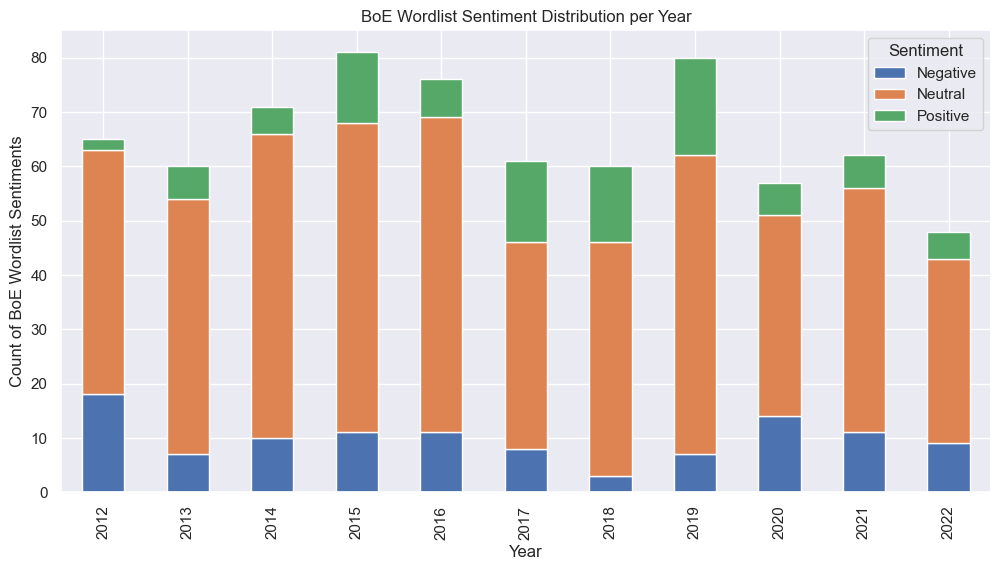

In [205]:
# Plot a bar chart per month
ax = lexicon_sentiment_weighted_yearly_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Count of BoE Wordlist Sentiments')
ax.set_title('BoE Wordlist Sentiment Distribution per Year')
ax.legend(title='Sentiment')

# Display the plot
plt.show()

In [206]:
# Group and aggregate sentiment scores by year
lexicon_sentiment_weighted_2_yearly= boe_speeches_sentiment_12_22.groupby(['year', 'lexicon_label_weighted_2']).size().reset_index(name='count')

# View the DataFrame
lexicon_sentiment_weighted_2_yearly.head()

year lexicon_label_weighted_2  count
0  2012                 Negative     40
1  2012                  Neutral     20
2  2012                 Positive      5
3  2013                 Negative     15
4  2013                  Neutral     33

In [207]:
# Pivot the data for plotting
lexicon_sentiment_weighted_2_yearly_pivot = lexicon_sentiment_weighted_2_yearly.pivot(index='year', columns='lexicon_label_weighted_2', values='count').fillna(0)

# View the DataFrame
lexicon_sentiment_weighted_2_yearly_pivot.head()

lexicon_label_weighted_2  Negative  Neutral  Positive
year                                                 
2012                            40       20         5
2013                            15       33        12
2014                            22       38        11
2015                            26       32        23
2016                            21       36        19

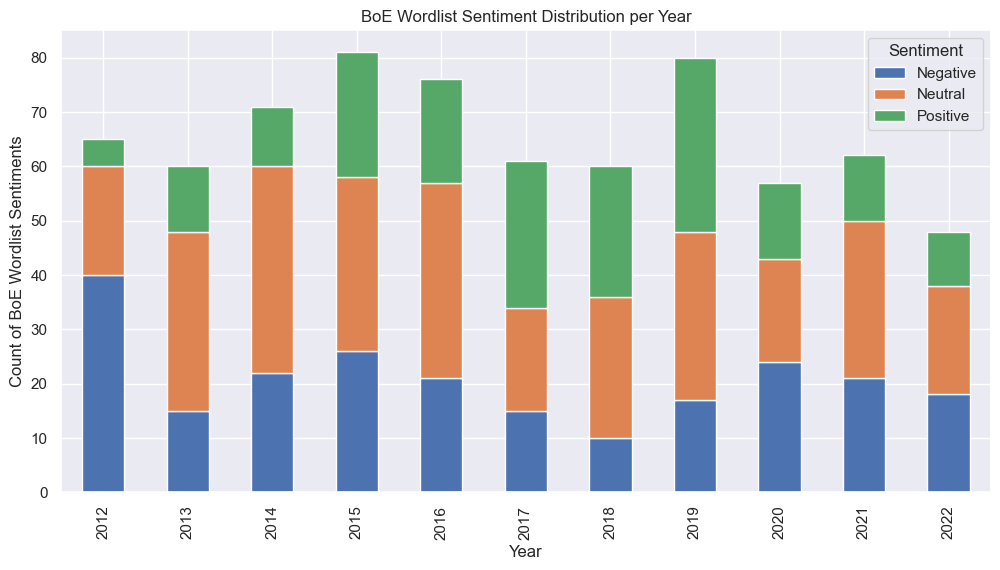

In [208]:
# Plot a bar chart per month
ax = lexicon_sentiment_weighted_2_yearly_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))

# Customize plot
ax.set_xlabel('Year')
ax.set_ylabel('Count of BoE Wordlist Sentiments')
ax.set_title('BoE Wordlist Sentiment Distribution per Year')
ax.legend(title='Sentiment')

# Display the plot
plt.show()

### 4.1. Compare the sentiment scores over time

In [210]:
# Group and aggregate sentiment scores by month
sentiment_monthly = boe_speeches_sentiment.groupby('year_month_dt')[['sentiment_score_yiyang_std','sentiment_score_lexicon_std', \
                                    'gpt_sentiment_std', 'sentiment_score_yiyang','sentiment_score_lexicon', \
                                    'gpt_sentiment_numeric', 'sentiment_score_lexicon_weighted_std']].mean().reset_index()
# View the DataFrame
sentiment_monthly.head()

year_month_dt  sentiment_score_yiyang_std  sentiment_score_lexicon_std  \
0    1998-09-01                    1.291954                    -0.420532   
1    1998-10-01                   -1.248580                     0.061198   
2    1998-11-01                   -0.341816                    -0.480369   
3    1998-12-01                   -0.356963                    -0.747103   
4    1999-01-01                   -0.601166                    -0.357277   

   gpt_sentiment_std  sentiment_score_yiyang  sentiment_score_lexicon  \
0           1.546736                0.508915                -0.019793   
1           0.782365               -0.273947                -0.010602   
2           0.527574                0.005471                -0.020935   
3           0.782365                0.000804                -0.026024   
4           0.782365               -0.074447                -0.018587   

   gpt_sentiment_numeric  sentiment_score_lexicon_weighted_std  
0               1.000000                              0.426960  
1               0.500000                              0.257491  
2               0.333333                             -0.157427  
3               0.500000                             -0.714095  
4               0.500000                             -0.122982

In [211]:
# Review the DataFrame
sentiment_monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   year_month_dt                         272 non-null    datetime64[ns]
 1   sentiment_score_yiyang_std            272 non-null    float64       
 2   sentiment_score_lexicon_std           272 non-null    float64       
 3   gpt_sentiment_std                     272 non-null    float64       
 4   sentiment_score_yiyang                272 non-null    float64       
 5   sentiment_score_lexicon               272 non-null    float64       
 6   gpt_sentiment_numeric                 272 non-null    float64       
 7   sentiment_score_lexicon_weighted_std  272 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 17.1 KB


**4.1.a. Analysis by date**

In [213]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_monthly,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std','sentiment_score_lexicon_std', 'gpt_sentiment_numeric'],
     title="Average monthly sentiment scores – Bank of England speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

In [214]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_monthly,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std','sentiment_score_lexicon_std'],
     title="Average monthly sentiment scores – Bank of England speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

In [215]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_monthly,
     x='year_month_dt',
     y=['sentiment_score_lexicon_std','gpt_sentiment_numeric'],
     title="Average monthly BoE Wordlist and GPT sentiment scores – Bank of England speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

**4.1.b. Analysis by year**

In [217]:
boe_speeches_sentiment.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'date_format', 'year_month', 'year_month_dt', 'year', 'text_lemmatised',
       'text_lemmatised_str', 'word_count', 'sentiment_score_lexicon',
       'sentiment_score_lexicon_std', 'sentiment_score_lexicon_weighted_std',
       'lexicon_label', 'lexicon_label_2', 'lexicon_label_weighted',
       'lexicon_label_weighted_2', 'lexicon_label_percentile',
       'sentiment_score_yiyang', 'sentiment_score_yiyang_std', 'yiyang_label',
       'gpt_sentiment', 'gpt_sentiment_numeric', 'gpt_sentiment_std',
       'agreement_lexicon_yiyang', 'agreement_gpt_yiyang',
       'agreement_gpt_lexicon', 'agreement_gpt_lexicon_2'],
      dtype='object')

In [283]:
# Group and aggregate sentiment scores by year
sentiment_yearly = boe_speeches_sentiment.groupby('year')[['sentiment_score_yiyang_std','sentiment_score_lexicon_std', \
                                    'gpt_sentiment_std', 'sentiment_score_yiyang','sentiment_score_lexicon', \
                                    'gpt_sentiment_numeric', 'sentiment_score_lexicon_weighted_std', \
                                                           'sentiment_score_vader_std']].mean().reset_index()
# View the DataFrame
sentiment_yearly.head()

year  sentiment_score_yiyang_std  sentiment_score_lexicon_std  \
0  1998                   -0.368073                    -0.404181   
1  1999                   -0.106076                     0.187389   
2  2000                    0.451919                     0.815335   
3  2001                    0.003499                    -0.041725   
4  2002                   -0.039300                     0.350434   

   gpt_sentiment_std  sentiment_score_yiyang  sentiment_score_lexicon  \
0           0.782365               -0.002620                -0.019482   
1           0.884281                0.078114                -0.008195   
2           1.164550                0.250059                 0.003786   
3           0.858802                0.111880                -0.012566   
4           0.884281                0.098691                -0.005084   

   gpt_sentiment_numeric  sentiment_score_lexicon_weighted_std  \
0               0.500000                             -0.119816   
1               0.566667                              0.289742   
2               0.750000                              1.050662   
3               0.550000                              0.234767   
4               0.566667                              0.626208   

   sentiment_score_vader_std  
0                   0.342631  
1                   0.230724  
2                   0.250830  
3                   0.246478  
4                   0.231381

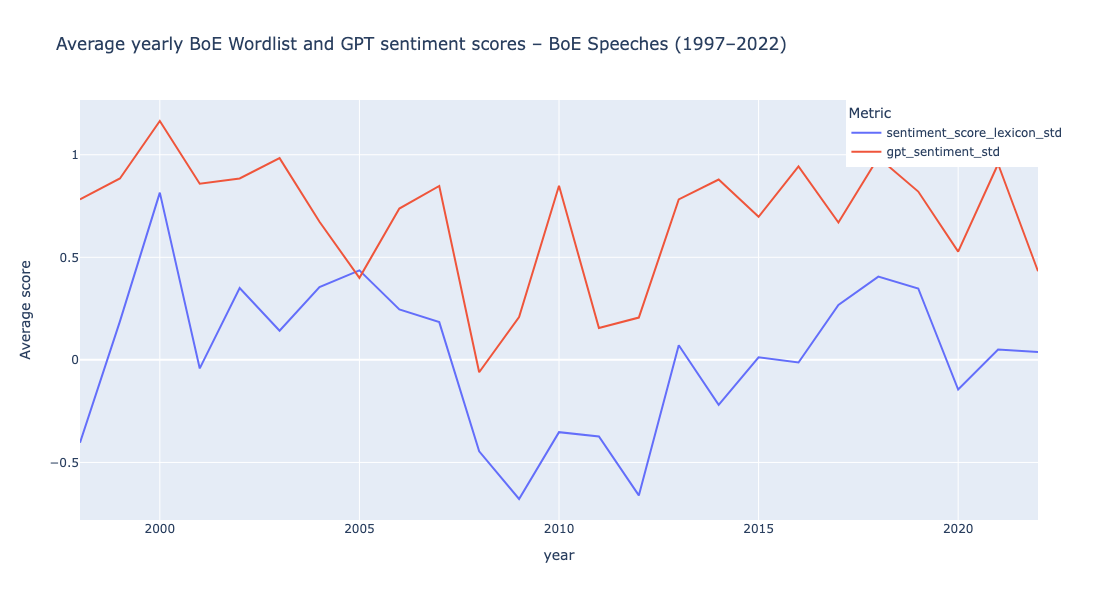

In [285]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_yearly,
     x='year',
     y=['sentiment_score_lexicon_std','gpt_sentiment_std'],
     title="Average yearly BoE Wordlist and GPT sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

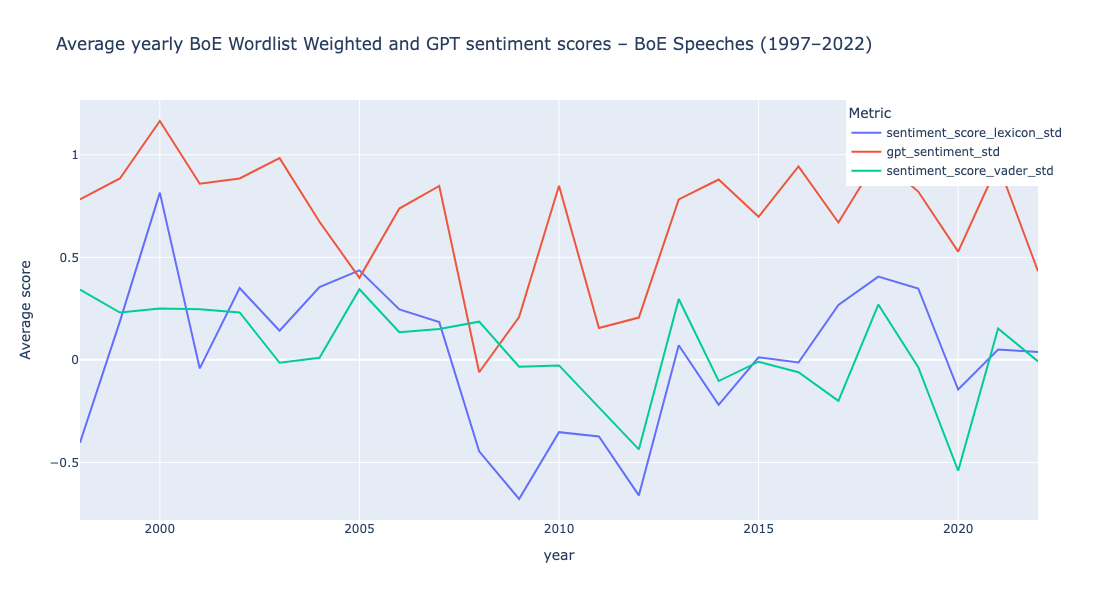

In [295]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_yearly,
     x='year',
     y=['sentiment_score_lexicon_std','gpt_sentiment_std', 'sentiment_score_vader_std'],
     title="Average yearly BoE Wordlist Weighted and GPT sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

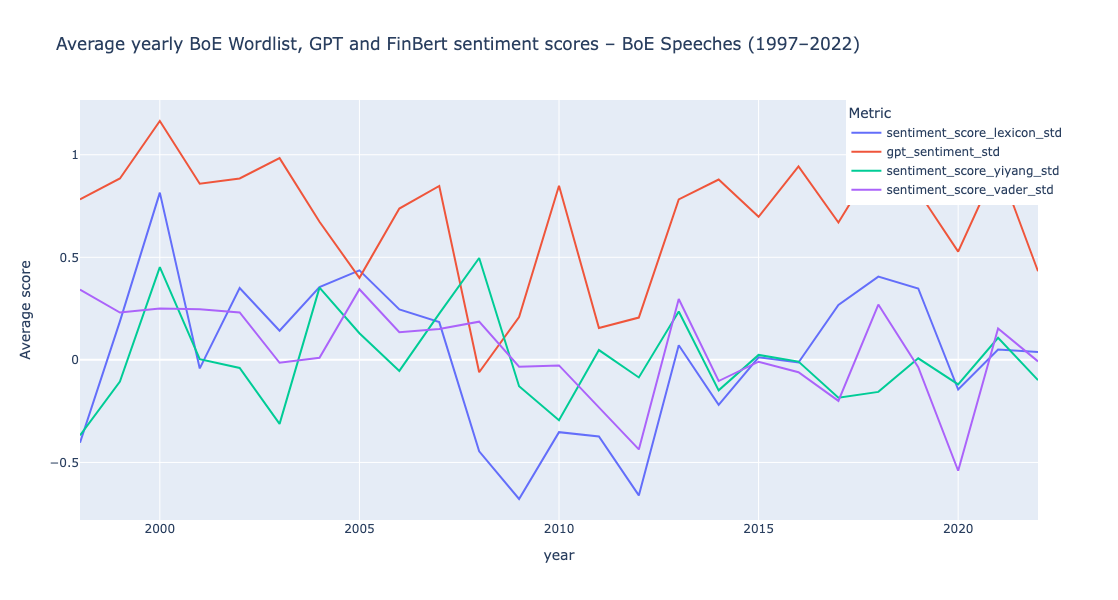

In [291]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_yearly,
     x='year',
     y=['sentiment_score_lexicon_std','gpt_sentiment_std', 'sentiment_score_yiyang_std', 'sentiment_score_vader_std'],
     title="Average yearly BoE Wordlist, GPT and FinBert sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

**4.1.c. Analysis by quarter/ 3 month averages**

In [487]:
# Group and aggregate sentiment scores by quarter
sentiment_quarterly = boe_speeches_sentiment.groupby(pd.Grouper(key='year_month_dt', freq='Q'))[
    ['sentiment_score_yiyang_std', 'sentiment_score_lexicon_std',
     'gpt_sentiment_std', 'sentiment_score_yiyang', 'sentiment_score_lexicon',
     'gpt_sentiment_numeric', 'sentiment_score_vader_std']
].mean().reset_index()

# View the DataFrane
sentiment_quarterly.head()

year_month_dt  sentiment_score_yiyang_std  sentiment_score_lexicon_std  \
0    1998-09-30                    1.291954                    -0.420532   
1    1998-12-31                   -0.605219                    -0.401845   
2    1999-03-31                    0.032306                     0.349807   
3    1999-06-30                    0.118181                     0.834611   
4    1999-09-30                   -0.309372                    -0.792866   

   gpt_sentiment_std  sentiment_score_yiyang  sentiment_score_lexicon  \
0           1.546736                0.508915                -0.019793   
1           0.673169               -0.075696                -0.019437   
2           0.973458                0.120756                -0.005096   
3           0.782365                0.147219                 0.004154   
4           0.629491                0.015469                -0.026897   

   gpt_sentiment_numeric  sentiment_score_vader_std  
0               1.000000                   0.330402  
1               0.428571                   0.344378  
2               0.625000                   0.345736  
3               0.500000                   0.346871  
4               0.400000                  -0.339865

In [493]:
# View the DataFrane
sentiment_quarterly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   year_month_dt                98 non-null     datetime64[ns]
 1   sentiment_score_yiyang_std   98 non-null     float64       
 2   sentiment_score_lexicon_std  98 non-null     float64       
 3   gpt_sentiment_std            98 non-null     float64       
 4   sentiment_score_yiyang       98 non-null     float64       
 5   sentiment_score_lexicon      98 non-null     float64       
 6   gpt_sentiment_numeric        98 non-null     float64       
 7   sentiment_score_vader_std    98 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.3 KB


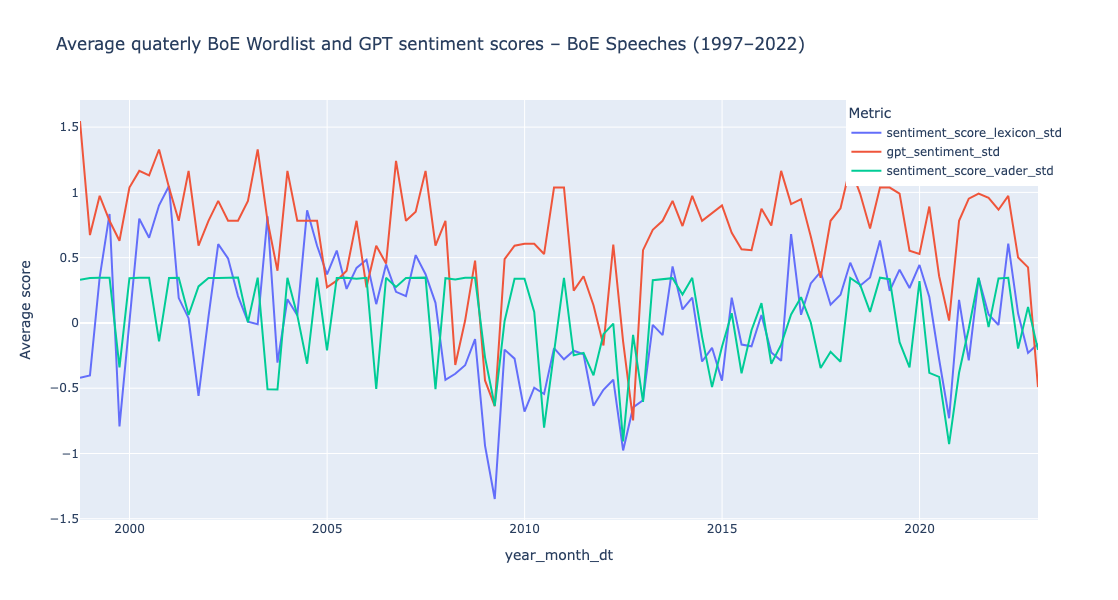

In [495]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_quarterly,
     x='year_month_dt',
     y=['sentiment_score_lexicon_std','gpt_sentiment_std', 'sentiment_score_vader_std'],
     title="Average quaterly BoE Wordlist and GPT sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

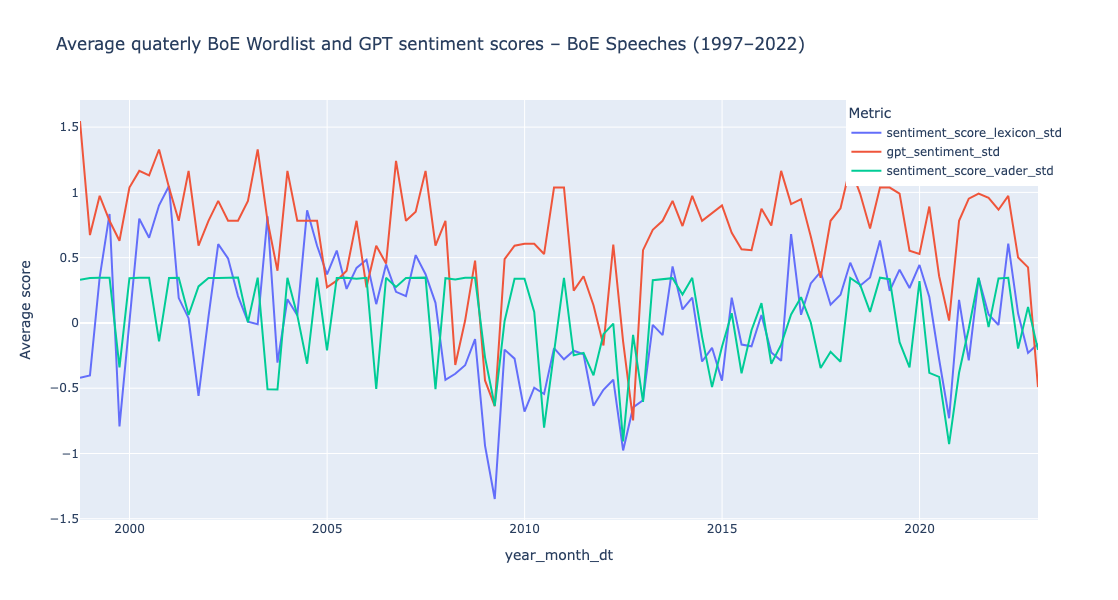

In [497]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_quarterly,
     x='year_month_dt',
     y=['sentiment_score_lexicon_std','gpt_sentiment_std', 'sentiment_score_vader_std'],
     title="Average quaterly BoE Wordlist and GPT sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

In [225]:
# Plot sentiment scores over time

# Define the plot
fig = px.line(
     sentiment_quarterly,
     x='year_month_dt',
     y=['sentiment_score_lexicon_std','gpt_sentiment_std', 'sentiment_score_yiyang_std'],
     title="Average quaterly BoE Wordlist, GPT and FinBert sentiment scores – BoE Speeches (1997–2022)",
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Display the plot
fig.show()

### 4.2.Seasonality Analysis

In [227]:
# View DataFrame
sentiment_monthly.columns

Index(['year_month_dt', 'sentiment_score_yiyang_std',
       'sentiment_score_lexicon_std', 'gpt_sentiment_std',
       'sentiment_score_yiyang', 'sentiment_score_lexicon',
       'gpt_sentiment_numeric', 'sentiment_score_lexicon_weighted_std'],
      dtype='object')

In [228]:
# Filter the data by date for Covid
start_date = '2012-01'
end_date = '2022-12'

In [229]:
# Filter the data for specified period
seasonality = sentiment_monthly[(sentiment_monthly['year_month_dt'] >= start_date) & (sentiment_monthly['year_month_dt'] <= end_date)]

In [230]:
# Set the datetime as index
seasonality.set_index('year_month_dt', inplace=True)

# View the DataFrame
seasonality

sentiment_score_yiyang_std  sentiment_score_lexicon_std  \
year_month_dt                                                            
2012-01-01                       1.266996                    -0.446929   
2012-02-01                      -0.222546                    -0.555370   
2012-03-01                      -0.275599                    -0.380991   
2012-04-01                       0.079940                     0.078925   
2012-05-01                      -0.235342                    -1.290802   
...                                   ...                          ...   
2022-05-01                       0.275485                    -0.239995   
2022-06-01                      -0.251380                     0.401560   
2022-07-01                      -0.267802                    -0.030838   
2022-09-01                      -0.166647                    -0.527496   
2022-10-01                      -0.368466                    -0.160327   

               gpt_sentiment_std  sentiment_score_yiyang  \
year_month_dt                                              
2012-01-01              0.400179                0.501224   
2012-02-01              0.323742                0.042224   
2012-03-01              0.782365                0.025876   
2012-04-01              0.017993                0.135435   
2012-05-01             -0.173099                0.038281   
...                          ...                     ...   
2022-05-01              0.236385                0.195692   
2022-06-01              0.527574                0.033339   
2022-07-01              0.357714                0.028278   
2022-09-01              0.527574                0.059449   
2022-10-01             -0.491587               -0.002741   

               sentiment_score_lexicon  gpt_sentiment_numeric  \
year_month_dt                                                   
2012-01-01                   -0.020297               0.250000   
2012-02-01                   -0.022366               0.200000   
2012-03-01                   -0.019039               0.500000   
2012-04-01                   -0.010264               0.000000   
2012-05-01                   -0.036397              -0.125000   
...                                ...                    ...   
2022-05-01                   -0.016349               0.142857   
2022-06-01                   -0.004109               0.333333   
2022-07-01                   -0.012358               0.222222   
2022-09-01                   -0.021834               0.333333   
2022-10-01                   -0.014829              -0.333333   

               sentiment_score_lexicon_weighted_std  
year_month_dt                                        
2012-01-01                                -0.440166  
2012-02-01                                -0.478124  
2012-03-01                                -0.502173  
2012-04-01                                -0.236050  
2012-05-01                                -1.217593  
...                                             ...  
2022-05-01                                -0.442131  
2022-06-01                                 0.267206  
2022-07-01                                -0.190661  
2022-09-01                                -1.039473  
2022-10-01                                -0.359277  

[125 rows x 7 columns]

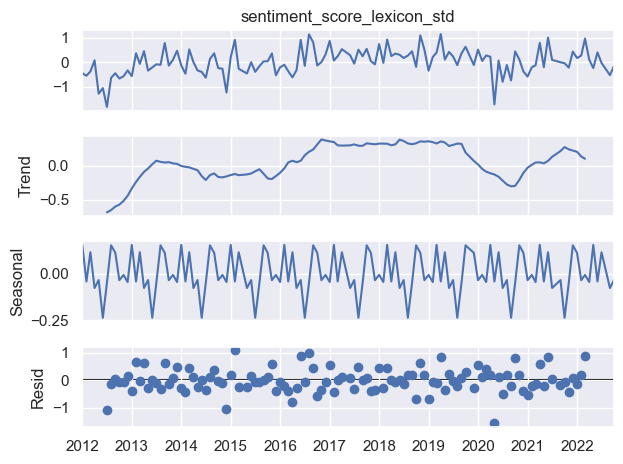

In [231]:
# Perform decomposition
decomposed_lexicon = seasonal_decompose(seasonality['sentiment_score_lexicon_std'], model='additive', period=12)

# Plot the decomposition
decomposed_lexicon.plot()
plt.show()

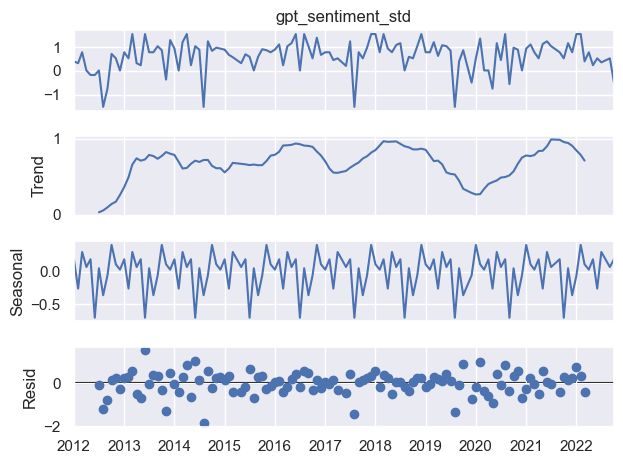

In [232]:
# Perform decomposition
decomposed_gpt = seasonal_decompose(seasonality['gpt_sentiment_std'], model='additive', period=12)

# Plot the decomposition
decomposed_gpt.plot()
plt.show()

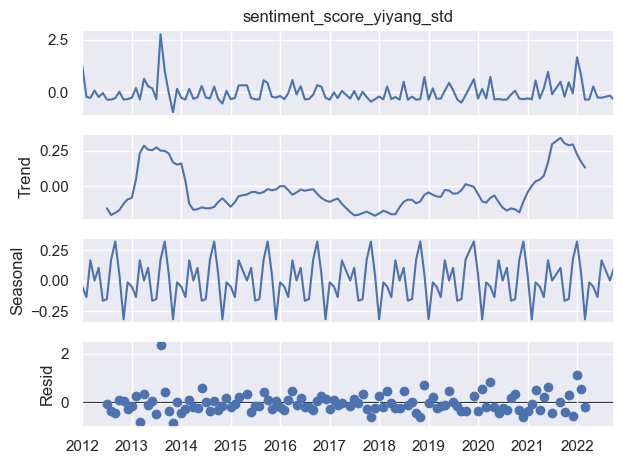

In [233]:
# Perform decomposition
decomposed_finbert = seasonal_decompose(seasonality['sentiment_score_yiyang_std'], model='additive', period=12)

# Plot the decomposition
decomposed_finbert.plot()
plt.show()

**Observations Peaks**
- August 2013: Peak with a speech announcing Jane Austen on 10 GBP note and a discussion of the evolution of monetary policy since 2008-2009 crisis
- January 2022: speech about inflation with a sense of urgency about controlling inflation with reassurance that the Bank is actively monitoring and prepared to act responsibly. 

In [499]:
sentiment_quarterly.columns

Index(['year_month_dt', 'sentiment_score_yiyang_std',
       'sentiment_score_lexicon_std', 'gpt_sentiment_std',
       'sentiment_score_yiyang', 'sentiment_score_lexicon',
       'gpt_sentiment_numeric', 'sentiment_score_vader_std'],
      dtype='object')

In [501]:
# Filter the data by date for Covid
start_date = '2012-01'
end_date = '2022-12'

In [507]:
# Filter the data for specified period
seasonality_quarterly = sentiment_quarterly[(sentiment_quarterly['year_month_dt'] >= start_date) & (sentiment_quarterly['year_month_dt'] <= end_date)]

In [509]:
# Set the datetime as index
seasonality_quarterly.set_index('year_month_dt', inplace=True)

# View the DataFrame
seasonality_quarterly

sentiment_score_yiyang_std  sentiment_score_lexicon_std  \
year_month_dt                                                            
2012-03-31                       0.030860                    -0.435069   
2012-06-30                      -0.104023                    -0.977048   
2012-09-30                      -0.299494                    -0.647566   
2012-12-31                      -0.108749                    -0.592628   
2013-03-31                      -0.021620                    -0.014683   
2013-06-30                       0.330847                    -0.093188   
2013-09-30                       1.099034                     0.432434   
2013-12-31                      -0.170093                     0.103386   
2014-03-31                      -0.040441                     0.194397   
2014-06-30                      -0.054755                    -0.295322   
2014-09-30                      -0.054393                    -0.190578   
2014-12-31                      -0.320411                    -0.441819   
2015-03-31                      -0.028553                     0.193636   
2015-06-30                      -0.063450                    -0.165625   
2015-09-30                       0.085895                    -0.179132   
2015-12-31                       0.083632                     0.061032   
2016-03-31                      -0.188808                    -0.226766   
2016-06-30                       0.134908                    -0.290490   
2016-09-30                      -0.177048                     0.680117   
2016-12-31                       0.119623                     0.062100   
2017-03-31                      -0.183865                     0.302858   
2017-06-30                      -0.149128                     0.391725   
2017-09-30                       0.002982                     0.139669   
2017-12-31                      -0.356375                     0.215306   
2018-03-31                      -0.084021                     0.461167   
2018-06-30                      -0.333260                     0.285151   
2018-09-30                      -0.003636                     0.347780   
2018-12-31                      -0.074943                     0.631178   
2019-03-31                      -0.185253                     0.246503   
2019-06-30                       0.184564                     0.407884   
2019-09-30                      -0.161525                     0.267519   
2019-12-31                       0.042334                     0.444346   
2020-03-31                      -0.043788                     0.198450   
2020-06-30                       0.019402                    -0.280207   
2020-09-30                      -0.232367                    -0.730514   
2020-12-31                      -0.146673                     0.176346   
2021-03-31                      -0.030067                    -0.286139   
2021-06-30                       0.226241                     0.343027   
2021-09-30                       0.084757                     0.064880   
2021-12-31                       0.126046                    -0.015794   
2022-03-31                       0.317773                     0.607291   
2022-06-30                      -0.087653                     0.071548   
2022-09-30                      -0.227340                    -0.229501   

               gpt_sentiment_std  sentiment_score_yiyang  \
year_month_dt                                              
2012-03-31              0.600372                0.120311   
2012-06-30             -0.142927                0.078747   
2012-09-30             -0.746378                0.018513   
2012-12-31              0.557550                0.077290   
2013-03-31              0.712876                0.104139   
2013-06-30              0.782365                0.212751   
2013-09-30              0.935239                0.449467   
2013-12-31              0.742135                0.058387   
2014-03-31              0.973458                0.098339   
2014-06-30              

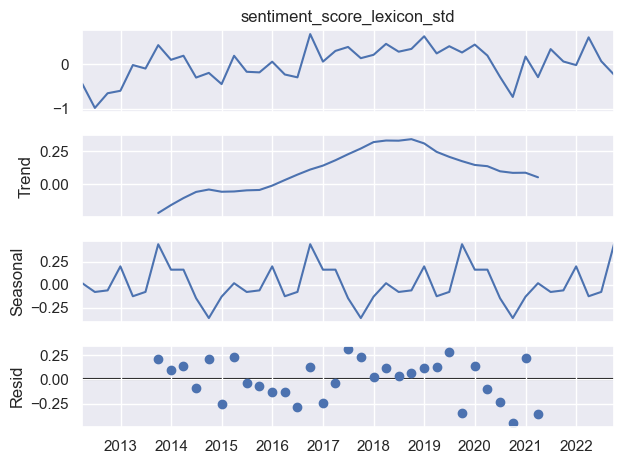

In [511]:
# Perform decomposition
decomposed_lexicon_quarterly = seasonal_decompose(seasonality_quarterly['sentiment_score_lexicon_std'], model='additive', period=12)

# Plot the decomposition
decomposed_lexicon_quarterly.plot()
plt.show()

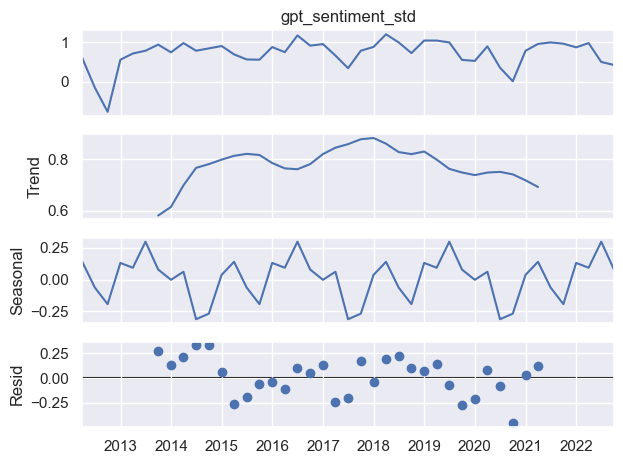

In [513]:
# Perform decomposition
decomposed_gpt_quarterly = seasonal_decompose(seasonality_quarterly['gpt_sentiment_std'], model='additive', period=12)

# Plot the decomposition
decomposed_gpt_quarterly.plot()
plt.show()

## Governor speeches only

In [236]:
# Filter speeches for governors only
boe_speeches_finbert_gov = boe_speeches_finbert[boe_speeches_finbert['is_gov'] == 1]

# View the DataFrame
boe_speeches_finbert_gov.head()

NameError: name 'boe_speeches_finbert' is not defined

In [ ]:
# Review the DataFrame
boe_speeches_finbert_gov.info()

In [ ]:
# Group and aggregate sentiment scores by month
finbert_monthly_gov = boe_speeches_finbert_gov.groupby('year_month')[['yiyang_neutral', 'yiyang_positive', 'yiyang_negative', \
                                                              'yiyang_confidence', 'sentiment_score_yiyang', \
                                                                 'sentiment_score_yiyang_std']].mean().reset_index()
finbert_monthly_gov.head()

In [ ]:
# Change the date format
finbert_monthly_gov['year_month_dt'] = finbert_monthly_gov['year_month'].dt.to_timestamp()

In [ ]:
# Filter the data for 10 years
start_date = '2012-01'
end_date = '2022-12'

In [ ]:
# Filter the data for specified period
seasonality_finbert_gov_10 = finbert_monthly_gov[(finbert_monthly_gov['year_month'] >= start_date) & \
                          (finbert_monthly_gov['year_month'] <= end_date)]

In [ ]:
# Set the datetime as index
seasonality_finbert_gov_10.set_index('year_month_dt', inplace=True)

# View the DataFrame
seasonality_finbert_gov_10

In [ ]:
# Perform decomposition
decomposed = seasonal_decompose(seasonality_finbert_gov_10['sentiment_score_yiyang_std'], model='additive', period=12)

# Plot the decomposition
decomposed.plot()
plt.show()

### 4.1. Covid

In [ ]:
# Filter the data by date for Covid
start_date = '2020-01'
end_date = '2022-12'

In [ ]:
# Filter the data for specified period
finbert_covid = finbert_monthly[(finbert_monthly['year_month_dt'] >= start_date) & (finbert_monthly['year_month_dt'] <= end_date)]

In [ ]:
fig = px.line(
     finbert_covid,
     x='year_month_dt',
     y=['yiyang_neutral','yiyang_positive', 'yiyang_negative'],
     title='Average monthly Finbert scores – Bank of England speeches during Covid (2020–2022)',
     labels={'value': 'Average score', 'variable': 'Metric'},
    color_discrete_sequence=['blue', 'green', 'red']
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [ ]:
fig = px.line(
     finbert_covid,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std'],
     title='Average monthly standardised Finbert scores – Bank of England speeches during Covid (2020–2022)',
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [ ]:
# Filter the data for specified period
finbert_gov_covid = finbert_monthly_gov[(finbert_monthly_gov['year_month_dt'] >= start_date) & (finbert_monthly_gov['year_month_dt'] <= end_date)]

In [ ]:
fig = px.line(
     finbert_gov_covid,
     x='year_month_dt',
     y=['yiyang_neutral','yiyang_positive', 'yiyang_negative'],
     title='Average monthly Finbert scores – Bank of England speeches during Covid (2020–2022)',
     labels={'value': 'Average score', 'variable': 'Metric'},
    color_discrete_sequence=['blue', 'green', 'red']
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

### 4.2. Brexit vote

In [ ]:
# Filter the data by date for before and after Brexit
start_date = '2016-01'
end_date = '2017-06'

In [ ]:
# Filter the data for specified period
finbert_brexit = finbert_monthly[(finbert_monthly['year_month_dt'] >= start_date) & (finbert_monthly['year_month_dt'] <= end_date)]

In [ ]:
fig = px.line(
     finbert_brexit,
     x='year_month_dt',
     y=['yiyang_neutral','yiyang_positive', 'yiyang_negative'],
     title='Average monthly Finbert scores – Bank of England speeches during Brexit (2016–2017)',
     labels={'value': 'Average score', 'variable': 'Metric'},
    color_discrete_sequence=['blue', 'green', 'red']
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

In [ ]:
fig = px.line(
     finbert_covid,
     x='year_month_dt',
     y=['sentiment_score_yiyang_std'],
     title='Average monthly stamdardised Finbert scores – Bank of England speeches during Brexit (2016–2017)',
     labels={'value': 'Average score', 'variable': 'Metric'}
)

# Adjust size
fig.update_layout(width=1100, height=600)

# Move the legend
fig.update_layout(
    legend=dict(
        x=0.8,
        y=1,
        xanchor='left',
        yanchor='top'
    )
)

# Show the figure
fig.show()

### Filter the dataframe

In [ ]:
target_words = {
    'inflation': ['inflation'],           
    'monetary policy': ['monetary policy'],               
    'price stability': ['price stability'],
    'exchange rate': ['exchange rate'],
    'growth': ['growth'],
    'financial market': ['finanical market']
}

In [ ]:
def count_word(text, word):
    tokens = [w.lower() for w in word_tokenize(str(text))]
    return tokens.count(word.lower())

# Assuming your DataFrame is 'df' and text column is 'speech_text'

for category, words in target_words.items():
    # Since each category only has one word, no need to iterate over list, just take the first
    word = words[0]
    # Count occurrences of the word in each speech
    boe_speeches_sentiment[category + '_count'] = boe_speeches_sentiment['text_lemmatised'].apply(lambda x: count_word(x, word))

# Now, create separate dataframes per category
inflation_df = boe_speeches_sentiment[['text_lemmatised', 'inflation_count']].copy()
monetary_policy_df = boe_speeches_sentiment[['text_lemmatised', 'monetary policy_count']].copy()
price_stability_df = boe_speeches_sentiment[['text_lemmatised', 'price stability_count']].copy()
exchange_rate_df = boe_speeches_sentiment[['text_lemmatised', 'exchange rate_count']].copy()
growth_df = boe_speeches_sentiment[['text_lemmatised', 'growth_count']].copy()
financial_market_df = boe_speeches_sentiment[['text_lemmatised', 'financial market_count']].copy()

# (Optional) filter for speeches where the target word appears at least once
inflation_df = inflation_df[inflation_df['inflation_count'] > 3]
monetary_policy_df = monetary_policy_df[monetary_policy_df['monetary policy_count'] > 3]
price_stability_df = price_stability_df[price_stability_df['price stability_count'] > 3]
exchange_rate_df = exchange_rate_df[exchange_rate_df['exchange rate_count'] > 3]
growth_df = growth_df[growth_df['growth_count'] > 3]
financial_market_df = financial_market_df[financial_market_df['financial market_count'] > 3]

In [ ]:
def count_word(text, word):
    tokens = [w.lower() for w in word_tokenize(str(text))]
    return tokens.count(word.lower())

# Assuming your DataFrame is 'df' and text column is 'speech_text'

for category, words in target_words.items():
    # Since each category only has one word, no need to iterate over list, just take the first
    word = words[0]
    # Count occurrences of the word in each speech
    boe_speeches_sentiment[category + '_count'] = boe_speeches_sentiment['text'].apply(lambda x: count_word(x, word))

# Now, create separate dataframes per category
inflation_df = boe_speeches_sentiment[['text', 'inflation_count']].copy()
monetary_policy_df = boe_speeches_sentiment[['text', 'monetary policy_count']].copy()
price_stability_df = boe_speeches_sentiment[['text', 'price stability_count']].copy()
exchange_rate_df = boe_speeches_sentiment[['text', 'exchange rate_count']].copy()
growth_df = boe_speeches_sentiment[['text', 'growth_count']].copy()
financial_market_df = boe_speeches_sentiment[['text', 'financial market_count']].copy()

# (Optional) filter for speeches where the target word appears at least once
inflation_df = inflation_df[inflation_df['inflation_count'] > 3]
monetary_policy_df = monetary_policy_df[monetary_policy_df['monetary policy_count'] > 3]
price_stability_df = price_stability_df[price_stability_df['price stability_count'] > 3]
exchange_rate_df = exchange_rate_df[exchange_rate_df['exchange rate_count'] > 3]
growth_df = growth_df[growth_df['growth_count'] > 3]
financial_market_df = financial_market_df[financial_market_df['financial market_count'] > 3]

In [ ]:
inflation_df.head()

In [ ]:
monetary_policy_df.head()

In [ ]:
price_stability_df.head()

In [ ]:
exchange_rate_df.head()

In [ ]:
growth_df.head()

In [ ]:
financial_market_df.head()

In [ ]:
def count_target_words(text, target_words):
    tokens = [w.lower() for w in word_tokenize(str(text))]
    count = sum(tokens.count(word) for word in target_words)
    return count

# Apply and add as a new column
target_words = ['inflation', 'monetary policy', 'price stability', 'exchange rate', 'growth', 'financial market']
boe_speeches_sentiment['target_word_freq'] = boe_speeches_sentiment['text_lemmatised_str'].apply(lambda x: count_target_words(x, target_words))

# View the dataFrame
boe_speeches_sentiment.head()

In [ ]:
# For example, speeches where 'inflation' appears more than 3 times
inflation_df = boe_speeches_sentiment[boe_speeches_sentiment['target_word_freq'] > 5]

inflation_df.head()

## 4. Exploratory Analysis for Correlation with Economic Indicators

### 4.1. Prepare the data

In [ ]:
# List of DataFrames to merge
dataframes_to_merge = [uk_economic_indicators]

# Use reduce to merge all DataFrames in the list
boe_speeches_indicators = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, boe_speeches_new)

# View the merged DataFrame
boe_speeches_indicators.head()

In [ ]:
# Check for missing values.
boe_speeches_indicators.isnull().sum()

In [ ]:
# Explore the DataFrame.
boe_speeches_indicators.info()

### 4.2. Plot the data

In [ ]:
# Display all column names.
boe_speeches_indicators.columns

In [ ]:
boe_speeches_indicators['year_month'].dtypes

In [ ]:
# Convert 'year_month' Period to datetime
# boe_speeches_indicators['date'] = boe_speeches_indicators['year_month'].dt.to_timestamp()

In [ ]:
# boe_speeches_indicators['year_month'].dtypes

**Confidence Index**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['text_compound'], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER compound score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('sentiment_score_lm_weighted', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['text_pos', 'text_neg', 'text_neu']], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER Scores', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['Positive', 'Negative', 'Uncertainty']], color='blue', label='Lexicom Sentiment')
ax1.set_xlabel('Date')
ax1.set_ylabel('Lexicon Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['confidence_index'], color='red', label='Confidence Index')
ax2.set_ylabel('Confidence Index', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Confidence Index')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

**Inflation**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['negative_lm', 'positive_lm', 'uncertainty_lm']], color='blue', label='weighted_sentiment_LM')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Inflation Rate'], color='red', label='Inflation Rate')
ax2.set_ylabel('Inflation Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Inflation Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Unemployment rate'], color='red', label='Unemployment Rate')
ax2.set_ylabel('Unemployment Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Unemployment Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

**Interest Rates**

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators['sentiment_score_lm_weighted'], color='blue', label='sentiment_score_lm_weighted')
ax1.set_xlabel('Date')
ax1.set_ylabel('weighted_sentiment_LM', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England Loughran-McDonald Weighted Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

In [ ]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot VADER text_compound on primary y-axis.
ax1.plot(boe_speeches_indicators['date'], boe_speeches_indicators[['text_pos', 'text_neg', 'text_neu']], color='blue', label='VADER compound score')
ax1.set_xlabel('Date')
ax1.set_ylabel('VADER Scores', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot  on secondary y-axis
ax2.plot(boe_speeches_indicators['date'], boe_speeches_indicators['Bank Rate'], color='red', label='Bank Rate')
ax2.set_ylabel('Bank Rate', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add title and legend
plt.title('Bank of England VADER Sentiment Score vs UK Bank Rate')
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Display the chart
plt.tight_layout()
plt.show()

### 4.3. Initial statistical analysis

In [ ]:
boe_speeches_indicators.columns

**4.3.a. GPT Analysis**

In [ ]:
# Create a pairplot for GPT sentiment score and all economic indicators.
columns_sentiment_gpt = ['gpt_sentiment_std', 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
                             'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ', 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
                             'avg_price_all_property_types']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_gpt], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Correlation matrix for GPT sentiment score with all economic indicators
correlation_matrix_gpt = boe_speeches_indicators[columns_sentiment_gpt].corr()

# Display the correlation matrix
correlation_matrix_gpt

In [ ]:
# Heatmap of the correlation matrix for GPT sentiment score with all economic indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_gpt, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of all Economic Indicators with GPT Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and price/ inflation indicators
columns_sentiment_gpt_price = ['gpt_sentiment_std', 'uk_inflation_rate_CPIH', 'uk_interest_rate',
                             'avg_price_all_property_types']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_gpt_price], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Correlation matrix for GPT sentiment score with price/ inflation indicators
correlation_matrix_gpt_price = boe_speeches_indicators[columns_sentiment_gpt_price].corr()

# Display the correlation matrix
correlation_matrix_gpt_price

In [ ]:
# Heatmap of the correlation matrix with price/ inflation indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_gpt_price, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Price/Inflation Indicators with GPT Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and macroeconnomic indicators
columns_sentiment_gpt_macro = ['gpt_sentiment_std', 'uk_gdp_growth', 'uk_unemployment_rate', 
                            'uk_credit_growth_no_cc', 'uk_consumer_confidence']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_gpt_macro], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout
plt.show()

In [ ]:
# Correlation matrix for GPT sentiment score with macroeconomic indicators
correlation_matrix_gpt_macro = boe_speeches_indicators[columns_sentiment_gpt_macro].corr()

# Display the correlation matrix
correlation_matrix_gpt_macro

In [ ]:
# Heatmap of the correlation matrix with macroeconomic indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_gpt_macro, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Macroeconomic Indicators with GPT Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and financial indicators
columns_sentiment_gpt_finance = ['gpt_sentiment_std', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_gpt_finance], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Correlation matrix for GPT sentiment score with financial indicators
correlation_matrix_gpt_finance = boe_speeches_indicators[columns_sentiment_gpt_finance].corr()

# Display the correlation matrix
correlation_matrix_gpt_finance

In [ ]:
# Heatmap of the correlation matrix with finance indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_gpt_finance, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Financial Indicators with GPT Sentiment')
plt.show()

In [ ]:
# Create a pairplot for GPT sentiment score and most impactful indicators
columns_sentiment_gpt_top = ['gpt_sentiment_std', 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 
                            'uk_credit_growth_no_cc', 'uk_consumer_confidence', 'ftse_250']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_gpt_top], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Correlation matrix for GPT sentiment score with and most impactful indicators
correlation_matrix_gpt_top = boe_speeches_indicators[columns_sentiment_gpt_top].corr()

# Display the correlation matrix
correlation_matrix_gpt_top

In [ ]:
# Heatmap of the correlation matrix with most impactful indicators
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_gpt_top, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Most Impactful Indicators with GPT Sentiment')
plt.show()

**4.3.c. FinBert Analysis**

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_finbert = ['sentiment_score_yiyang_std', 'uk_inflation_rate_CPIH', 'uk_unemployment_rate', 'uk_gdp_growth',
                             'uk_interest_rate', 'uk_consumer_confidence', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ', 'uk_credit_growth_no_cc', 'uk_credit_growth_only_cc',
                             'avg_price_all_property_types']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_finbert], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_finbert = boe_speeches_indicators[columns_sentiment_finbert].corr()

# Display the correlation matrix
correlation_matrix_finbert

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_finbert, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_finbert_inflation = ['sentiment_score_yiyang_std', 'uk_inflation_rate_CPIH', 'uk_interest_rate',
                             'avg_price_all_property_types']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_finbert_inflation], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_finbert_inflation = boe_speeches_indicators[columns_sentiment_finbert_inflation].corr()

# Display the correlation matrix
correlation_matrix_finbert_inflation

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_finbert_inflation, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Economic Indicators on Price & Inflation')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_finbert_macro = ['sentiment_score_yiyang_std', 'uk_gdp_growth', 'uk_unemployment_rate', 
                            'uk_credit_growth_no_cc', 'uk_consumer_confidence']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_finbert_macro], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout
plt.show()

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_finbert_macro = boe_speeches_indicators[columns_sentiment_finbert_macro].corr()

# Display the correlation matrix
correlation_matrix_finbert_macro

In [ ]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(8, 6)) 
sns.heatmap(correlation_matrix_finbert_macro, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# Customize title and labels
plt.title('Correlation Heatmap of Macroeconomic Indicators ')
plt.show()

In [ ]:
# Create a pairplot for sentiment score, unemployment, inflation and exchange rates.
columns_sentiment_finbert_finance = ['sentiment_score_yiyang_std', 'gbp_usd_fx', 'ftse_250', 'gilts_short ', 
                             'gilts_medium ', 'gilts_long ']

# Create a pairplot using only the specified columns
sns.pairplot(boe_speeches_indicators[columns_sentiment_finbert_finance], plot_kws={'alpha': 0.5, 'color': '#0e1b2c'})

# Save figure.
# plt.savefig('Fig_Pairplot_Indicators.png', dpi=500)

# Display the plot.
plt.tight_layout()
plt.show()

In [ ]:
# Create the correlation matrix for the sentiment score with the indicators only.
correlation_matrix_finbert_finance = boe_speeches_indicators[columns_sentiment_finbert_finance].corr()

# Display the correlation matrix
correlation_matrix_finbert_finance

## 5. Random Forests

In [298]:
# List of DataFrames to merge
dataframes_to_merge = [uk_economic_indicators]

# Use reduce to merge all DataFrames in the list
boe_speeches_indicators = reduce(lambda left, right: left.merge(right, on='year_month', how='left'), dataframes_to_merge, boe_speeches_new)

# View the merged DataFrame
boe_speeches_indicators.head()

reference         country       date  \
0  r980915a_BOE  united kingdom 1998-09-15   
1  r981021b_BOE  united kingdom 1998-10-21   
2  r981021a_BOE  united kingdom 1998-10-21   
3  r981101a_BOE  united kingdom 1998-11-01   
4  r981101b_BOE  united kingdom 1998-11-01   

                                               title   author  is_gov  \
0                                             Speech   george       1   
1                                  Britain in Europe   george       1   
2  Impact of the recent turbulence in internation...     king       1   
3        Economic policy, with and without forecasts     budd       0   
4  Inflation targeting in practice: the UK experi...  vickers       0   

                                                text date_format year_month  \
0  Thank you, Chairman. I'm actually very pleased...  1998-09-15    1998-09   
1  It's a great pleasure to be here in the beauti...  1998-10-21    1998-10   
2  Few industries have suffered more from volatil...  1998-10-21    1998-10   
3  My topic this evening is the use of forecasts ...  1998-11-01    1998-11   
4  Six years ago this week, sterling left the exc...  1998-11-01    1998-11   

   year_x  ... uk_interest_rate uk_consumer_confidence gbp_usd_fx  \
0    1998  ...             7.50                   -4.9   1.682209   
1    1998  ...             7.25                   -6.7   1.695200   
2    1998  ...             7.25                   -6.7   1.695200   
3    1998  ...             6.75                   -3.5   1.661986   
4    1998  ...             6.75                   -3.5   1.661986   

      ftse_250 gilts_short   gilts_medium   gilts_long   \
0  4657.921320         5.00           4.80         4.77   
1  4516.211359         4.98           4.96         5.00   
2  4516.211359         4.98           4.96         5.00   
3  4885.032366         4.71           4.59         4.60   
4  4885.032366         4.71           4.59         4.60   

   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0                    15.3                      26.7   
1                    15.6                      25.8   
2                    15.6                      25.8   
3                    14.9                      26.9   
4                    14.9                      26.9   

   avg_price_all_property_types  
0                         67057  
1                         66757  
2                         66757  
3                         66757  
4                         66757  

[5 rows x 65 columns]

In [300]:
boe_speeches_indicators.columns

Index(['reference', 'country', 'date', 'title', 'author', 'is_gov', 'text',
       'date_format', 'year_month', 'year_x', 'year_month_dt', 'text_cleaned',
       'text_tokenised', 'text_lemmatised', 'text_lemmatised_str',
       'word_count', 'Negative', 'Positive', 'Uncertainty', 'Litigious',
       'Strong', 'Weak', 'Constraining', 'sentiment_score_lexicon',
       'sentiment_score_lexicon_std', 'sentiment_score_lexicon_weighted',
       'sentiment_score_lexicon_weighted_std', 'lexicon_label',
       'lexicon_label_2', 'lexicon_label_weighted', 'lexicon_label_weighted_2',
       'lexicon_label_percentile', 'yiyang_probs', 'yiyang_neutral',
       'yiyang_positive', 'yiyang_negative', 'yiyang_label',
       'yiyang_confidence', 'sentiment_score_yiyang',
       'sentiment_score_yiyang_std', 'sentiment_score_vader', 'text_neg',
       'text_neu', 'text_pos', 'text_compound', 'vader_sentiment_score',
       'sentiment_score_vader_std', 'gpt_sentiment', 'gpt_sentiment_numeric',
       'gp

In [304]:
boe_speeches_indicators['date_format'].dtypes

dtype('<M8[ns]')

In [320]:
# Copy the DataFranme for further manipulation
boe_rf = boe_speeches_indicators.copy()

In [322]:
# Step 1: Convert 'date' to datetime if it's not already
boe_rf['date_time'] = pd.to_datetime(boe_rf['date'])

In [324]:
# Set 'date' as index for resampling
boe_rf.set_index('date_time', inplace=True)

In [326]:
# View the DataFrame
boe_rf.head()

reference         country       date  \
date_time                                             
1998-09-15  r980915a_BOE  united kingdom 1998-09-15   
1998-10-21  r981021b_BOE  united kingdom 1998-10-21   
1998-10-21  r981021a_BOE  united kingdom 1998-10-21   
1998-11-01  r981101a_BOE  united kingdom 1998-11-01   
1998-11-01  r981101b_BOE  united kingdom 1998-11-01   

                                                        title   author  \
date_time                                                                
1998-09-15                                             Speech   george   
1998-10-21                                  Britain in Europe   george   
1998-10-21  Impact of the recent turbulence in internation...     king   
1998-11-01        Economic policy, with and without forecasts     budd   
1998-11-01  Inflation targeting in practice: the UK experi...  vickers   

            is_gov                                               text  \
date_time                                                               
1998-09-15       1  Thank you, Chairman. I'm actually very pleased...   
1998-10-21       1  It's a great pleasure to be here in the beauti...   
1998-10-21       1  Few industries have suffered more from volatil...   
1998-11-01       0  My topic this evening is the use of forecasts ...   
1998-11-01       0  Six years ago this week, sterling left the exc...   

           date_format year_month  year_x  ... uk_interest_rate  \
date_time                                  ...                    
1998-09-15  1998-09-15    1998-09    1998  ...             7.50   
1998-10-21  1998-10-21    1998-10    1998  ...             7.25   
1998-10-21  1998-10-21    1998-10    1998  ...             7.25   
1998-11-01  1998-11-01    1998-11    1998  ...             6.75   
1998-11-01  1998-11-01    1998-11    1998  ...             6.75   

           uk_consumer_confidence gbp_usd_fx     ftse_250 gilts_short   \
date_time                                                                
1998-09-15                   -4.9   1.682209  4657.921320         5.00   
1998-10-21                   -6.7   1.695200  4516.211359         4.98   
1998-10-21                   -6.7   1.695200  4516.211359         4.98   
1998-11-01                   -3.5   1.661986  4885.032366         4.71   
1998-11-01                   -3.5   1.661986  4885.032366         4.71   

            gilts_medium   gilts_long   uk_credit_growth_no_cc  \
date_time                                                        
1998-09-15           4.80         4.77                    15.3   
1998-10-21           4.96         5.00                    15.6   
1998-10-21           4.96         5.00                    15.6   
1998-11-01           4.59         4.60                    14.9   
1998-11-01           4.59         4.60                    14.9   

            uk_credit_growth_only_cc  avg_price_all_property_types  
date_time                                                           
1998-09-15                      26.7                         67057  
1998-10-21                      25.8                         66757  
1998-10-21                      25.8                         66757  
1998-11-01                      26.9                         66757  
1998-11-01                      26.9                         66757  

[5 rows x 65 columns]

### 5.1. Monthly Analysis with BoE Wordlist Sentiment Score

In [346]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_monthly = boe_rf.resample('M').agg({
            'sentiment_score_lexicon_std': 'mean',
            'gpt_sentiment_std': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_monthly.reset_index(inplace=True)

In [348]:
# View the DataFrame
boe_rf_monthly.head()

date_time  sentiment_score_lexicon_std  gpt_sentiment_std  \
0 1998-09-30                    -0.420532           1.546736   
1 1998-10-31                     0.061198           0.782365   
2 1998-11-30                    -0.480369           0.527574   
3 1998-12-31                    -0.747103           0.782365   
4 1999-01-31                    -0.357277           0.782365   

   uk_consumer_confidence  uk_inflation_rate_CPIH  uk_unemployment_rate  \
0                    -4.9                   1.410                   6.2   
1                    -6.7                   1.365                   6.2   
2                    -3.5                   1.349                   6.1   
3                    -4.3                   1.556                   6.2   
4                    -3.6                   1.584                   6.2   

   uk_gdp_growth  uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   \
0            0.3              7.50    1.682209  4657.921320          5.00   
1            0.7              7.25    1.695200  4516.211359          4.98   
2            0.7              6.75    1.661986  4885.032366          4.71   
3            0.7              6.25    1.670524  4761.948511          4.40   
4            0.7              6.00    1.650910  4904.934033          4.30   

   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0           4.80         4.77                    15.3   
1           4.96         5.00                    15.6   
2           4.59         4.60                    14.9   
3           4.30         4.36                    14.1   
4           4.24         4.32                    13.5   

   uk_credit_growth_only_cc  avg_price_all_property_types  
0                      26.7                       67057.0  
1                      25.8                       66757.0  
2                      26.9                       66757.0  
3                      26.1                       66757.0  
4                      26.1                       67157.0

In [350]:
# Create date-related features
boe_rf_monthly['month'] = boe_rf_monthly['date_time'].dt.month
boe_rf_monthly['quarter'] = boe_rf_monthly['date_time'].dt.quarter
boe_rf_monthly['year'] = boe_rf_monthly['date_time'].dt.year

In [352]:
# View the DataFrame
boe_rf_monthly.head()

date_time  sentiment_score_lexicon_std  gpt_sentiment_std  \
0 1998-09-30                    -0.420532           1.546736   
1 1998-10-31                     0.061198           0.782365   
2 1998-11-30                    -0.480369           0.527574   
3 1998-12-31                    -0.747103           0.782365   
4 1999-01-31                    -0.357277           0.782365   

   uk_consumer_confidence  uk_inflation_rate_CPIH  uk_unemployment_rate  \
0                    -4.9                   1.410                   6.2   
1                    -6.7                   1.365                   6.2   
2                    -3.5                   1.349                   6.1   
3                    -4.3                   1.556                   6.2   
4                    -3.6                   1.584                   6.2   

   uk_gdp_growth  uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   \
0            0.3              7.50    1.682209  4657.921320          5.00   
1            0.7              7.25    1.695200  4516.211359          4.98   
2            0.7              6.75    1.661986  4885.032366          4.71   
3            0.7              6.25    1.670524  4761.948511          4.40   
4            0.7              6.00    1.650910  4904.934033          4.30   

   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0           4.80         4.77                    15.3   
1           4.96         5.00                    15.6   
2           4.59         4.60                    14.9   
3           4.30         4.36                    14.1   
4           4.24         4.32                    13.5   

   uk_credit_growth_only_cc  avg_price_all_property_types  month  quarter  \
0                      26.7                       67057.0      9        3   
1                      25.8                       66757.0     10        4   
2                      26.9                       66757.0     11        4   
3                      26.1                       66757.0     12        4   
4                      26.1                       67157.0      1        1   

   year  
0  1998  
1  1998  
2  1998  
3  1998  
4  1999

In [354]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly['sentiment_score_lexicon_std_lag_1m'] = boe_rf_monthly['sentiment_score_lexicon_std'].shift(1)

In [372]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly['sentiment_score_lexicon_std_lag_3m'] = boe_rf_monthly['sentiment_score_lexicon_std'].shift(3)

In [374]:
# View the DataFrame
boe_rf_monthly.head()

date_time  sentiment_score_lexicon_std  gpt_sentiment_std  \
1 1998-10-31                     0.061198           0.782365   
2 1998-11-30                    -0.480369           0.527574   
3 1998-12-31                    -0.747103           0.782365   
4 1999-01-31                    -0.357277           0.782365   
5 1999-02-28                     0.431908           0.782365   

   uk_consumer_confidence  uk_inflation_rate_CPIH  uk_unemployment_rate  \
1                    -6.7                   1.365                   6.2   
2                    -3.5                   1.349                   6.1   
3                    -4.3                   1.556                   6.2   
4                    -3.6                   1.584                   6.2   
5                    -1.6                   1.406                   6.2   

   uk_gdp_growth  uk_interest_rate  gbp_usd_fx     ftse_250  ...  \
1            0.7              7.25    1.695200  4516.211359  ...   
2            0.7              6.75    1.661986  4885.032366  ...   
3            0.7              6.25    1.670524  4761.948511  ...   
4            0.7              6.00    1.650910  4904.934033  ...   
5            0.7              5.50    1.627565  5192.548511  ...   

   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
1           4.96         5.00                    15.6   
2           4.59         4.60                    14.9   
3           4.30         4.36                    14.1   
4           4.24         4.32                    13.5   
5           4.39         4.42                    13.2   

   uk_credit_growth_only_cc  avg_price_all_property_types  month  quarter  \
1                      25.8                       66757.0     10        4   
2                      26.9                       66757.0     11        4   
3                      26.1                       66757.0     12        4   
4                      26.1                       67157.0      1        1   
5                      26.1                       67157.0      2        1   

   year  sentiment_score_lexicon_std_lag_1m  \
1  1998                           -0.420532   
2  1998                            0.061198   
3  1998                           -0.480369   
4  1999                           -0.747103   
5  1999                           -0.357277   

   sentiment_score_lexicon_std_lag_3m  
1                                 NaN  
2                                 NaN  
3                                 NaN  
4                            0.061198  
5                           -0.480369  

[5 rows x 21 columns]

In [376]:
# Drop first row(s) with NaN values due to lagging
boe_rf_monthly.dropna(inplace=True)

In [380]:
# Prepare features (X)
feature_cols = ['sentiment_score_lexicon_std', 'sentiment_score_lexicon_std_lag_1m', 'sentiment_score_lexicon_std_lag_3m', 'month', 'quarter', 'year']
X = boe_rf_monthly[feature_cols]

# For each indicator (target)
for target in ['uk_consumer_confidence',
            'uk_inflation_rate_CPIH',
            'uk_unemployment_rate',
            'uk_gdp_growth',
            'uk_interest_rate',
            'uk_consumer_confidence', 
            'gbp_usd_fx',
            'ftse_250',
            'gilts_short ',
            'gilts_medium ', 
            'gilts_long ', 
            'uk_credit_growth_no_cc',
            'uk_credit_growth_only_cc',
            'avg_price_all_property_types']:
            y = boe_rf_monthly[target]

In [382]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'sentiment_score_lexicon_std', 
    'sentiment_score_lexicon_std_lag_1m',
    'sentiment_score_lexicon_std_lag_3m',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_monthly[target]
    X = boe_rf_monthly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_monthly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")


Training model for: uk_consumer_confidence
RMSE: 11.803
R^2: -0.463

Training model for: uk_inflation_rate_CPIH
RMSE: 2.708
R^2: -0.012

Training model for: uk_unemployment_rate
RMSE: 0.492
R^2: -0.158

Training model for: uk_gdp_growth
RMSE: 6.656
R^2: 0.009

Training model for: uk_interest_rate
RMSE: 0.453
R^2: -0.192

Training model for: uk_consumer_confidence
RMSE: 11.803
R^2: -0.463

Training model for: gbp_usd_fx
RMSE: 0.081
R^2: -0.831

Training model for: ftse_250
RMSE: 1949.007
R^2: -0.093

Training model for: gilts_short 
RMSE: 0.729
R^2: -0.123

Training model for: gilts_medium 
RMSE: 0.745
R^2: -0.184

Training model for: gilts_long 
RMSE: 0.813
R^2: -0.748

Training model for: uk_credit_growth_no_cc
RMSE: 8.369
R^2: -2.498

Training model for: uk_credit_growth_only_cc
RMSE: 12.078
R^2: -0.555

Training model for: avg_price_all_property_types
RMSE: 26781.903
R^2: -1.645


### 5.2. Quarterly Analysis woth BoE Wordlist Sentiment Score

In [386]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_quarterly = boe_rf.resample('Q').agg({
            'sentiment_score_lexicon_std': 'mean',
            'gpt_sentiment_std': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_quarterly.reset_index(inplace=True)

In [388]:
# Create date-related features
boe_rf_quarterly['month'] = boe_rf_quarterly['date_time'].dt.month
boe_rf_quarterly['quarter'] = boe_rf_quarterly['date_time'].dt.quarter
boe_rf_quarterly['year'] = boe_rf_quarterly['date_time'].dt.year

In [390]:
# Create lagged features (3 months lag is now 1 quarter lag)
boe_rf_quarterly['sentiment_score_lexicon_std_lag_1q'] = boe_rf_quarterly['sentiment_score_lexicon_std'].shift(1)

In [392]:
# View the DataFrame
boe_rf_quarterly.head()

date_time  sentiment_score_lexicon_std  gpt_sentiment_std  \
0 1998-09-30                    -0.420532           1.546736   
1 1998-12-31                    -0.401845           0.673169   
2 1999-03-31                     0.349807           0.973458   
3 1999-06-30                     0.834611           0.782365   
4 1999-09-30                    -0.792866           0.629491   

   uk_consumer_confidence  uk_inflation_rate_CPIH  uk_unemployment_rate  \
0               -4.900000                1.410000              6.200000   
1               -4.642857                1.412714              6.157143   
2               -1.625000                1.516250              6.200000   
3               -0.212500                1.322500              6.000000   
4                0.260000                1.186200              5.840000   

   uk_gdp_growth  uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   \
0            0.3           7.50000    1.682209  4657.921320      5.000000   
1            0.7           6.75000    1.673915  4744.488120      4.698571   
2            0.7           5.62500    1.632002  5180.204615      4.475000   
3            0.5           5.15625    1.607735  5786.393428      5.053750   
4            1.6           5.15000    1.617488  5943.963606      5.852000   

   gilts_medium   gilts_long   uk_credit_growth_no_cc  \
0       4.800000     4.770000               15.300000   
1       4.612857     4.645714               14.871429   
2       4.405000     4.427500               13.325000   
3       4.867500     4.807500               12.937500   
4       5.412000     4.714000               12.680000   

   uk_credit_growth_only_cc  avg_price_all_property_types  month  quarter  \
0                 26.700000                       67057.0      9        3   
1                 26.357143                       66757.0     12        4   
2                 26.000000                       67157.0      3        1   
3                 24.325000                       70005.0      6        2   
4                 22.340000                       74102.0      9        3   

   year  sentiment_score_lexicon_std_lag_1q  
0  1998                                 NaN  
1  1998                           -0.420532  
2  1999                           -0.401845  
3  1999                            0.349807  
4  1999                            0.834611

In [396]:
# Drop NaNs due to lag
boe_rf_quarterly.dropna(inplace=True)

In [400]:
# Prepare features (X)
feature_cols = ['sentiment_score_lexicon_std', 'sentiment_score_lexicon_std_lag_1q', 'month', 'quarter', 'year']
X = boe_rf_quarterly[feature_cols]

# For each indicator (target)
for target in ['uk_consumer_confidence',
            'uk_inflation_rate_CPIH',
            'uk_unemployment_rate',
            'uk_gdp_growth',
            'uk_interest_rate',
            'uk_consumer_confidence', 
            'gbp_usd_fx',
            'ftse_250',
            'gilts_short ',
            'gilts_medium ', 
            'gilts_long ', 
            'uk_credit_growth_no_cc',
            'uk_credit_growth_only_cc',
            'avg_price_all_property_types']:
            y = boe_rf_quarterly[target]

In [416]:
# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'sentiment_score_lexicon_std', 
    'sentiment_score_lexicon_std_lag_1q',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_quarterly[target]
    X = boe_rf_quarterly[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_quarterly) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")


Training model for: uk_consumer_confidence
RMSE: 15.063
R^2: -0.710

Training model for: uk_inflation_rate_CPIH
RMSE: 3.455
R^2: -0.198

Training model for: uk_unemployment_rate
RMSE: 0.663
R^2: -1.350

Training model for: uk_gdp_growth
RMSE: 6.201
R^2: -0.010

Training model for: uk_interest_rate
RMSE: 0.608
R^2: -0.265

Training model for: uk_consumer_confidence
RMSE: 15.063
R^2: -0.710

Training model for: gbp_usd_fx
RMSE: 0.101
R^2: -1.123

Training model for: ftse_250
RMSE: 1860.352
R^2: -0.169

Training model for: gilts_short 
RMSE: 0.951
R^2: -0.055

Training model for: gilts_medium 
RMSE: 0.879
R^2: 0.002

Training model for: gilts_long 
RMSE: 0.877
R^2: -0.215

Training model for: uk_credit_growth_no_cc
RMSE: 7.524
R^2: -2.098

Training model for: uk_credit_growth_only_cc
RMSE: 11.413
R^2: -0.458

Training model for: avg_price_all_property_types
RMSE: 33183.694
R^2: -2.194


### 5.3. Monthly Analysis with GPT Sentiment Score

In [422]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_monthly_gpt = boe_rf.resample('M').agg({
            'gpt_sentiment_std': 'mean',
            'gpt_sentiment_std': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_monthly_gpt.reset_index(inplace=True)

In [424]:
# View the DataFrame
boe_rf_monthly_gpt.head()

date_time  gpt_sentiment_std  uk_consumer_confidence  \
0 1998-09-30           1.546736                    -4.9   
1 1998-10-31           0.782365                    -6.7   
2 1998-11-30           0.527574                    -3.5   
3 1998-12-31           0.782365                    -4.3   
4 1999-01-31           0.782365                    -3.6   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                   1.410                   6.2            0.3   
1                   1.365                   6.2            0.7   
2                   1.349                   6.1            0.7   
3                   1.556                   6.2            0.7   
4                   1.584                   6.2            0.7   

   uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   gilts_medium   \
0              7.50    1.682209  4657.921320          5.00           4.80   
1              7.25    1.695200  4516.211359          4.98           4.96   
2              6.75    1.661986  4885.032366          4.71           4.59   
3              6.25    1.670524  4761.948511          4.40           4.30   
4              6.00    1.650910  4904.934033          4.30           4.24   

   gilts_long   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0         4.77                    15.3                      26.7   
1         5.00                    15.6                      25.8   
2         4.60                    14.9                      26.9   
3         4.36                    14.1                      26.1   
4         4.32                    13.5                      26.1   

   avg_price_all_property_types  
0                       67057.0  
1                       66757.0  
2                       66757.0  
3                       66757.0  
4                       67157.0

In [426]:
# Create date-related features
boe_rf_monthly_gpt['month'] = boe_rf_monthly_gpt['date_time'].dt.month
boe_rf_monthly_gpt['quarter'] = boe_rf_monthly_gpt['date_time'].dt.quarter
boe_rf_monthly_gpt['year'] = boe_rf_monthly_gpt['date_time'].dt.year

In [428]:
# View the DataFrame
boe_rf_monthly_gpt.head()

date_time  gpt_sentiment_std  uk_consumer_confidence  \
0 1998-09-30           1.546736                    -4.9   
1 1998-10-31           0.782365                    -6.7   
2 1998-11-30           0.527574                    -3.5   
3 1998-12-31           0.782365                    -4.3   
4 1999-01-31           0.782365                    -3.6   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                   1.410                   6.2            0.3   
1                   1.365                   6.2            0.7   
2                   1.349                   6.1            0.7   
3                   1.556                   6.2            0.7   
4                   1.584                   6.2            0.7   

   uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   gilts_medium   \
0              7.50    1.682209  4657.921320          5.00           4.80   
1              7.25    1.695200  4516.211359          4.98           4.96   
2              6.75    1.661986  4885.032366          4.71           4.59   
3              6.25    1.670524  4761.948511          4.40           4.30   
4              6.00    1.650910  4904.934033          4.30           4.24   

   gilts_long   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0         4.77                    15.3                      26.7   
1         5.00                    15.6                      25.8   
2         4.60                    14.9                      26.9   
3         4.36                    14.1                      26.1   
4         4.32                    13.5                      26.1   

   avg_price_all_property_types  month  quarter  year  
0                       67057.0      9        3  1998  
1                       66757.0     10        4  1998  
2                       66757.0     11        4  1998  
3                       66757.0     12        4  1998  
4                       67157.0      1        1  1999

In [440]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly_gpt['gpt_sentiment_std_lag_1m'] = boe_rf_monthly_gpt['gpt_sentiment_std'].shift(1)

In [452]:
# Create lagged feature for sentiment score with 1 month lag
boe_rf_monthly_gpt['gpt_sentiment_std_lag_3m'] = boe_rf_monthly_gpt['gpt_sentiment_std'].shift(3)

In [454]:
# View the DataFrame
boe_rf_monthly_gpt.head()

date_time  gpt_sentiment_std  uk_consumer_confidence  \
1 1998-10-31           0.782365                    -6.7   
2 1998-11-30           0.527574                    -3.5   
3 1998-12-31           0.782365                    -4.3   
4 1999-01-31           0.782365                    -3.6   
5 1999-02-28           0.782365                    -1.6   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
1                   1.365                   6.2            0.7   
2                   1.349                   6.1            0.7   
3                   1.556                   6.2            0.7   
4                   1.584                   6.2            0.7   
5                   1.406                   6.2            0.7   

   uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   gilts_medium   \
1              7.25    1.695200  4516.211359          4.98           4.96   
2              6.75    1.661986  4885.032366          4.71           4.59   
3              6.25    1.670524  4761.948511          4.40           4.30   
4              6.00    1.650910  4904.934033          4.30           4.24   
5              5.50    1.627565  5192.548511          4.45           4.39   

   gilts_long   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
1         5.00                    15.6                      25.8   
2         4.60                    14.9                      26.9   
3         4.36                    14.1                      26.1   
4         4.32                    13.5                      26.1   
5         4.42                    13.2                      26.1   

   avg_price_all_property_types  month  quarter  year  \
1                       66757.0     10        4  1998   
2                       66757.0     11        4  1998   
3                       66757.0     12        4  1998   
4                       67157.0      1        1  1999   
5                       67157.0      2        1  1999   

   gpt_sentiment_std_lag_1m  gpt_sentiment_std_lag_3m  
1                  1.546736                       NaN  
2                  0.782365                       NaN  
3                  0.527574                       NaN  
4                  0.782365                  0.782365  
5                  0.782365                  0.527574

In [456]:
# Drop first row(s) with NaN values due to lagging
boe_rf_monthly_gpt.dropna(inplace=True)

In [460]:
# Prepare features (X)
feature_cols = ['gpt_sentiment_std', 'gpt_sentiment_std_lag_1m', 'gpt_sentiment_std_lag_3m', 'month', 'quarter', 'year']
X = boe_rf_monthly_gpt[feature_cols]

# For each indicator (target)
for target in ['uk_consumer_confidence',
            'uk_inflation_rate_CPIH',
            'uk_unemployment_rate',
            'uk_gdp_growth',
            'uk_interest_rate',
            'uk_consumer_confidence', 
            'gbp_usd_fx',
            'ftse_250',
            'gilts_short ',
            'gilts_medium ', 
            'gilts_long ', 
            'uk_credit_growth_no_cc',
            'uk_credit_growth_only_cc',
            'avg_price_all_property_types']:
            y = boe_rf_monthly_gpt[target]

In [466]:
# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'gpt_sentiment_std', 
    'gpt_sentiment_std_lag_1m',
    'gpt_sentiment_std_lag_3m',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_monthly_gpt[target]
    X = boe_rf_monthly_gpt[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_monthly_gpt) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")


Training model for: uk_consumer_confidence
RMSE: 11.618
R^2: -0.417

Training model for: uk_inflation_rate_CPIH
RMSE: 2.712
R^2: -0.015

Training model for: uk_unemployment_rate
RMSE: 0.497
R^2: -0.181

Training model for: uk_gdp_growth
RMSE: 6.660
R^2: 0.008

Training model for: uk_interest_rate
RMSE: 0.464
R^2: -0.249

Training model for: uk_consumer_confidence
RMSE: 11.618
R^2: -0.417

Training model for: gbp_usd_fx
RMSE: 0.061
R^2: -0.024

Training model for: ftse_250
RMSE: 1896.273
R^2: -0.035

Training model for: gilts_short 
RMSE: 0.719
R^2: -0.092

Training model for: gilts_medium 
RMSE: 0.724
R^2: -0.119

Training model for: gilts_long 
RMSE: 0.743
R^2: -0.457

Training model for: uk_credit_growth_no_cc
RMSE: 8.365
R^2: -2.496

Training model for: uk_credit_growth_only_cc
RMSE: 12.491
R^2: -0.663

Training model for: avg_price_all_property_types
RMSE: 26404.114
R^2: -1.571


### 5.2. Quarterly Analysis woth BoE Wordlist Sentiment Score

In [468]:
# Aggregate sentiment scores and consumer confidence monthly
boe_rf_quarterly_gpt = boe_rf.resample('Q').agg({
            'gpt_sentiment_std': 'mean',
            'gpt_sentiment_std': 'mean',
            'uk_consumer_confidence': 'mean',
            'uk_inflation_rate_CPIH': 'mean',
            'uk_unemployment_rate': 'mean',
            'uk_gdp_growth': 'mean',
            'uk_interest_rate': 'mean',
            'uk_consumer_confidence': 'mean', 
            'gbp_usd_fx': 'mean',
            'ftse_250': 'mean',
            'gilts_short ': 'mean',
            'gilts_medium ': 'mean', 
            'gilts_long ': 'mean', 
            'uk_credit_growth_no_cc': 'mean',
            'uk_credit_growth_only_cc': 'mean',
            'avg_price_all_property_types': 'mean'
})

# Reset index to turn 'date' back into a column
boe_rf_quarterly_gpt.reset_index(inplace=True)

In [470]:
# Create date-related features
boe_rf_quarterly_gpt['month'] = boe_rf_quarterly_gpt['date_time'].dt.month
boe_rf_quarterly_gpt['quarter'] = boe_rf_quarterly_gpt['date_time'].dt.quarter
boe_rf_quarterly_gpt['year'] = boe_rf_quarterly_gpt['date_time'].dt.year

In [474]:
# Create lagged features (3 months lag is now 1 quarter lag)
boe_rf_quarterly_gpt['gpt_sentiment_std_lag_1q'] = boe_rf_quarterly_gpt['gpt_sentiment_std'].shift(1)

In [476]:
# View the DataFrame
boe_rf_quarterly_gpt.head()

date_time  gpt_sentiment_std  uk_consumer_confidence  \
0 1998-09-30           1.546736               -4.900000   
1 1998-12-31           0.673169               -4.642857   
2 1999-03-31           0.973458               -1.625000   
3 1999-06-30           0.782365               -0.212500   
4 1999-09-30           0.629491                0.260000   

   uk_inflation_rate_CPIH  uk_unemployment_rate  uk_gdp_growth  \
0                1.410000              6.200000            0.3   
1                1.412714              6.157143            0.7   
2                1.516250              6.200000            0.7   
3                1.322500              6.000000            0.5   
4                1.186200              5.840000            1.6   

   uk_interest_rate  gbp_usd_fx     ftse_250  gilts_short   gilts_medium   \
0           7.50000    1.682209  4657.921320      5.000000       4.800000   
1           6.75000    1.673915  4744.488120      4.698571       4.612857   
2           5.62500    1.632002  5180.204615      4.475000       4.405000   
3           5.15625    1.607735  5786.393428      5.053750       4.867500   
4           5.15000    1.617488  5943.963606      5.852000       5.412000   

   gilts_long   uk_credit_growth_no_cc  uk_credit_growth_only_cc  \
0     4.770000               15.300000                 26.700000   
1     4.645714               14.871429                 26.357143   
2     4.427500               13.325000                 26.000000   
3     4.807500               12.937500                 24.325000   
4     4.714000               12.680000                 22.340000   

   avg_price_all_property_types  month  quarter  year  \
0                       67057.0      9        3  1998   
1                       66757.0     12        4  1998   
2                       67157.0      3        1  1999   
3                       70005.0      6        2  1999   
4                       74102.0      9        3  1999   

   gpt_sentiment_std_lag_1q  
0                       NaN  
1                  1.546736  
2                  0.673169  
3                  0.973458  
4                  0.782365

In [478]:
# Drop NaNs due to lag
boe_rf_quarterly_gpt.dropna(inplace=True)

In [480]:
# Prepare features (X)
feature_cols = ['gpt_sentiment_std', 'gpt_sentiment_std_lag_1q', 'month', 'quarter', 'year']
X = boe_rf_quarterly_gpt[feature_cols]

# For each indicator (target)
for target in ['uk_consumer_confidence',
            'uk_inflation_rate_CPIH',
            'uk_unemployment_rate',
            'uk_gdp_growth',
            'uk_interest_rate',
            'uk_consumer_confidence', 
            'gbp_usd_fx',
            'ftse_250',
            'gilts_short ',
            'gilts_medium ', 
            'gilts_long ', 
            'uk_credit_growth_no_cc',
            'uk_credit_growth_only_cc',
            'avg_price_all_property_types']:
            y = boe_rf_quarterly_gpt[target]

In [482]:
# List of targets
targets = [
    'uk_consumer_confidence',
    'uk_inflation_rate_CPIH',
    'uk_unemployment_rate',
    'uk_gdp_growth',
    'uk_interest_rate',
    'uk_consumer_confidence', 
    'gbp_usd_fx',
    'ftse_250',
    'gilts_short ',
    'gilts_medium ', 
    'gilts_long ', 
    'uk_credit_growth_no_cc',
    'uk_credit_growth_only_cc',
    'avg_price_all_property_types'
]

# Features
feature_cols = [
    'gpt_sentiment_std', 
    'gpt_sentiment_std_lag_1q',
    'month', 'quarter', 'year'
]

# Loop through each target
for target in targets:
    print(f"\nTraining model for: {target}")
    y = boe_rf_quarterly_gpt[target]
    X = boe_rf_quarterly_gpt[feature_cols]

    # Time-series aware split without shuffling
    split_idx = int(len(boe_rf_quarterly_gpt) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    # Initialize and train the model
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)

    # Make predictions
    y_pred = rf.predict(X_test)

    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse:.3f}")
    print(f"R^2: {r2:.3f}")


Training model for: uk_consumer_confidence
RMSE: 11.789
R^2: -0.047

Training model for: uk_inflation_rate_CPIH
RMSE: 3.215
R^2: -0.037

Training model for: uk_unemployment_rate
RMSE: 0.553
R^2: -0.634

Training model for: uk_gdp_growth
RMSE: 6.239
R^2: -0.023

Training model for: uk_interest_rate
RMSE: 0.601
R^2: -0.239

Training model for: uk_consumer_confidence
RMSE: 11.789
R^2: -0.047

Training model for: gbp_usd_fx
RMSE: 0.070
R^2: -0.038

Training model for: ftse_250
RMSE: 1915.872
R^2: -0.240

Training model for: gilts_short 
RMSE: 0.978
R^2: -0.118

Training model for: gilts_medium 
RMSE: 0.905
R^2: -0.059

Training model for: gilts_long 
RMSE: 0.871
R^2: -0.199

Training model for: uk_credit_growth_no_cc
RMSE: 8.077
R^2: -2.570

Training model for: uk_credit_growth_only_cc
RMSE: 11.693
R^2: -0.531

Training model for: avg_price_all_property_types
RMSE: 31588.425
R^2: -1.894
